# NLP COMP90042 Project

### Task
**Build an end‑to‑end fact‑checking system** that, given a text claim and a big corpus of evidence passages, will:

1. **Retrieve** the most relevant evidence passages for each claim from `evidence.json`.  
2. **Classify** the claim into one of four labels:
   - `SUPPORTS`  
   - `REFUTES`  
   - `NOT_ENOUGH_INFO`  
   - `DISPUTED`  
3. **Evaluate** the system on the held‑out dev set via `eval.py` (which computes the evidence‐retrieval F₁, claim‐classification accuracy, and their harmonic mean).  
4. **Submit** the final predictions on the unlabelled test set (`test-claims-unlabelled.json`) for the leaderboard (optional) and package the code and report for grading.

## Imports

In [ ]:
import os
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
from tqdm import tqdm
import numpy as np
import random
import warnings
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt

R = lambda x: round(x, 2)

In [ ]:
!pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 23.2 MB/s eta 0:00:00


## Datasetup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! ls #drive/MyDrive/COMP90042_2025-main

drive  sample_data


In [ ]:
Project_folder = 'drive/MyDrive/COMP90042_2025-main'
os.chdir(Project_folder)

# Project_folder = 'drive/MyDrive/Unimelb/NLP/COMP90042_2025-main'
# os.chdir(Project_folder)

In [ ]:
# import json

# Load claims datasets
with open('data/train-claims.json') as f:
    train_claims = json.load(f)
with open('data/dev-claims.json') as f:
    dev_claims = json.load(f)
with open('data/test-claims-unlabelled.json') as f:
    test_claims = json.load(f)

# with open('data/train-claims.json','r') as f:
#     train_claims = json.load(f)
# with open('data/dev-claims.json','r') as f:
#     dev_claims = json.load(f)
# with open('data/test-claims-unlabelled.json','r') as f:
#     test_claims = json.load(f)
with open('data/dev-claims-baseline.json','r') as f:
    dev_baseline = json.load(f)
with open('evidence.json','r') as f:
    evidence_dict = json.load(f)

train_df = pd.DataFrame([
    {'claim_id': cid, 'text': d['claim_text'], 'label': d['claim_label'], 'n_ev': len(d['evidences'])}
    for cid,d in train_claims.items()
])
dev_df   = pd.DataFrame([
    {'claim_id': cid, 'text': d['claim_text'], 'label': d['claim_label'], 'n_ev': len(d['evidences'])}
    for cid,d in dev_claims.items()
])
test_df  = pd.DataFrame([
    {'claim_id': cid, 'text': d['claim_text']}
    for cid,d in test_claims.items()
])

In [ ]:
dev_claims_list = list(dev_claims.keys())
train_claims_list = list(train_claims.keys())
test_claims_list = list(test_claims.keys())

In [ ]:
train_df

,claim_id,text,label,n_ev
0,claim-1937,Not only is there no scientific evidence that ...,DISPUTED,3
1,claim-126,El Niño drove record highs in global temperatu...,REFUTES,2
2,claim-2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,2
3,claim-2021,Weather Channel co-founder John Coleman provid...,DISPUTED,5
4,claim-2449,"""January 2008 capped a 12 month period of glob...",NOT_ENOUGH_INFO,5
...,...,...,...,...
1223,claim-1504,Climate scientists say that aspects of the cas...,SUPPORTS,4
1224,claim-243,"In its 5th assessment report in 2013, the IPCC...",SUPPORTS,1
1225,claim-2302,"Since the mid 1970s, global temperatures have ...",NOT_ENOUGH_INFO,5
1226,claim-502,But abnormal temperature spikes in February an...,NOT_ENOUGH_INFO,5


In [ ]:
dev_df

,claim_id,text,label,n_ev
0,claim-752,[South Australia] has the most expensive elect...,SUPPORTS,2
1,claim-375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,5
2,claim-1266,This means that the world is now 1C warmer tha...,SUPPORTS,2
3,claim-871,"“As it happens, Zika may also be a good model ...",NOT_ENOUGH_INFO,5
4,claim-2164,Greenland has only lost a tiny fraction of its...,REFUTES,4
...,...,...,...,...
149,claim-2400,"'To suddenly label CO2 as a ""pollutant"" is a d...",REFUTES,4
150,claim-204,"after a natural orbitally driven warming, atmo...",NOT_ENOUGH_INFO,5
151,claim-1426,Many of the world’s coral reefs are already ba...,NOT_ENOUGH_INFO,5
152,claim-698,A recent study led by Lawrence Livermore Natio...,REFUTES,1


In [ ]:
test_df

,claim_id,text
0,claim-2967,The contribution of waste heat to the global c...
1,claim-979,“Warm weather worsened the most recent five-ye...
2,claim-1609,Greenland has only lost a tiny fraction of its...
3,claim-1020,“The global reef crisis does not necessarily m...
4,claim-2599,Small amounts of very active substances can ca...
...,...,...
148,claim-293,When the measuring equipment gets old and need...
149,claim-910,"The cement, iron and steel, and petroleum refi..."
150,claim-2815,A new peer-reviewed study on Surface Warming a...
151,claim-1652,The strong CO2 effect has been observed by man...


In [ ]:
print(f"Training claims: {len(train_claims)}")
print(f"Dev claims: {len(dev_claims)}")
print(f"Test claims: {len(test_claims)}")
# Display a sample claim
sample_id, sample = next(iter(train_claims.items()))
print(f"Example claim ID: {sample_id}")
print(sample)

Training claims: 1228
Dev claims: 154
Test claims: 153
Example claim ID: claim-1937
{'claim_text': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.', 'claim_label': 'DISPUTED', 'evidences': ['evidence-442946', 'evidence-1194317', 'evidence-12171']}


## Functions

In [ ]:
R2 = lambda x : round(x, 2)

get_only_evi = lambda inlist : [tup[0] for tup in inlist]

# get_claim = lambda claim_id, flag = 1:  if flag == 1  else dev_claims[claim_id]["claim_text"]

def get_claim(claim_id, flag = 1):
    if flag == 1:
        return train_claims[claim_id]["claim_text"]
    elif flag == 2:
        return dev_claims[claim_id]["claim_text"]
    elif flag == 3:
        return test_claims[claim_id]["claim_text"]

# get_evidence = lambda claim_id, flag = 1: train_claims[claim_id]["claim_text"] if flag == 1  else dev_claims[claim_id]["claim_text"]

dev_claims_list = list(dev_claims.keys())


def claim_report(true_evi, pred_evi):
  report = {}
  report["True Positive Count"] = len([this_evi for this_evi in pred_evi if this_evi in true_evi])
  report["True Positive %"] = R2(100*report["True Positive Count"]/len(pred_evi))
  report["Total True Evidences"] = len(true_evi)
  report["Total Predicted"] = len(pred_evi)
  report["% of True found in Predicted"] = R2(100*report["True Positive Count"]/len(true_evi))
  rank  = 1
  all_ranks = []
  for this_candidate in pred_evi:
    if this_candidate in true_evi:
      all_ranks.append(rank)
    rank += 1
  report["Ranks"] = all_ranks
  if(all_ranks):
    report["Mean Rank"] = R2(float(np.mean(all_ranks)))
    report["Median Rank"] = R2(float(np.median(all_ranks)))
  return report

def get_evidence(claim_id, flag = 1):
  if flag == 1:
    return dict(zip(train_claims[claim_id]["evidences"], [evidence_dict[this_evi] for this_evi in train_claims[claim_id]["evidences"]]))
  elif flag == 2:
    return dict(zip(dev_claims[claim_id]["evidences"], [evidence_dict[this_evi] for this_evi in dev_claims[claim_id]["evidences"]]))

## Pipeline

### Stage 1.1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer   = TfidfVectorizer(max_features=500_000, norm="l2")
tfidf_matrix = vectorizer.fit_transform(list(evidence_dict.values()))
evidence_ids = list(evidence_dict.keys())

# Retrieval function
def lexical_retrieval(claim, top_n=1000, show_value = False):
    v    = vectorizer.transform([claim])             # (1,D)
    sims = (tfidf_matrix @ v.T).toarray().ravel()    # cosine similarities
    idx  = np.argpartition(-sims, top_n)[:top_n]
    out =  [(evidence_ids[i], float(sims[i])) for i in idx]
    if (show_value):
      return out
    else:
      return [tup[0] for tup in out]


In [ ]:
import pickle
import numpy as np
import faiss

## Load precomputed evidence IDs and embeddings
with open("saves/evidence_ids_001.pkl", "rb") as f:
    evidence_ids = pickle.load(f)

embeddings = np.load("saves/evidence_embeddings_001.npy")
# shape = (num_evidences, embedding_dim)

## Build the FAISS index
dim   = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)             # Inner-Product on L2-normalized vectors = cosine similarity
faiss.normalize_L2(embeddings)             # normalize all rows in-place
index.add(embeddings)
print(f"Indexed {index.ntotal} vectors.")

## dense_retrieval function
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def dense_retrieval(claim, top_n=5, show_value = False ):
    q = embedder.encode([claim], convert_to_numpy=True)
    faiss.normalize_L2(q)
    D, I = index.search(q, top_n)
    out = [
        (evidence_ids[int(i)], float(D[0][r]))
        for r, i in enumerate(I[0])
    ]
    if (show_value):
      return out
    else:
      return [tup[0] for tup in out]


Indexed 1208827 vectors.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Hybrid Retrieval: Combine Lexical and Dense Scores

import numpy as np

def hybrid_retrieval(claim, top_lexical=5, top_dense=5, top_k=5, show_value=False):
    """
    Combine TF–IDF and Dense (SBERT+FAISS) retrieval into one ranked list.

    Args:
        claim (str): The input claim text.
        top_lexical (int): Number of top items to retrieve from lexical_retrieval.
        top_dense (int): Number of top items to retrieve from dense_retrieval.
        top_k (int): Final number of items to return.
        show_value (bool): If True, return (evidence_id, score) pairs;
                           otherwise just evidence_id list.
    Returns:
        List[str] or List[(str, float)]: Top-k evidence IDs or (ID, score) pairs.
    """
    # Get top candidates with scores
    lex = lexical_retrieval(claim, top_n=top_lexical, show_value=True)
    dens = dense_retrieval(claim, top_n=top_dense, show_value=True)

    # Merge scores by taking the max if an ID appears in both
    scores = {eid: score for eid, score in lex}
    for eid, score in dens:
        scores[eid] = max(scores.get(eid, -1.0), score)

    # Sort by descending score
    sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    # Return top_k, either as IDs or (ID, score) pairs
    if show_value:
        return sorted_items[:top_k]
    else:
        return [eid for eid, _ in sorted_items[:top_k]]

### Stage 1.2

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Two‐stage retrieval

import pickle
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForSequenceClassification
from tqdm import tqdm

# ─────────────────────────────────────────────────────────────────────────────
# Load evidence and fine‐tuned BERT
model_dir = "saves/bert-sentence-retriever_02"

evidence_ids   = list(evidence_dict.keys())
evidence_texts = [evidence_dict[eid] for eid in evidence_ids]

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer= BertTokenizer.from_pretrained(model_dir, do_lower_case=True)
base_model    = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
base_model.to(device).eval()


MAX_SEQ   = 128
BATCH     = 32
def rerank_with_basebert(
    claim: str,
    candidates: list[tuple[str,float]],
    top_k: int = 5,
    threshold: float = 0.5
) -> list[tuple[str, float, float]]:

    # prepare (claim, sent) pairs
    pairs = [(claim, evidence_dict[eid], eid, tfidf_s)
             for eid, tfidf_s in candidates]

    all_probs = []
    # batch through BERT
    for i in range(0, len(pairs), BATCH):
        batch = pairs[i:i+BATCH]
        input_ids, input_mask, segment_ids = [], [], []
        for cl, sent, eid, tfidf_s in batch:
            # tokenize + [CLS]sent[SEP]claim[SEP]
            t1 = tokenizer.tokenize(sent)
            t2 = tokenizer.tokenize(cl)
            # truncate if needed
            while len(t1) + len(t2) > MAX_SEQ - 3:
                if len(t1) > len(t2): t1.pop()
                else:                t2.pop()
            tokens  = ["[CLS]"] + t1 + ["[SEP]"] + t2 + ["[SEP]"]
            seg_ids = [0]*(len(t1)+2) + [1]*(len(t2)+1)
            ids     = tokenizer.convert_tokens_to_ids(tokens)
            mask    = [1]*len(ids)
            # pad
            pad_len = MAX_SEQ - len(ids)
            ids    += [0]*pad_len
            mask   += [0]*pad_len
            seg_ids+= [0]*pad_len

            input_ids.append(ids)
            input_mask.append(mask)
            segment_ids.append(seg_ids)

        b_ids  = torch.tensor(input_ids,   dtype=torch.long, device=device)
        b_mask = torch.tensor(input_mask,  dtype=torch.long, device=device)
        b_seg  = torch.tensor(segment_ids, dtype=torch.long, device=device)

        with torch.no_grad():
            logits = base_model(b_ids, b_seg, b_mask, labels=None)  # (batch,2)
            probs  = torch.softmax(logits, dim=1)[:,1]               # P(label=1=“True”)
        all_probs.extend(probs.cpu().tolist())

    # combine candidate metadata with BERT scores
    scored = [
        (eid, float(p), float(tfidf_s))
        for (eid, tfidf_s), p in zip(candidates, all_probs)
        if p >= threshold
    ]
    # sort by BERT prob descending
    scored.sort(key=lambda x: x[1], reverse=True)
    # truncate to top_k
    return scored[:top_k]


In [ ]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ─────────────────────────────────────────────────────────────────────────────
model_dir = "saves/distilbert-reranker_01"

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizerFast.from_pretrained(model_dir)
distil_model     = DistilBertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
distil_model.to(device).eval()

# ─────────────────────────────────────────────────────────────────────────────
MAX_SEQ = 128
BATCH   = 32

def rerank_with_distilbert(claim, candidates, top_k=5):
    """
    candidates: list of (evidence_id, score_from_step_A)
    returns:    list of (evidence_id, distilbert_score, score_from_step_A)
                sorted by distilbert_score desc, top_k items
    """
    # Prepare (sent, claim) pairs in batches
    all_probs = []
    for i in range(0, len(candidates), BATCH):
        batch = candidates[i:i+BATCH]
        texts = [(evidence_dict[eid], claim) for eid, _ in batch]

        # Tokenize batch of (sent, claim) pairs
        enc = tokenizer.batch_encode_plus(
            texts,
            padding="max_length",
            truncation="longest_first",
            max_length=MAX_SEQ,
            return_tensors="pt"
        )

        # Move to device and forward
        input_ids  = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        with torch.no_grad():
            logits = distil_model(input_ids, attention_mask=attention_mask).logits  # (batch,2)
            probs  = torch.softmax(logits, dim=1)[:, 1]                     # P(label=1=“True”)
        all_probs.extend(probs.cpu().tolist())

    # Zip back together and pick top_k
    reranked = []
    for (eid, base_score), bert_p in zip(candidates, all_probs):
        reranked.append((eid, bert_p, base_score))
    reranked.sort(key=lambda x: x[1], reverse=True)
    return reranked[:top_k]




#### Stage 1.1 Experiments

In [ ]:
methods = ["lexical", "dense"]
top_n_list = [1000, 500, 100, 50, 20, 10, 5]

# Precompute retrieval buffers up to the maximum cutoff
buffer = {m: {} for m in methods}
max_n = max(top_n_list)

for ci in tqdm(dev_claims_list, desc="Buffering retrievals"):
    claim_text = get_claim(ci, 2)  # helper to fetch claim text
    buffer["lexical"][ci] = lexical_retrieval(claim_text, top_n=max_n)
    buffer["dense"][ci]   = dense_retrieval(claim_text, top_n=max_n)

# Initialize output dictionary for lexical and dense
out_dict = {m: {n: {} for n in top_n_list} for m in methods}

# Evaluate each method at each cutoff
for method in methods:
    for n in top_n_list:
        mean_ranks = []
        percent_true = []
        failed = []

        for ci in tqdm(dev_claims_list, desc=f"Evaluating {method} @ {n}"):
            gold_ids = list(get_evidence(ci, 2).keys())
            pred_ids = buffer[method][ci][:n]
            report = claim_report(gold_ids, pred_evi=pred_ids)

            if report["Ranks"]:
                mean_ranks.append(report["Mean Rank"])
            else:
                failed.append(ci)
            percent_true.append(report["% of True found in Predicted"])

        out_dict[method][n]["Mean of Mean Ranks"] = R2(sum(mean_ranks)/len(mean_ranks)) if mean_ranks else None
        out_dict[method][n]["Mean % of True found in Predicted"] = R2(sum(percent_true)/len(percent_true)) if percent_true else None
        out_dict[method][n]["Number of failed claims"] = len(failed)

Evaluating dense @ 5: 100%|██████████| 154/154 [00:00<00:00, 32407.95it/s]


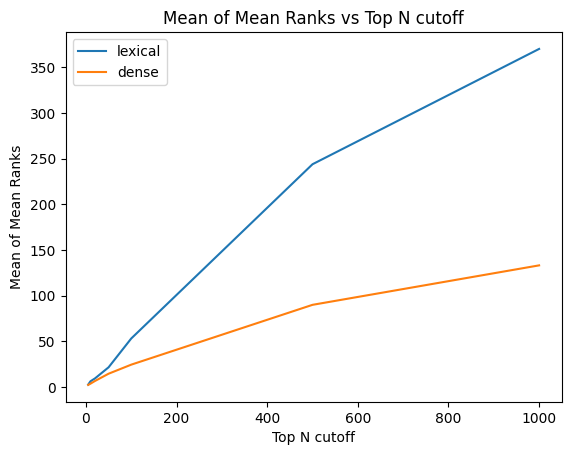

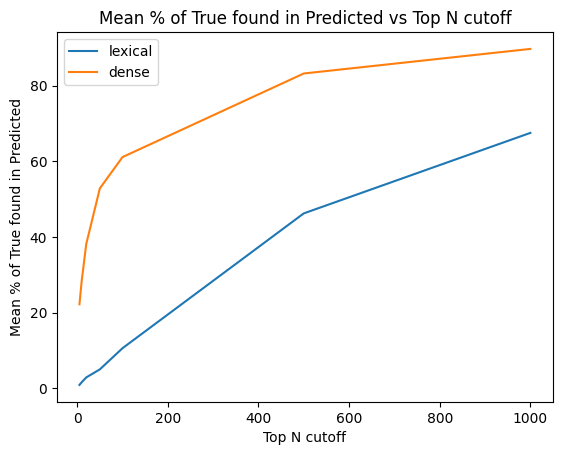

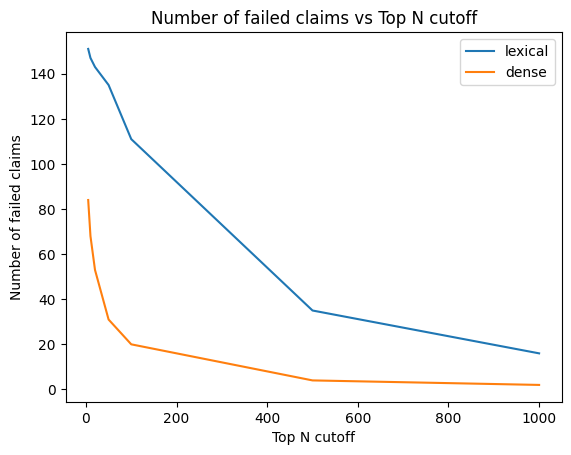

In [ ]:
metrics = [
    "Mean of Mean Ranks",
    "Mean % of True found in Predicted",
    "Number of failed claims"
]
methods = ["lexical", "dense"]

for metric in metrics:
    plt.figure()
    for method in methods:
        y_values = [out_dict[method][n][metric] for n in top_n_list]
        plt.plot(top_n_list, y_values, label=method)
    plt.xlabel("Top N cutoff")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Top N cutoff")
    plt.legend()
    plt.show()

From the table below and the diagnostics (mean rank, % of true evidences retrieved, and number of “failed” claims), the **dense** retriever is clearly superior to the pure TF–IDF (**lexical**) approach at every cutoff.

| Cutoff (Top N) | Dense: Mean Rank | Lexical: Mean Rank | Dense: % True Found | Lexical: % True Found | Dense: # Fails | Lexical: # Fails |
| -------------: | ---------------: | -----------------: | ------------------: | --------------------: | -------------: | ---------------: |
|           1000 |            133.2 |              370.3 |              89.7 % |                67.5 % |              2 |               16 |
|            500 |             90.0 |              244.0 |              83.2 % |                46.2 % |              4 |               35 |
|            100 |             24.5 |               53.2 |              61.1 % |                10.6 % |             20 |              111 |
|             50 |             14.6 |               21.6 |              52.9 % |                 5.0 % |             31 |              135 |
|             20 |              6.6 |                9.5 |              38.1 % |                 2.9 % |             53 |              143 |
|             10 |              3.7 |                6.3 |              28.4 % |                 1.6 % |             68 |              147 |
|              5 |              2.3 |                2.7 |              22.2 % |                 0.9 % |             84 |              151 |

**Which Top N is the best “sweet spot”?**

Looking for elbow where adding more candidates gives diminishing returns:

* **N=20**: Dense already recovers \~38 % of true evidences, with mean rank ≈ 6
* **N=100**: Dense already recovers \~61 % of true evidences, with mean rank ≈ 24.
* **N=500**: Dense jumps to \~83 % and only 4 misses—but it’s 5× heavier.

For a **lightweight** retrieval that still gets most evidences in, **Top 20** is a good compromise. If ultra-high recall (≈ > 80 %) and near-zero misses is critical, bump up to **Top 500**.

Hence for the rest of the code we used **Top 20** evidences from the **dense retriever** as the candidates input for the re-ranker


In [ ]:
out_dict

{'lexical': {1000: {'Mean of Mean Ranks': 370.28,
   'Mean % of True found in Predicted': 67.53,
   'Number of failed claims': 16},
  500: {'Mean of Mean Ranks': 244.0,
   'Mean % of True found in Predicted': 46.24,
   'Number of failed claims': 35},
  100: {'Mean of Mean Ranks': 53.17,
   'Mean % of True found in Predicted': 10.58,
   'Number of failed claims': 111},
  50: {'Mean of Mean Ranks': 21.61,
   'Mean % of True found in Predicted': 4.98,
   'Number of failed claims': 135},
  20: {'Mean of Mean Ranks': 9.45,
   'Mean % of True found in Predicted': 2.85,
   'Number of failed claims': 143},
  10: {'Mean of Mean Ranks': 6.29,
   'Mean % of True found in Predicted': 1.58,
   'Number of failed claims': 147},
  5: {'Mean of Mean Ranks': 2.67,
   'Mean % of True found in Predicted': 0.87,
   'Number of failed claims': 151}},
 'dense': {1000: {'Mean of Mean Ranks': 133.24,
   'Mean % of True found in Predicted': 89.74,
   'Number of failed claims': 2},
  500: {'Mean of Mean Ranks': 9

In [ ]:
out_dict

{'lexical': {1000: {'Mean of Mean Ranks': np.float64(370.28),
   'Mean % of True found in Predicted': np.float64(67.53),
   'Number of failed claims': 16},
  500: {'Mean of Mean Ranks': np.float64(244.0),
   'Mean % of True found in Predicted': np.float64(46.24),
   'Number of failed claims': 35},
  100: {'Mean of Mean Ranks': np.float64(53.17),
   'Mean % of True found in Predicted': np.float64(10.58),
   'Number of failed claims': 111},
  50: {'Mean of Mean Ranks': np.float64(21.61),
   'Mean % of True found in Predicted': np.float64(4.98),
   'Number of failed claims': 135},
  20: {'Mean of Mean Ranks': np.float64(9.45),
   'Mean % of True found in Predicted': np.float64(2.85),
   'Number of failed claims': 143},
  10: {'Mean of Mean Ranks': np.float64(6.29),
   'Mean % of True found in Predicted': np.float64(1.58),
   'Number of failed claims': 147},
  5: {'Mean of Mean Ranks': np.float64(2.67),
   'Mean % of True found in Predicted': np.float64(0.87),
   'Number of failed claims':

In [ ]:
# Methods and evaluation cutoffs
methods = ["lexical", "dense", "hybrid"]
top_n_list = [1000, 500, 100, 50, 20, 10, 5]

# Precompute retrieval buffers up to the maximum cutoff
buffer = {m: {} for m in methods}
max_n = max(top_n_list)

for ci in tqdm(dev_claims_list, desc="Buffering retrievals"):
    claim_text = get_claim(ci, 2)
    buffer["lexical"][ci] = lexical_retrieval(claim_text, top_n=max_n)
    buffer["dense"][ci]   = dense_retrieval(claim_text, top_n=max_n)
    buffer["hybrid"][ci]  = hybrid_retrieval(
        claim_text,
        top_lexical=max_n,
        top_dense=max_n,
        top_k=max_n
    )

# Initialize output dictionary
out_dict = {m: {n: {} for n in top_n_list} for m in methods}

# Evaluate each method at each cutoff
for method in methods:
    for n in top_n_list:
        mean_ranks = []
        percent_true = []
        failed = []

        for ci in tqdm(dev_claims_list, desc=f"Evaluating {method} @ {n}"):
            gold_ids = list(get_evidence(ci, 2).keys())
            pred_ids = buffer[method][ci][:n]
            report = claim_report(gold_ids, pred_evi=pred_ids)

            if report["Ranks"]:
                mean_ranks.append(report["Mean Rank"])
            else:
                failed.append(ci)
            percent_true.append(report["% of True found in Predicted"])

        out_dict[method][n]["Mean of Mean Ranks"] = R2(np.mean(mean_ranks)) if mean_ranks else None
        out_dict[method][n]["Mean % of True found in Predicted"] = R2(np.mean(percent_true)) if percent_true else None
        out_dict[method][n]["Number of failed claims"] = len(failed)

Evaluating hybrid @ 5: 100%|██████████| 154/154 [00:00<00:00, 37317.17it/s]


In [ ]:
out_dict

{'lexical': {10: {'Mean of Mean Ranks': np.float64(3.85),
   'Mean % of True found in Predicted': np.float64(19.5),
   'Number of failed claims': 97},
  5: {'Mean of Mean Ranks': np.float64(2.3),
   'Mean % of True found in Predicted': np.float64(14.27),
   'Number of failed claims': 107}},
 'dense': {10: {'Mean of Mean Ranks': np.float64(3.67),
   'Mean % of True found in Predicted': np.float64(28.43),
   'Number of failed claims': 68},
  5: {'Mean of Mean Ranks': np.float64(2.31),
   'Mean % of True found in Predicted': np.float64(22.2),
   'Number of failed claims': 84}},
 'hybrid': {10: {'Mean of Mean Ranks': np.float64(3.67),
   'Mean % of True found in Predicted': np.float64(28.43),
   'Number of failed claims': 68},
  5: {'Mean of Mean Ranks': np.float64(2.31),
   'Mean % of True found in Predicted': np.float64(22.2),
   'Number of failed claims': 84}}}

In [ ]:
this_top_n = 1000
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} lexical_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

In [ ]:
methods = ["lexical", "dense", "hybrid"]
top_n_list = [1000, 500, 100, 50, 20, 10, 5]

buffer = dict(zip(methods, [{} for _ in ["lexical", "dense", "hybrid"]]))

in_dict = dict(zip(top_n_list, [{} for _ in top_n_list]))
out_dict = dict(zip(methods, [in_dict for _ in ["lexical", "dense", "hybrid"]]))

this_n = max(top_n_list)
for ci in tqdm(dev_claims_list):
  for this_method in methods:
    if this_method == "lexical":
      buffer[this_method][ci] = lexical_retrieval(get_claim(ci, 2), top_n=this_n)
    elif this_method == "dense":
      buffer[this_method][ci] = dense_retrieval(get_claim(ci, 2), top_n=this_n)
    elif this_method == "hybrid":
      buffer[this_method][ci] = hybrid_retrieval(get_claim(ci, 2), this_n, this_n, this_n)

for this_method in methods:
  mean_ranks_dict = dict(zip(top_n_list, [[] for _ in top_n_list]))
  percent_true_dict = dict(zip(top_n_list, [[] for _ in top_n_list]))
  not_found_dict = dict(zip(top_n_list, [[] for _ in top_n_list]))
  for this_n in top_n_list:


    for ci in tqdm(dev_claims_list):
      if this_method == "lexical":
        cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = buffer[this_method][ci][:this_n])
      elif this_method == "dense":
        cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = buffer[this_method][ci][:this_n])
      elif this_method == "hybrid":
        cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = buffer[this_method][ci][:this_n])
      if cl_report["Ranks"]:
        mean_ranks_dict[this_n].append(cl_report["Mean Rank"])
      else:
        not_found_dict[this_n].append(ci)
      percent_true_dict[this_n].append(cl_report["% of True found in Predicted"])

    out_dict[this_method][this_n]["Mean of Mean Ranks"] = R2(float(np.mean(mean_ranks_dict[this_n])))
    out_dict[this_method][this_n]["Mean % of True found in Predicted"] = R2(float(np.mean(percent_true_dict[this_n])))
    out_dict[this_method][this_n]["Number of failed claims"] = len(not_found_dict[this_n])
# out_dict[this_method][this_n]["Failed claims"] = not_found


# print(f"{this_top_n} lexical_retrieval")
# print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
# print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
# print(f"Number of failed claims: {len(not_found)}")
# print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:00<00:00, 27887.18it/s]


In [ ]:
out_dict

{'lexical': {10: {'Mean of Mean Ranks': 3.67,
   'Mean % of True found in Predicted': 28.43,
   'Number of failed claims': 68},
  5: {'Mean of Mean Ranks': 2.31,
   'Mean % of True found in Predicted': 22.2,
   'Number of failed claims': 84}},
 'dense': {10: {'Mean of Mean Ranks': 3.67,
   'Mean % of True found in Predicted': 28.43,
   'Number of failed claims': 68},
  5: {'Mean of Mean Ranks': 2.31,
   'Mean % of True found in Predicted': 22.2,
   'Number of failed claims': 84}},
 'hybrid': {10: {'Mean of Mean Ranks': 3.67,
   'Mean % of True found in Predicted': 28.43,
   'Number of failed claims': 68},
  5: {'Mean of Mean Ranks': 2.31,
   'Mean % of True found in Predicted': 22.2,
   'Number of failed claims': 84}}}

In [ ]:
methods = ["lexical", "dense", "hybrid"]
top_n_list = [1000, 500, 100, 50, 20, 10, 5]
top_n_list = [10, 5]

in_dict = dict(zip(top_n_list, [{} for _ in top_n_list]))
out_dict = dict(zip(methods, [in_dict for _ in ["lexical", "dense", "hybrid"]]))

for this_method in methods:
  mean_ranks, percent_true, not_found = [], [], []
  for this_n in top_n_list:


    for ci in tqdm(dev_claims_list):
      if this_method == "lexical":
        cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=this_n))
      elif this_method == "dense":
        cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = dense_retrieval(get_claim(ci, 2), top_n=this_n))
      elif this_method == "hybrid":
        cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = hybrid_retrieval(get_claim(ci, 2), this_n, this_n, this_n))
      if cl_report["Ranks"]:
        mean_ranks.append(cl_report["Mean Rank"])
      else:
        not_found.append(ci)
      percent_true.append(cl_report["% of True found in Predicted"])
  out_dict[this_method][this_n]["Mean of Mean Ranks"] = R2(float(np.mean(mean_ranks)))
  out_dict[this_method][this_n]["Mean % of True found in Predicted"] = R2(float(np.mean(percent_true)))
  out_dict[this_method][this_n]["Number of failed claims"] = len(not_found)
# out_dict[this_method][this_n]["Failed claims"] = not_found


# print(f"{this_top_n} lexical_retrieval")
# print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
# print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
# print(f"Number of failed claims: {len(not_found)}")
# print(f"Failed claims: {not_found}")

In [ ]:
out_dict

{'lexical': {10: {},
  5: {'Mean of Mean Ranks': 3.06,
   'Mean % of True found in Predicted': 25.31,
   'Number of failed claims': 152}},
 'dense': {10: {},
  5: {'Mean of Mean Ranks': 3.06,
   'Mean % of True found in Predicted': 25.31,
   'Number of failed claims': 152}},
 'hybrid': {10: {},
  5: {'Mean of Mean Ranks': 3.06,
   'Mean % of True found in Predicted': 25.31,
   'Number of failed claims': 152}}}

In [ ]:
out_dict

{'lexical': {10: {},
  5: {'Mean of Mean Ranks': 1.25,
   'Mean % of True found in Predicted': 1.3,
   'Number of failed claims': 152}},
 'dense': {10: {},
  5: {'Mean of Mean Ranks': 1.25,
   'Mean % of True found in Predicted': 1.3,
   'Number of failed claims': 152}},
 'hybrid': {10: {},
  5: {'Mean of Mean Ranks': 1.25,
   'Mean % of True found in Predicted': 1.3,
   'Number of failed claims': 152}}}

In [ ]:
top_n_list = [1000, 500, 100, 50, 20, 10, 5]
methods = ["lexical", "dense", "hybrid"]
in_dict = dict(zip(top_n_list, [{} for _ in top_n_list]))
out_dict = dict(zip(methods, [in_dict for _ in ["lexical", "dense", "hybrid"]]))


for this_method in tqdm(methods):
  for this_top_n in tqdm(top_n_list):
    for ci in tqdm(dev_claims_list):
      if this_method == "lexical":
        preds_lexical = lexical_retrieval(get_claim(ci, 2), top_n=this_top_n)

In [ ]:
top_n_list = [1000, 500, 100, 50, 20, 10, 5]
methods = ["lexical", "dense", "hybrid"]
in_dict = dict(zip(top_n_list, [{} for _ in top_n_list]))
out_dict = dict(zip(methods, [in_dict for _ in ["lexical", "dense", "hybrid"]]))

means = dict(zip(methods, [[] for _ in ["lexical", "dense", "hybrid"]]))
percent_true = dict(zip(methods, [[] for _ in ["lexical", "dense", "hybrid"]]))
not_found_count = dict(zip(methods, [[] for _ in ["lexical", "dense", "hybrid"]]))

this_method = "hybrid"

for ci in tqdm(dev_claims_list):
  preds_lexical = lexical_retrieval(get_claim(ci, 2), top_n=1000)
  preds_dense = dense_retrieval(get_claim(ci, 2), top_n=1000)
  preds_hybrid = hybrid_retrieval(get_claim(ci, 2), top_lexical=1000, top_dense=1000, top_k=1000)

  evis = list(get_evidence(ci, 2).keys())
  for this_top_n in top_n_list:
    cl_report_lexical = claim_report(evis, pred_evi = preds_lexical[:this_top_n])
    cl_report_dense = claim_report(evis, pred_evi = preds_dense[:this_top_n])
    cl_report_hybrid = claim_report(evis, pred_evi = preds_hybrid[:this_top_n])
    if this_method == "lexical":
      out_dict[this_method][this_top_n] = cl_report_lexical
    elif this_method == "dense":
      out_dict[this_method][this_top_n] = cl_report_dense
    elif this_method == "hybrid":
      out_dict[this_method][this_top_n] = cl

for this_method in methods:
  if this_method == "lexical":
    out_dict[this_method][this_top_n] = cl_report_lexical
  elif this_method == "dense":
    out_dict[this_method][this_top_n] = cl_report_dense
  elif this_method == "hybrid":
    out_dict[this_method][this_top_n] = cl

res_dict = {}
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(, pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} lexical_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

In [ ]:
# # prompt: top_n_list = [1000, 500, 100, 50, 20, 10, 5]
# # methods = ["lexical", "dense", "hybrid"]
# # in_dict = dict(zip(top_n_list, [{} for _ in top_n_list]))
# # out_dict = dict(zip(methods, [in_dict for _ in ["lexical", "dense", "hybrid"]]))
# # for ci in tqdm(dev_claims_list):
# #   preds_lexical = lexical_retrieval(get_claim(ci, 2), top_n=1000)
# #   preds_dense = dense_retrieval(get_claim(ci, 2), top_n=1000)
# #   preds_hybrid = hybrid_retrieval(get_claim(ci, 2), top_lexical=1000, top_dense=1000, top_k=1000)
# #   evis = list(get_evidence(ci, 2).keys())
# #   for this_top_n in top_n_list:
# #     cl_report_lexical = claim_report(evis, pred_evi = preds_lexical[:this_top_n])
# #     cl_report_dense = claim_report(evis, pred_evi = preds_dense[:this_top_n])
# #     cl_report_hybrid = claim_report(evis, pred_evi = preds_hybrid[:this_top_n])
# #     if this_method == "lexical":
# #       out_dict[this_method][this_top_n] = cl_report_lexical
# #     elif this_method == "dense":
# #       out_dict[this_method][this_top_n] = cl_report_dense
# #     elif this_method == "hybrid":
# #       out_dict[this_method][this_top_n] = cl
# # complete thecode above . fill the out_dict with the below for the respective method and top_n_list item
# # print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
# # print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
# # print(f"Number of failed claims: {len(not_found)}")
# # print(f"Failed claims: {not_found}")
# top_n_list = [1000, 500, 100, 50, 20, 10, 5]
# methods = ["lexical", "dense", "hybrid"]
# in_dict = dict(zip(top_n_list, [{} for _ in top_n_list]))
# out_dict = dict(zip(methods, [in_dict for _ in ["lexical", "dense", "hybrid"]]))

# import numpy as np
# for this_method in methods:
#     for this_top_n in top_n_list:
#         mean_ranks, percent_true, not_found = [], [], []
#         evis = list(get_evidence(ci, 2).keys())
#         for ci in dev_claims_list: # No need for tqdm here as it was used in the prediction generation
#             if this_method == "lexical":
#                 # Get the report for lexical retrieval for this top_n
#                 cl_report = claim_report(evis, pred_evi=preds_lexical[:this_top_n])
#             elif this_method == "dense":
#                 # Get the report for dense retrieval for this top_n
#                 cl_report = claim_report(evis, pred_evi=preds_dense[:this_top_n])
#             elif this_method == "hybrid":
#                 # Get the report for hybrid retrieval for this top_n
#                 cl_report = claim_report(evis, pred_evi=preds_hybrid[:this_top_n])

#             # Store the full claim report dictionary
#             # This overwrites the previous placeholder, which is fine
#             out_dict[this_method][this_top_n] = cl_report

# for this_method in methods:
#     print(f"\n--- {this_method} ---")
#     for this_top_n in top_n_list:
#         mean_ranks, percent_true, not_found = [], [], []
#         # Iterate through each claim's report for this method and top_n

#         # The out_dict[this_method][this_top_n] currently holds the report for the *last* claim processed
#         # This structure of out_dict is not suitable for aggregating metrics across all claims

#         # Let's redefine out_dict to store a list of reports for each method and top_n
#         out_dict_aggregated = dict(zip(methods, [{} for _ in methods]))
#         for method in methods:
#              out_dict_aggregated[method] = dict(zip(top_n_list, [[] for _ in top_n_list]))

#
#         for ci in tqdm(dev_claims_list):
#             preds_lexical = lexical_retrieval(get_claim(ci, 2), top_n=1000)
#             preds_dense = dense_retrieval(get_claim(ci, 2), top_n=1000)
#             preds_hybrid = hybrid_retrieval(get_claim(ci, 2), top_lexical=1000, top_dense=1000, top_k=1000)
#             evis = list(get_evidence(ci, 2).keys())

#             for this_top_n in top_n_list:
#                 cl_report_lexical = claim_report(evis, pred_evi=preds_lexical[:this_top_n])
#                 cl_report_dense = claim_report(evis, pred_evi=preds_dense[:this_top_n])
#                 cl_report_hybrid = claim_report(evis, pred_evi=preds_hybrid[:this_top_n])

#                 out_dict_aggregated["lexical"][this_top_n].append(cl_report_lexical)
#                 out_dict_aggregated["dense"][this_top_n].append(cl_report_dense)
#                 out_dict_aggregated["hybrid"][this_top_n].append(cl_report_hybrid)

#         # Now aggregate and print
#         for this_method in methods:
#             print(f"\n--- {this_method} ---")
#             for this_top_n in top_n_list:
#                 all_mean_ranks_for_top_n = []
#                 all_percent_true_for_top_n = []
#                 failed_claims_for_top_n = []

#                 reports_for_this_config = out_dict_aggregated[this_method][this_top_n]

#                 for report in reports_for_this_config:
#                     if "Mean Rank" in report:
#                         all_mean_ranks_for_top_n.append(report["Mean Rank"])
#                     else:
#                          pass # Cannot easily track failed claims from just the report

#                     if "% of True found in Predicted" in report:
#                         all_percent_true_for_top_n.append(report["% of True found in Predicted"])

#                 # Re-calculate not_found based on whether any true evidence was found in the predictions
#                 failed_claims_for_top_n_count = sum(1 for report in reports_for_this_config if report["True Positive Count"] == 0 and report["Total True Evidences"] > 0)


#                 print(f"\n{this_top_n} {this_method}_retrieval")

#                 # Calculate and print the means only if there are values
#                 if all_mean_ranks_for_top_n:
#                     print(f"Mean of Mean Ranks: {R2(float(np.mean(all_mean_ranks_for_top_n)))}")
#                 else:
#                     print("Mean of Mean Ranks: N/A (no claims found true evidence with ranks)")

#                 if all_percent_true_for_top_n:
#                     print(f"Mean % of True found in Predicted: {R2(float(np.mean(all_percent_true_for_top_n)))}")
#                 else:
#                     print("Mean % of True found in Predicted: N/A")

#                 print(f"Number of failed claims: {failed_claims_for_top_n_count}")
#                 # Printing the failed claims list itself would require storing the claim IDs, which is not in the current report structure.
#                 # print(f"Failed claims: {not_found}") # This line is commented out as 'not_found' is not correctly populated for printing specific IDs here.


In [ ]:
this_top_n = 1000
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} lexical_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:25<00:00,  6.09it/s]

1000 lexical_retrieval
Mean of Mean Ranks: 370.28
Mean % of True found in Predicted: 67.53
Number of failed claims: 16
Failed claims: ['claim-2796', 'claim-161', 'claim-2062', 'claim-1160', 'claim-2426', 'claim-1567', 'claim-540', 'claim-1407', 'claim-2579', 'claim-2441', 'claim-38', 'claim-1420', 'claim-281', 'claim-2809', 'claim-897', 'claim-2400']


In [ ]:
this_top_n = 1000
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = dense_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} dense_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:27<00:00,  5.53it/s]

1000 dense_retrieval
Mean of Mean Ranks: 133.24
Mean % of True found in Predicted: 89.74
Number of failed claims: 2
Failed claims: ['claim-1607', 'claim-609']


In [ ]:
this_top_n = 1000
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = hybrid_retrieval(get_claim(ci, 2), this_top_n, this_top_n, this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} hybrid_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:54<00:00,  2.80it/s]

1000 hybrid_retrieval
Mean of Mean Ranks: 132.63
Mean % of True found in Predicted: 89.74
Number of failed claims: 2
Failed claims: ['claim-1607', 'claim-609']


In [ ]:
this_top_n = 500
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} lexical_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:24<00:00,  6.26it/s]

500 lexical_retrieval
Mean of Mean Ranks: 190.8
Mean % of True found in Predicted: 61.21
Number of failed claims: 21
Failed claims: ['claim-1607', 'claim-2796', 'claim-161', 'claim-2062', 'claim-1160', 'claim-2426', 'claim-1567', 'claim-540', 'claim-1407', 'claim-3069', 'claim-2250', 'claim-2579', 'claim-173', 'claim-2441', 'claim-38', 'claim-492', 'claim-1420', 'claim-281', 'claim-2809', 'claim-897', 'claim-2400']


In [ ]:
this_top_n = 500
mean_ranks, percent_true, not_found = [], [], []
for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = dense_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} dense_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:27<00:00,  5.55it/s]

500 dense_retrieval
Mean of Mean Ranks: 18.5
Mean % of True found in Predicted: 100.0
Number of failed claims: 0
Failed claims: []


In [ ]:
this_top_n = 100
mean_ranks, percent_true, not_found = [], [], []
for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} lexical_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:23<00:00,  6.51it/s]

100 lexical_retrieval
Mean of Mean Ranks: 6.0
Mean % of True found in Predicted: 50.0
Number of failed claims: 0
Failed claims: []


In [ ]:
this_top_n = 100
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = dense_retrieval(get_claim(ci, 2), top_n=1000))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print("1000 dense_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:27<00:00,  5.54it/s]

1000 dense_retrieval
Mean of Mean Ranks: 18.5
Mean % of True found in Predicted: 100.0
Number of failed claims: 0
Failed claims: []


In [ ]:
this_top_n = 50
mean_ranks, percent_true, not_found = [], [], []
for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} lexical_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:24<00:00,  6.33it/s]

50 lexical_retrieval
Mean of Mean Ranks: 6.0
Mean % of True found in Predicted: 50.0
Number of failed claims: 0
Failed claims: []


In [ ]:
this_top_n = 50
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = dense_retrieval(get_claim(ci, 2), top_n=1000))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print("1000 dense_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:27<00:00,  5.58it/s]

1000 dense_retrieval
Mean of Mean Ranks: 18.5
Mean % of True found in Predicted: 100.0
Number of failed claims: 0
Failed claims: []


In [ ]:
this_top_n = 10
mean_ranks, percent_true, not_found = [], [], []
for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} lexical_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:24<00:00,  6.36it/s]

10 lexical_retrieval
Mean of Mean Ranks: 6.0
Mean % of True found in Predicted: 50.0
Number of failed claims: 0
Failed claims: []


In [ ]:
this_top_n = 10
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = dense_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print("10 dense_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:30<00:00,  5.07it/s]

10 dense_retrieval
Mean of Mean Ranks: 3.67
Mean % of True found in Predicted: 28.43
Number of failed claims: 68
Failed claims: ['claim-375', 'claim-1607', 'claim-1718', 'claim-1786', 'claim-2796', 'claim-1219', 'claim-75', 'claim-2335', 'claim-161', 'claim-2243', 'claim-2184', 'claim-1975', 'claim-139', 'claim-2062', 'claim-1160', 'claim-2679', 'claim-2768', 'claim-785', 'claim-2426', 'claim-2593', 'claim-1567', 'claim-757', 'claim-1407', 'claim-3070', 'claim-1519', 'claim-3069', 'claim-677', 'claim-765', 'claim-2275', 'claim-2300', 'claim-2250', 'claim-3051', 'claim-1549', 'claim-2579', 'claim-1416', 'claim-331', 'claim-2034', 'claim-578', 'claim-976', 'claim-1097', 'claim-609', 'claim-173', 'claim-2441', 'claim-2478', 'claim-3091', 'claim-1689', 'claim-443', 'claim-1734', 'claim-2093', 'claim-1400', 'claim-1040', 'claim-368', 'claim-2583', 'claim-1420', 'claim-742', 'claim-1167', 'claim-181', 'claim-281', 'claim-2809', 'claim-2787', 'claim-478', 'claim-988', 'claim-897', 'claim-386'

In [ ]:
this_top_n = 10
mean_ranks, percent_true, not_found = [], [], []

for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = hybrid_retrieval(get_claim(ci, 2), this_top_n, this_top_n, this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print("10 hybrid_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:52<00:00,  2.93it/s]

10 hybrid_retrieval
Mean of Mean Ranks: 3.67
Mean % of True found in Predicted: 28.43
Number of failed claims: 68
Failed claims: ['claim-375', 'claim-1607', 'claim-1718', 'claim-1786', 'claim-2796', 'claim-1219', 'claim-75', 'claim-2335', 'claim-161', 'claim-2243', 'claim-2184', 'claim-1975', 'claim-139', 'claim-2062', 'claim-1160', 'claim-2679', 'claim-2768', 'claim-785', 'claim-2426', 'claim-2593', 'claim-1567', 'claim-757', 'claim-1407', 'claim-3070', 'claim-1519', 'claim-3069', 'claim-677', 'claim-765', 'claim-2275', 'claim-2300', 'claim-2250', 'claim-3051', 'claim-1549', 'claim-2579', 'claim-1416', 'claim-331', 'claim-2034', 'claim-578', 'claim-976', 'claim-1097', 'claim-609', 'claim-173', 'claim-2441', 'claim-2478', 'claim-3091', 'claim-1689', 'claim-443', 'claim-1734', 'claim-2093', 'claim-1400', 'claim-1040', 'claim-368', 'claim-2583', 'claim-1420', 'claim-742', 'claim-1167', 'claim-181', 'claim-281', 'claim-2809', 'claim-2787', 'claim-478', 'claim-988', 'claim-897', 'claim-386

In [ ]:
ci

'claim-1021'

In [ ]:
this_top_n= 50
print(lexical_retrieval(get_claim(ci, 2), top_n=this_top_n))
print(dense_retrieval(get_claim(ci, 2), top_n=this_top_n))
print(hybrid_retrieval(get_claim(ci, 2), this_top_n, this_top_n, this_top_n))

['evidence-808349', 'evidence-275061', 'evidence-620509', 'evidence-546845', 'evidence-1192178', 'evidence-1175280', 'evidence-1096940', 'evidence-510781', 'evidence-1183952', 'evidence-772468', 'evidence-464047', 'evidence-479580', 'evidence-556510', 'evidence-1163684', 'evidence-1109959', 'evidence-886566', 'evidence-3210', 'evidence-116941', 'evidence-1154331', 'evidence-376866', 'evidence-1050619', 'evidence-178479', 'evidence-296095', 'evidence-812543', 'evidence-193494', 'evidence-111985', 'evidence-232707', 'evidence-2572', 'evidence-40720', 'evidence-398589', 'evidence-758777', 'evidence-274224', 'evidence-270388', 'evidence-135639', 'evidence-880015', 'evidence-212438', 'evidence-75901', 'evidence-294225', 'evidence-1048667', 'evidence-400530', 'evidence-209422', 'evidence-991467', 'evidence-568649', 'evidence-938928', 'evidence-884511', 'evidence-333326', 'evidence-940910', 'evidence-785289', 'evidence-121245', 'evidence-772642']
['evidence-1175280', 'evidence-1050619', 'evid

In [ ]:
this_top_n = 5
mean_ranks, percent_true, not_found = [], [], []
for ci in tqdm(dev_claims_list):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} lexical_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:24<00:00,  6.32it/s]

5 lexical_retrieval
Mean of Mean Ranks: nan
Mean % of True found in Predicted: 0.0
Number of failed claims: 1
Failed claims: ['claim-1021']



/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
this_top_n = 5
mean_ranks, percent_true, not_found = [], [], []
for ci_index, ci in enumerate(tqdm(dev_claims_list)):
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = dense_retrieval(get_claim(ci, 2), top_n=this_top_n))
  if len(cl_report["Ranks"]) != 0:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print(f"{this_top_n} dense_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:27<00:00,  5.53it/s]

5 dense_retrieval
Mean of Mean Ranks: 2.31
Mean % of True found in Predicted: 22.2
Number of failed claims: 84
Failed claims: ['claim-375', 'claim-1607', 'claim-1718', 'claim-1786', 'claim-2796', 'claim-1219', 'claim-75', 'claim-2335', 'claim-161', 'claim-2243', 'claim-2184', 'claim-104', 'claim-1975', 'claim-139', 'claim-2062', 'claim-1160', 'claim-2679', 'claim-2768', 'claim-785', 'claim-2426', 'claim-993', 'claim-2593', 'claim-1567', 'claim-1834', 'claim-757', 'claim-1407', 'claim-3070', 'claim-1745', 'claim-1515', 'claim-1519', 'claim-3069', 'claim-677', 'claim-765', 'claim-2275', 'claim-2060', 'claim-1087', 'claim-2300', 'claim-2250', 'claim-3051', 'claim-1549', 'claim-2579', 'claim-1416', 'claim-331', 'claim-2034', 'claim-578', 'claim-976', 'claim-1097', 'claim-609', 'claim-173', 'claim-2441', 'claim-756', 'claim-2478', 'claim-3091', 'claim-1689', 'claim-443', 'claim-1734', 'claim-2093', 'claim-1400', 'claim-1643', 'claim-1259', 'claim-1040', 'claim-368', 'claim-2583', 'claim-492

In [ ]:
ci_index = 34
print(dev_claims_list[ci_index])
print(dense_retrieval(get_claim(dev_claims_list[ci_index], 2), top_n=5))
print(list(get_evidence(dev_claims_list[ci_index], 2).keys()))
claim_report(list(get_evidence(dev_claims_list[ci_index], 2).keys()), dense_retrieval(get_claim(dev_claims_list[ci_index], 2), top_n=5))

claim-2426
['evidence-461050', 'evidence-846475', 'evidence-185243', 'evidence-410700', 'evidence-433225']
['evidence-697238']


{'True Positive Count': 0,
 'True Positive %': 0.0,
 'Total True Evidences': 1,
 'Total Predicted': 5,
 '% of True found in Predicted': 0.0,
 'Ranks': []}

##### Runs

In [ ]:
# test_claim = "Sea level rise, which was occurring long before humans could be blamed, has not accelerated and still amounts to only 1 inch every ten years."
cid = "claim-2691"
test_claim  = dev_claims[cid]["claim_text"]
print(test_claim)

There are a myriad of other radiative forcings that affect the planet's energy imbalance.


In [ ]:
cands = lexical_retrieval(test_claim, top_n=500)    # or dense_retrieval()

top5 = rerank_with_basebert(test_claim, cands)
top5

[('evidence-202502', 0.9998782873153687, 0.18710560824962813),
 ('evidence-329363', 0.9998736381530762, 0.14178807232531465),
 ('evidence-504117', 0.9998735189437866, 0.16433904560253162),
 ('evidence-899797', 0.9998716115951538, 0.23021099065095388),
 ('evidence-521797', 0.9998714923858643, 0.1503218844500949)]

In [ ]:
cands = lexical_retrieval(test_claim, top_n=500)    # or dense_retrieval()

top5 = rerank_with_basebert(test_claim, cands, top_k=5)
top5

[('evidence-202502', 0.9998782873153687, 0.18710560824962813),
 ('evidence-329363', 0.9998736381530762, 0.14178807232531465),
 ('evidence-504117', 0.9998735189437866, 0.16433904560253162),
 ('evidence-899797', 0.9998716115951538, 0.23021099065095388),
 ('evidence-521797', 0.9998714923858643, 0.1503218844500949)]

In [ ]:
cands = dense_retrieval(test_claim, top_n=500)    # or dense_retrieve()

top5 = rerank_with_basebert(test_claim, cands, top_k=5)
top5

[('evidence-202502', 0.9998782873153687, 0.48032671213150024),
 ('evidence-980334', 0.9998742341995239, 0.5169898271560669),
 ('evidence-1109944', 0.9998737573623657, 0.5254895687103271),
 ('evidence-329363', 0.9998736381530762, 0.5313637256622314),
 ('evidence-504117', 0.9998735189437866, 0.6084696054458618)]

In [ ]:
cands = lexical_retrieval(test_claim, top_n=500)    # or dense_retrieve()

top5 = rerank_with_distilbert(test_claim, cands, top_k=5)
top5

[('evidence-553459', 0.9991757273674011, 0.16791275464731198),
 ('evidence-318638', 0.9991747736930847, 0.1937341355595003),
 ('evidence-371208', 0.9991725087165833, 0.15274301855272662),
 ('evidence-611464', 0.999170184135437, 0.14648286442796782),
 ('evidence-1074121', 0.9991673231124878, 0.35428312520793104)]

In [ ]:
cands = dense_retrieval(test_claim, top_n=500)    # or dense_retrieve()

top5 = rerank_with_distilbert(test_claim, cands, top_k=5)
top5

[('evidence-269849', 0.9991783499717712, 0.4717578887939453),
 ('evidence-553459', 0.9991757273674011, 0.7191096544265747),
 ('evidence-318638', 0.9991747736930847, 0.570610523223877),
 ('evidence-232533', 0.999171257019043, 0.5207499265670776),
 ('evidence-611464', 0.999170184135437, 0.46021223068237305)]

### Stage 2a: BERT reranker



#### A. Point-wise Classification

#### B. Pair-wise or List-wise Ranking

##### Hard Negatives

In [ ]:
new_pairs = []

TOP_N = 50     # how many dense candidates to consider
K_NEG = 2      # how many negatives per positive

for cid in tqdm(train_claims_list):
    claim_text = get_claim(cid, 1)
    gold_ids   = set(get_evidence(cid, 1).keys())
    # get TOP_N near-misses
    candidates = dense_retrieval(claim_text, top_n=TOP_N)
    # filter out all true evidences
    hard_candidates = [eid for eid in candidates if eid not in gold_ids]

    # for each true evidence, sample K_NEG hard negatives
    for i, true_e in enumerate(gold_ids):
        # pick the next K_NEG negatives in a round‐robin fashion
        start = (i * K_NEG) % len(hard_candidates)
        for neg_e in hard_candidates[start : start + K_NEG]:
            new_pairs.append((claim_text,
                              evidence_dict[true_e],
                              evidence_dict[neg_e]))

100%|██████████| 1228/1228 [03:43<00:00,  5.50it/s]


In [ ]:
# with open("saves/pairwise_train_hardneg_roundrobin.pkl", "wb") as f:
#     pickle.dump(new_pairs, f)

In [ ]:
new_pairs = []

TOP_N = 50     # how many dense candidates to consider
K_NEG = 2      # how many negatives per positive

for cid in tqdm(dev_claims_list):
    claim_text = get_claim(cid, 2)
    gold_ids   = set(get_evidence(cid, 2).keys())
    # get TOP_N near-misses
    candidates = dense_retrieval(claim_text, top_n=TOP_N)
    # filter out all true evidences
    hard_candidates = [eid for eid in candidates if eid not in gold_ids]

    # for each true evidence, sample K_NEG hard negatives
    for i, true_e in enumerate(gold_ids):
        # pick the next K_NEG negatives in a round‐robin fashion
        start = (i * K_NEG) % len(hard_candidates)
        for neg_e in hard_candidates[start : start + K_NEG]:
            new_pairs.append((claim_text,
                              evidence_dict[true_e],
                              evidence_dict[neg_e]))

100%|██████████| 154/154 [00:31<00:00,  4.94it/s]


In [ ]:
# with open("saves/pairwise_dev_hardneg_roundrobin.pkl", "wb") as f:
#     pickle.dump(new_pairs, f)

##### Training

######  Base Bert

In [ ]:
import warnings

# Suppress any warning that mentions “overflowing tokens”
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")

# Silence the HuggingFace tokenizer logger
from transformers import logging
logging.set_verbosity_error()


import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW                      # <-- use AdamW from torch
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.nn import MarginRankingLoss

# Hyper-parameters
MODEL_NAME     = "bert-base-uncased"
BATCH_SIZE     = 8
LR             = 1e-5  #2e-5
EPOCHS         = 10 # 3
MARGIN         = 0.5  # 1.0
MAX_LEN        = 128
PAIRWISE_TRAIN = "saves/pairwise_train_hardneg_roundrobin.pkl"
PAIRWISE_DEV   = "saves/pairwise_dev_hardneg_roundrobin.pkl"
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
with open(PAIRWISE_TRAIN, "rb") as f:
    train_pairs = pickle.load(f)
with open(PAIRWISE_DEV, "rb") as f:
    dev_pairs   = pickle.load(f)
## Pairwise Format: list of tuples Example Claim-1 has 3 True evidences then:
## [ (<Claim-1>, <True-Evidence-1>, <False-Evidence-X1>),
##   (<Claim-1>, <True-Evidence-1>, <False-Evidence-X2>),
##   (<Claim-1>, <True-Evidence-2>, <False-Evidence-X3>),
##   (<Claim-1>, <True-Evidence-2>, <False-Evidence-X4>),
##   (<Claim-1>, <True-Evidence-3>, <False-Evidence-X5>),
##   (<Claim-1>, <True-Evidence-3>, <False-Evidence-X6>)
##   (<Claim-2>, <True-Evidence-1>, <False-Evidence-Y1>), ... ]


print(f"len(train_pairs): {len(train_pairs)}")
print(f"len(dev_pairs): {len(dev_pairs)}")
# Expected format: a list of dicts like
#   {"claim": str, "pos": str, "neg": str}

len(train_pairs): 8244
len(dev_pairs): 982


In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Dataset class for tuple format
class PairwiseDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        claim, pos, neg = self.pairs[idx]
        enc_pos = tokenizer(
            claim, pos,
            padding="max_length", truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        )
        enc_neg = tokenizer(
            claim, neg,
            padding="max_length", truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "pos_ids":  enc_pos["input_ids"].squeeze(0),
            "pos_mask": enc_pos["attention_mask"].squeeze(0),
            "neg_ids":  enc_neg["input_ids"].squeeze(0),
            "neg_mask": enc_neg["attention_mask"].squeeze(0),
        }

# DataLoaders
train_ds = PairwiseDataset(train_pairs)
dev_ds   = PairwiseDataset(dev_pairs)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_SIZE)

# Model definition (same as before)
class BertRanker(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert   = BertModel.from_pretrained(model_name)
        self.scorer = torch.nn.Linear(self.bert.config.hidden_size, 1)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled  = outputs.pooler_output
        score   = self.scorer(pooled).squeeze(-1)
        return score

NameError: name 'train_pairs' is not defined

In [ ]:
model   = BertRanker(MODEL_NAME).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
margin_loss = MarginRankingLoss(margin=MARGIN)

# Training loop (unchanged)
for epoch in range(EPOCHS):
    model.train()
    bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in bar:
        optimizer.zero_grad()
        pos_score = model(batch["pos_ids"].to(DEVICE), batch["pos_mask"].to(DEVICE))
        neg_score = model(batch["neg_ids"].to(DEVICE), batch["neg_mask"].to(DEVICE))
        target    = torch.ones_like(pos_score, device=DEVICE)
        loss      = margin_loss(pos_score, neg_score, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        bar.set_postfix(loss=loss.item())

#  Save model
# torch.save(model.state_dict(), "bert_pairwise_reranker-NAME THIS.pt")
# print("Finished training – model saved to bert_pairwise_reranker.pt")

Epoch 10/10: 100%|██████████| 1031/1031 [06:09<00:00,  2.79it/s, loss=0]


In [ ]:
# Save model
torch.save(model.state_dict(), "saves/bert_pairwise_hardneg_hr0.5.pt")
print("Finished training – model saved to saves/bert_pairwise_hardneg_hr0.pt")

Finished training – model saved to saves/bert_pairwise_hardneg_hr0.pt


###### Distil bert

In [ ]:
! pip install --upgrade transformers

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import pickle
from torch.utils.data import Dataset
import numpy as np
from transformers import TrainingArguments

# Hyperparameters
MODEL_NAME    = "distilbert-base-uncased"
OUTPUT_DIR    = "./distilbert-reranker_Test"
BATCH_SIZE    = 16
LR            = 5e-5
EPOCHS        = 6
MAX_LEN       = 128
TRAIN_FILE    = "saves/pairwise_train_data_02.pkl"
DEV_FILE      = "saves/pairwise_dev_data_02.pkl"
# TRAIN_FILE    = "saves/pairwise_train_hardneg_roundrobin.pkl"
# DEV_FILE      = "saves/pairwise_dev_hardneg_roundrobin.pkl"

# Load pairwise data (list of (claim, pos, neg) tuples)
with open(TRAIN_FILE, "rb") as f:
    train_pairs = pickle.load(f)
with open(DEV_FILE, "rb") as f:
    dev_pairs = pickle.load(f)

# Build classification examples from pairwise tuples
train_texts, train_labels = [], []
for claim, pos, neg in train_pairs:
    train_texts.append((claim, pos))
    train_labels.append(1)
    train_texts.append((claim, neg))
    train_labels.append(0)

dev_texts, dev_labels = [], []
for claim, pos, neg in dev_pairs:
    dev_texts.append((claim, pos))
    dev_labels.append(1)
    dev_texts.append((claim, neg))
    dev_labels.append(0)

# Tokenizer & Dataset
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

class RerankDataset(Dataset):
    def __init__(self, text_pairs, labels):
        texts = [(t[0], t[1]) for t in text_pairs]
        self.encodings = tokenizer(
            [t[0] for t in texts],
            [t[1] for t in texts],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN
        )
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = RerankDataset(train_texts, train_labels)
dev_dataset   = RerankDataset(dev_texts,   dev_labels)

# Model initialization
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)


training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=int(EPOCHS),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    report_to="none",         # ← disable wandb (and any other trackers)
    run_name="distilbert-reranker",

)

# Compute metrics function
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train
trainer.train()

# ave final model
trainer.save_model(OUTPUT_DIR)


<ipython-input-43-e3aca4e00b74>:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.236, 'grad_norm': 0.08370237797498703, 'learning_rate': 4.51988360814743e-05, 'epoch': 0.09699321047526673}
{'loss': 0.1713, 'grad_norm': 22.567262649536133, 'learning_rate': 4.034917555771096e-05, 'epoch': 0.19398642095053345}
{'loss': 0.1103, 'grad_norm': 0.6549879908561707, 'learning_rate': 3.5499515033947626e-05, 'epoch': 0.2909796314258002}
{'loss': 0.0818, 'grad_norm': 0.05995083227753639, 'learning_rate': 3.064985451018429e-05, 'epoch': 0.3879728419010669}
{'loss': 0.0683, 'grad_norm': 0.016729583963751793, 'learning_rate': 2.580019398642095e-05, 'epoch': 0.48496605237633367}
{'loss': 0.0544, 'grad_norm': 0.016297735273838043, 'learning_rate': 2.0950533462657614e-05, 'epoch': 0.5819592628516004}
{'loss': 0.074, 'grad_norm': 0.048050399869680405, 'learning_rate': 1.610087293889428e-05, 'epoch': 0.6789524733268671}
{'loss': 0.0506, 'grad_norm': 0.021842757239937782, 'learning_rate': 1.1251212415130942e-05, 'epoch': 0.7759456838021338}
{'loss': 0.0472, 'grad_norm': 0.017

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm
import pickle

#  Hyperparameters
MODEL_NAME    = "distilbert-base-uncased"
OUTPUT_DIR    = "./distilbert-reranker-tqdm"
BATCH_SIZE    = 16
LR            = 5e-5
EPOCHS        = 6
MAX_LEN       = 128
TRAIN_FILE    = "saves/pairwise_train_data_02.pkl"
DEV_FILE      = "saves/pairwise_dev_data_02.pkl"
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pairwise data as binary classification examples
with open(TRAIN_FILE, "rb") as f:
    train_pairs = pickle.load(f)
with open(DEV_FILE, "rb") as f:
    dev_pairs = pickle.load(f)

train_texts, train_labels = [], []
for claim, pos, neg in train_pairs:
    train_texts.append((claim, pos)); train_labels.append(1)
    train_texts.append((claim, neg)); train_labels.append(0)

dev_texts, dev_labels = [], []
for claim, pos, neg in dev_pairs:
    dev_texts.append((claim, pos)); dev_labels.append(1)
    dev_texts.append((claim, neg)); dev_labels.append(0)

# Tokenizer and DataLoader
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
def encode(text_pairs, labels):
    enc = tokenizer([c for c, e in text_pairs],
                    [e for c, e in text_pairs],
                    padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
    return torch.utils.data.TensorDataset(enc["input_ids"], enc["attention_mask"], torch.tensor(labels))

train_dataset = encode(train_texts, train_labels)
dev_dataset   = encode(dev_texts,   dev_labels)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader    = DataLoader(dev_dataset,   batch_size=BATCH_SIZE)

# 4) Model, optimizer, scheduler
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss()

# Training loop with tqdm
for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    total_loss = 0
    for input_ids, attention_mask, labels in train_bar:
        input_ids, attention_mask, labels = input_ids.to(DEVICE), attention_mask.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        train_bar.set_postfix(loss=total_loss / (train_bar.n + 1))

    # Evaluation loop
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in dev_loader:
            input_ids, attention_mask, labels = input_ids.to(DEVICE), attention_mask.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total * 100
    print(f"Validation Accuracy after epoch {epoch+1}: {acc:.2f}%")

# # Save model
# torch.save(model.state_dict(), f"{OUTPUT_DIR}/distilbert_tqdm.pt")


Epoch 1/6: 100%|██████████| 1031/1031 [03:00<00:00,  5.70it/s, loss=0.0845]


Validation Accuracy after epoch 1: 98.32%


Epoch 2/6: 100%|██████████| 1031/1031 [02:58<00:00,  5.77it/s, loss=0.017]


Validation Accuracy after epoch 2: 98.27%


Epoch 3/6: 100%|██████████| 1031/1031 [03:00<00:00,  5.72it/s, loss=0.0106]


Validation Accuracy after epoch 3: 98.57%


Epoch 4/6: 100%|██████████| 1031/1031 [02:59<00:00,  5.76it/s, loss=0.00543]


Validation Accuracy after epoch 4: 98.12%


Epoch 5/6: 100%|██████████| 1031/1031 [02:58<00:00,  5.77it/s, loss=0.00266]


Validation Accuracy after epoch 5: 98.73%


Epoch 6/6: 100%|██████████| 1031/1031 [02:58<00:00,  5.77it/s, loss=0.00116]


Validation Accuracy after epoch 6: 98.78%


In [ ]:
# # Save model
torch.save(model.state_dict(), "saves/distilbert_pairwise_001.pt")
print("Finished training – model saved to saves/bert_pairwise_hardneg_hr0.pt")

Finished training – model saved to saves/bert_pairwise_hardneg_hr0.pt


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm
import pickle

# Hyperparameters
MODEL_NAME    = "distilbert-base-uncased"
OUTPUT_DIR    = "./distilbert-reranker-tqdm"
BATCH_SIZE    = 16
LR            = 5e-5
EPOCHS        = 6
MAX_LEN       = 128
TRAIN_FILE    = "saves/pairwise_train_hardneg_roundrobin.pkl"
DEV_FILE      = "saves/pairwise_dev_hardneg_roundrobin.pkl"
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pairwise data as binary classification examples
with open(TRAIN_FILE, "rb") as f:
    train_pairs = pickle.load(f)
with open(DEV_FILE, "rb") as f:
    dev_pairs = pickle.load(f)

train_texts, train_labels = [], []
for claim, pos, neg in train_pairs:
    train_texts.append((claim, pos)); train_labels.append(1)
    train_texts.append((claim, neg)); train_labels.append(0)

dev_texts, dev_labels = [], []
for claim, pos, neg in dev_pairs:
    dev_texts.append((claim, pos)); dev_labels.append(1)
    dev_texts.append((claim, neg)); dev_labels.append(0)

# Tokenizer and DataLoader
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
def encode(text_pairs, labels):
    enc = tokenizer([c for c, e in text_pairs],
                    [e for c, e in text_pairs],
                    padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
    return torch.utils.data.TensorDataset(enc["input_ids"], enc["attention_mask"], torch.tensor(labels))

train_dataset = encode(train_texts, train_labels)
dev_dataset   = encode(dev_texts,   dev_labels)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader    = DataLoader(dev_dataset,   batch_size=BATCH_SIZE)

# Model, optimizer, scheduler
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss()

# Training loop with tqdm
for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    total_loss = 0
    for input_ids, attention_mask, labels in train_bar:
        input_ids, attention_mask, labels = input_ids.to(DEVICE), attention_mask.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        train_bar.set_postfix(loss=total_loss / (train_bar.n + 1))

    # Evaluation loop
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in dev_loader:
            input_ids, attention_mask, labels = input_ids.to(DEVICE), attention_mask.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total * 100
    print(f"Validation Accuracy after epoch {epoch+1}: {acc:.2f}%")

# Save model
# torch.save(model.state_dict(), f"{OUTPUT_DIR}/distilbert_tqdm.pt")


Epoch 1/6: 100%|██████████| 1031/1031 [02:59<00:00,  5.76it/s, loss=0.614]


Validation Accuracy after epoch 1: 66.04%


Epoch 2/6: 100%|██████████| 1031/1031 [02:58<00:00,  5.77it/s, loss=0.396]


Validation Accuracy after epoch 2: 67.31%


Epoch 3/6: 100%|██████████| 1031/1031 [02:58<00:00,  5.77it/s, loss=0.193]


Validation Accuracy after epoch 3: 66.04%


Epoch 4/6: 100%|██████████| 1031/1031 [02:58<00:00,  5.77it/s, loss=0.091]


Validation Accuracy after epoch 4: 66.96%


Epoch 5/6: 100%|██████████| 1031/1031 [02:58<00:00,  5.77it/s, loss=0.0435]


Validation Accuracy after epoch 5: 65.68%


Epoch 6/6: 100%|██████████| 1031/1031 [02:58<00:00,  5.77it/s, loss=0.0228]


Validation Accuracy after epoch 6: 66.40%


In [ ]:
#Save model
torch.save(model.state_dict(), "saves/distilbert_pairwise_hardneg_001.pt")
print("Finished training – model saved to saves/distilbert_pairwise_hardneg_001.pt")

Finished training – model saved to saves/distilbert_pairwise_hardneg_001.pt


##### Validation

###### Base-bert

In [ ]:
def basebert_rerank_with_pairwise(claim_text, candidate_ids):
    scores = []
    for eid in candidate_ids:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text,
            sent,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        with torch.no_grad():
            score_tensor = model(input_ids, attention_mask)
        score = score_tensor.squeeze(0).item()
        scores.append((eid, score))
    sorted_list = sorted(scores, key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in sorted_list]



In [ ]:
import warnings
from transformers import logging
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRanker(MODEL_NAME).to(device)
state = torch.load("saves/bert_pairwise_reranker.pt", map_location=device)
model.load_state_dict(state)
model.eval()

# 1) Suppress the “overflowing tokens” warning
warnings.filterwarnings("ignore", message="Be aware, overflowing tokens are not returned*")
logging.set_verbosity_error()

# 2) Inference helper remains unchanged

# 3) Eval parameters
top_N = 20   # Stage 1 cutoff
K     = 5    # Keep Top K after reranking

# 4) Build label lists and reports
y_true = []
y_pred = []
results = []

for cid in tqdm(dev_claims_list, desc="Labeling candidates"):
    claim_text = get_claim(cid, 2)
    candidates = dense_retrieval(claim_text, top_n=top_N)
    ranked     = rerank_with_pairwise(claim_text, candidates)
    pred_topK  = set(ranked[:K])
    gold_ids   = set(get_evidence(cid, 2).keys())

    # Collect per-claim report
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)

    # Build flat labels
    for eid in candidates:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5) Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print()
print(f"Precision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {top_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")

Labeling candidates: 100%|██████████| 154/154 [01:03<00:00,  2.41it/s]


Precision:           0.1221
Recall:              0.5497
F1 Score:            0.1998
Confusion Matrix:
[[2233  676]
 [  77   94]]
Avg Mean Rank (within Top 20): 2.75
Avg % True@5:            22.20%


In [ ]:
# Reload trained pairwise reranker
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRanker(MODEL_NAME).to(device)
state = torch.load("saves/bert_pairwise_hardneg_hr0.5.pt", map_location=device)
model.load_state_dict(state)
model.eval()

# 1) Suppress the “overflowing tokens” warning
warnings.filterwarnings("ignore", message="Be aware, overflowing tokens are not returned*")
logging.set_verbosity_error()


# 3) Eval parameters
top_N = 20   # Stage 1 cutoff
K     = 5    # Keep Top K after reranking

# 4) Build label lists and reports
y_true = []
y_pred = []
results = []

for cid in tqdm(dev_claims_list, desc="Labeling candidates"):
    claim_text = get_claim(cid, 2)
    candidates = dense_retrieval(claim_text, top_n=top_N)
    ranked     = rerank_with_pairwise(claim_text, candidates)
    pred_topK  = set(ranked[:K])
    gold_ids   = set(get_evidence(cid, 2).keys())

    # Collect per-claim report
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)

    # Build flat labels
    for eid in candidates:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5) Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print()
print(f"Precision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {top_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")


Labeling candidates: 100%|██████████| 154/154 [01:04<00:00,  2.39it/s]


Precision:           0.1117
Recall:              0.5029
F1 Score:            0.1828
Confusion Matrix:
[[2225  684]
 [  85   86]]
Avg Mean Rank (within Top 20): 2.88
Avg % True@5:            20.48%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRanker(MODEL_NAME).to(device)
state = torch.load("saves/bert_pairwise_reranker_hardneg_roundrobin.pt", map_location=device)
model.load_state_dict(state)
model.eval()

# 1) Suppress the “overflowing tokens” warning
warnings.filterwarnings("ignore", message="Be aware, overflowing tokens are not returned*")
logging.set_verbosity_error()


# 3) Eval parameters
top_N = 20   # Stage 1 cutoff
K     = 5    # Keep Top K after reranking

# 4) Build label lists and reports
y_true = []
y_pred = []
results = []

for cid in tqdm(dev_claims_list, desc="Labeling candidates"):
    claim_text = get_claim(cid, 2)
    candidates = dense_retrieval(claim_text, top_n=top_N)
    ranked     = rerank_with_pairwise(claim_text, candidates)
    pred_topK  = set(ranked[:K])
    gold_ids   = set(get_evidence(cid, 2).keys())

    # Collect per-claim report
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)

    # Build flat labels
    for eid in candidates:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5) Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print()
print(f"Precision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {top_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")


Labeling candidates: 100%|██████████| 154/154 [01:05<00:00,  2.36it/s]


Precision:           0.1065
Recall:              0.4795
F1 Score:            0.1743
Confusion Matrix:
[[2221  688]
 [  89   82]]
Avg Mean Rank (within Top 20): 3.00
Avg % True@5:            18.96%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRanker(MODEL_NAME).to(device)
state = torch.load("saves/bert_pairwise_reranker.pt", map_location=device)
model.load_state_dict(state)
model.eval()

# 1) Suppress the “overflowing tokens” warning
warnings.filterwarnings("ignore", message="Be aware, overflowing tokens are not returned*")
logging.set_verbosity_error()


# 3) Eval parameters
top_N = 20   # Stage 1 cutoff
K     = 5    # Keep Top K after reranking

# 4) Build label lists and reports
y_true = []
y_pred = []
results = []

for cid in tqdm(dev_claims_list, desc="Labeling candidates"):
    claim_text = get_claim(cid, 2)
    candidates = dense_retrieval(claim_text, top_n=top_N)
    ranked     = rerank_with_pairwise(claim_text, candidates)
    pred_topK  = set(ranked[:K])
    gold_ids   = set(get_evidence(cid, 2).keys())

    # Collect per-claim report
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)

    # Build flat labels
    for eid in candidates:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5) Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print()
print(f"Precision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {top_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")


Labeling candidates: 100%|██████████| 154/154 [01:05<00:00,  2.36it/s]


Precision:           0.1221
Recall:              0.5497
F1 Score:            0.1998
Confusion Matrix:
[[2233  676]
 [  77   94]]
Avg Mean Rank (within Top 20): 3.27
Avg % True@5:            22.20%


In [ ]:

# 1) Suppress the “overflowing tokens” warning
warnings.filterwarnings("ignore", message="Be aware, overflowing tokens are not returned*")
try:
    from transformers import logging
    logging.set_verbosity_error()
except ImportError:
    pass

# 2) Imports for metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tqdm import tqdm


def rerank_with_pairwise(claim_text, candidate_ids):
    """
    Given a claim and a list of evidence IDs (candidate_ids),
    returns the IDs sorted by descending model score.
    """
    scores = []
    for eid in candidate_ids:
        sent = evidence_dict[eid]
        # Tokenize into a batch of size 1 (keep 2D shape)
        enc = tokenizer(
            claim_text,
            sent,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        input_ids = enc["input_ids"].to(device)           # shape: (1, seq_len)
        attention_mask = enc["attention_mask"].to(device) # shape: (1, seq_len)

        # Score without squeezing the batch dimension
        with torch.no_grad():
            score_tensor = model(input_ids, attention_mask)  # returns shape (1,)
        score = score_tensor.squeeze(0).item()               # scalar score

        scores.append((eid, score))

    # Sort by score descending
    sorted_list = sorted(scores, key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in sorted_list]


# 3) Eval parameters
top_N = 20   # Stage 1 cutoff
K     = 5    # Keep Top K after reranking

# 4) Build label lists
y_true = []
y_pred = []
results = []
for cid in tqdm(dev_claims_list, desc="Labeling candidates"):
    claim_text = get_claim(cid, 2)
    # Stage 1 retrieval
    candidates = dense_retrieval(claim_text, top_n=top_N)
    # Stage 2 reranking
    ranked     = rerank_with_pairwise(claim_text, candidates)
    pred_topK  = set(ranked[:K])
    gold_ids   = set(get_evidence(cid, 2).keys())

    # Compute metrics per claim
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)
    # Label each candidate
    for eid in candidates:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5) Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)

mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print()
print(f"Precision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {top_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")

Labeling candidates: 100%|██████████| 154/154 [01:05<00:00,  2.36it/s]


Precision:           0.1221
Recall:              0.5497
F1 Score:            0.1998
Confusion Matrix:
[[2233  676]
 [  77   94]]
Avg Mean Rank (within Top 20): 2.92
Avg % True@5:            22.20%


In [ ]:
## dense_retrieval

# 1) Suppress the “overflowing tokens” warning
warnings.filterwarnings("ignore", message="Be aware, overflowing tokens are not returned*")
try:
    from transformers import logging
    logging.set_verbosity_error()
except ImportError:
    pass



# 3) Eval parameters
top_N = 20   # Stage 1 cutoff
K     = 5    # Keep Top K after reranking

# 4) Build label lists
y_true = []
y_pred = []
results = []
for cid in tqdm(dev_claims_list, desc="Labeling candidates"):
    claim_text = get_claim(cid, 2)
    # Stage 1 retrieval
    candidates = dense_retrieval(claim_text, top_n=top_N)
    # Stage 2 reranking
    # ranked     = rerank_with_pairwise(claim_text, candidates)
    ranked     = candidates

    pred_topK  = set(ranked[:K])
    gold_ids   = set(get_evidence(cid, 2).keys())

    # Compute metrics per claim
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)
    # Label each candidate
    for eid in candidates:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5) Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)

mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print()
print(f"Precision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {top_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")

Labeling candidates: 100%|██████████| 154/154 [00:36<00:00,  4.16it/s]


Precision:           0.1234
Recall:              0.5556
F1 Score:            0.2019
Confusion Matrix:
[[2234  675]
 [  76   95]]
Avg Mean Rank (within Top 20): 3.06
Avg % True@5:            22.20%


In [ ]:
## lexical_retrieval

# 1) Suppress the “overflowing tokens” warning
warnings.filterwarnings("ignore", message="Be aware, overflowing tokens are not returned*")
try:
    from transformers import logging
    logging.set_verbosity_error()
except ImportError:
    pass



# 3) Eval parameters
top_N = 20   # Stage 1 cutoff
K     = 5    # Keep Top K after reranking

# 4) Build label lists
y_true = []
y_pred = []
results = []
for cid in tqdm(dev_claims_list, desc="Labeling candidates"):
    claim_text = get_claim(cid, 2)
    # Stage 1 retrieval
    candidates = lexical_retrieval(claim_text, top_n=top_N)
    # Stage 2 reranking
    # ranked     = rerank_with_pairwise(claim_text, candidates)
    ranked     = candidates

    pred_topK  = set(ranked[:K])
    gold_ids   = set(get_evidence(cid, 2).keys())

    # Compute metrics per claim
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)
    # Label each candidate
    for eid in candidates:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5) Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)

mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print()
print(f"Precision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {top_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")

Labeling candidates: 100%|██████████| 154/154 [00:25<00:00,  6.00it/s]


Precision:           0.0701
Recall:              0.4865
F1 Score:            0.1226
Confusion Matrix:
[[2253  716]
 [  57   54]]
Avg Mean Rank (within Top 20): 3.03
Avg % True@5:            14.27%


In [ ]:
ci_index = 6 #random.randint(1, 154) # 6
cid = dev_claims_list[ci_index]
test_claim = get_claim(cid, 2)
top_n = 20
top_k = 5

print(f"Claim id: {cid}")
print(f"Claim: {test_claim}")
print("True Evidences:")
for evi, evi_text in get_evidence(cid, 2).items():
  print(f"{evi}: {evi_text}")
print()

# Stage 1 retrieval
candidates = dense_retrieval(test_claim, top_n=top_n)
# Stage 2 reranking
ranked     = rerank_with_pairwise(test_claim, candidates)
pred_topK  = set(ranked[:top_k])
print(f"Predicted top {top_k}: {pred_topK}")
for this_pred in pred_topK:
  print(f"{this_pred}: {evidence_dict[this_pred]}")
print()
# print("Dense Retrieval")
# print(dense_retrieval(test_claim, top_n=5))
# print(list(get_evidence(cid, 2).keys()))
claim_report(list(get_evidence(cid, 2).keys()), pred_topK)

Claim id: claim-761
Claim: [Riebesell] is a world authority on the topic and has typically communicated cautiously about the effects of acidification.
True Evidences:
evidence-1129386: Perhaps one of the most recent adverse effects of climate change to be explored is that of ocean acidification.
evidence-456747: Climate change is more accurate scientifically to describe the various effects of greenhouse gases on the world because it includes extreme weather, storms and changes in rainfall patterns, ocean acidification and sea level.".
evidence-625922: The direction and magnitude of the effects of ocean acidification, warming and deoxygenation on the ocean has been quantified by meta-analyses, and has been further tested by mesocosm studies.
evidence-590068: (2013) "Meta‐analysis reveals complex marine biological responses to the interactive effects of ocean acidification and warming".
evidence-741718: Both are informed by chemical oceanography, which studies the behavior of elements an

{'True Positive Count': 2,
 'True Positive %': 40.0,
 'Total True Evidences': 5,
 'Total Predicted': 5,
 '% of True found in Predicted': 40.0,
 'Ranks': [2, 4],
 'Mean Rank': 3.0,
 'Median Rank': 3.0}

In [ ]:
claim_report(list(get_evidence(cid, 2).keys()), dense_retrieval(test_claim, top_n=5))

{'True Positive Count': 1,
 'True Positive %': 20.0,
 'Total True Evidences': 5,
 'Total Predicted': 5,
 '% of True found in Predicted': 20.0,
 'Ranks': [3],
 'Mean Rank': 3.0,
 'Median Rank': 3.0}

In [ ]:
dense_retrieval(get_claim(cid, 2), top_n=5)

['evidence-248009',
 'evidence-1171424',
 'evidence-1089698',
 'evidence-534239',
 'evidence-123016']

###### Disitl bert

In [ ]:
# 2) Define reranking helper
def rerank_with_distilbert(claim_text, candidate_ids, max_len=128):
    scores = []
    for eid in candidate_ids:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text,
            sent,
            padding="max_length",
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        ).to(DEVICE)
        with torch.no_grad():
            outputs = model(**enc)
        # logits: [batch, 2] → index 1 is the positive class
        pos_logit = outputs.logits[0, 1].item()
        scores.append((eid, pos_logit))
    # sort candidates by descending positive logit
    sorted_list = sorted(scores, key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in sorted_list]

In [ ]:
import warnings
from transformers import logging as hf_logging, DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_001.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# 1) Suppress tokenizer overflow warnings
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()



# 3) Evaluation parameters
top_N = 20  # Stage 1 retrieval cutoff
K     = 5   # final top-K after reranking

# 4) Build label lists and per-claim reports
y_true = []
y_pred = []
results = []

for cid in tqdm(dev_claims_list, desc="Validating DistilBERT reranker"):
    claim_text = get_claim(cid, 2)
    candidates = dense_retrieval(claim_text, top_n=top_N)
    ranked     = rerank_with_distilbert(claim_text, candidates, max_len=MAX_LEN)
    pred_topK  = set(ranked[:K])
    gold_ids   = set(get_evidence(cid, 2).keys())

    # per-claim metrics
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)

    # flatten for overall metrics
    for eid in candidates:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5) Compute and print overall metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print(f"\nPrecision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {top_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")


Validating DistilBERT reranker: 100%|██████████| 154/154 [00:51<00:00,  2.99it/s]


Precision:           0.1234
Recall:              0.5556
F1 Score:            0.2019
Confusion Matrix:
[[2234  675]
 [  76   95]]
Avg Mean Rank (within Top 20): 2.82
Avg % True@5:            21.82%


In [ ]:
import warnings
from transformers import logging as hf_logging, DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_hardneg_001.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# 1) Suppress tokenizer overflow warnings
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()



# 3) Evaluation parameters
top_N = 20  # Stage 1 retrieval cutoff
K     = 5   # final top-K after reranking

# 4) Build label lists and per-claim reports
y_true = []
y_pred = []
results = []

for cid in tqdm(dev_claims_list, desc="Validating DistilBERT reranker"):
    claim_text = get_claim(cid, 2)
    candidates = dense_retrieval(claim_text, top_n=top_N)
    ranked     = rerank_with_distilbert(claim_text, candidates, max_len=MAX_LEN)
    pred_topK  = set(ranked[:K])
    gold_ids   = set(get_evidence(cid, 2).keys())

    # per-claim metrics
    report = claim_report(gold_ids, pred_evi=pred_topK)
    results.append(report)

    # flatten for overall metrics
    for eid in candidates:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5) Compute and print overall metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print(f"\nPrecision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {top_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")


Validating DistilBERT reranker: 100%|██████████| 154/154 [00:48<00:00,  3.18it/s]


Precision:           0.0935
Recall:              0.4211
F1 Score:            0.1530
Confusion Matrix:
[[2211  698]
 [  99   72]]
Avg Mean Rank (within Top 20): 2.92
Avg % True@5:            15.36%


##### Alpha tune

In [ ]:
import warnings
import torch
import numpy as np
from tqdm import tqdm
from transformers import logging as hf_logging, BertTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup


class BertRanker(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert   = BertModel.from_pretrained(model_name)
        self.scorer = torch.nn.Linear(self.bert.config.hidden_size, 1)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled  = outputs.pooler_output
        score   = self.scorer(pooled).squeeze(-1)
        return score


# 0) Setup
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "bert-base-uncased"
CHECKPOINT_PATH = "saves/bert_pairwise_reranker.pt"

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model     = BertRanker(MODEL_NAME).to(device)  # ensure BertRanker class is loaded
state     = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

# 2) Helper to get BertRanker scores
def get_bert_scores(claim_text, candidate_ids, max_len=128):
    scores = {}
    for eid in candidate_ids:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text,
            sent,
            padding="max_length",
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            score = model(enc["input_ids"], enc["attention_mask"]).item()
        scores[eid] = score
    return scores

# 3) Fusion sweep parameters
TOP_N  = 20
K      = 5
alphas = np.linspace(0, 1, 11)

best_alpha, best_f1 = None, -1.0
results = {}

# 4) Alpha sweep
for alpha in alphas:
    y_true, y_pred = [], []
    for cid in tqdm(dev_claims_list, desc=f"Sweeping α={alpha:.1f}"):
        claim = get_claim(cid, 2)
        dense_scores = dense_retrieval(claim, top_n=TOP_N, show_value=True)
        cands = [eid for eid, _ in dense_scores]
        dense_map = dict(dense_scores)
        bert_map  = get_bert_scores(claim, cands)

        # fuse and rank
        fused = [(eid, alpha * dense_map[eid] + (1 - alpha) * bert_map[eid])
                 for eid in cands]
        ranked = [eid for eid, _ in sorted(fused, key=lambda x: x[1], reverse=True)]
        topk = set(ranked[:K])
        gold = set(get_evidence(cid, 2).keys())

        for eid in cands:
            y_true.append(1 if eid in gold else 0)
            y_pred.append(1 if eid in topk else 0)

    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f = f1_score(y_true, y_pred)
    results[alpha] = {"precision": p, "recall": r, "f1": f}
    if f > best_f1:
        best_f1, best_alpha = f, alpha

# 5) Print results
print("α sweep results:")
for a, m in results.items():
    print(f"α={a:.1f} → P={m['precision']:.3f}, R={m['recall']:.3f}, F1={m['f1']:.3f}")
print(f"\nBest α={best_alpha:.1f} with F1={best_f1:.3f}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Sweeping α=1.0: 100%|██████████| 154/154 [01:03<00:00,  2.43it/s]

α sweep results:
α=0.0 → P=0.122, R=0.550, F1=0.200
α=0.1 → P=0.123, R=0.556, F1=0.202
α=0.2 → P=0.121, R=0.544, F1=0.198
α=0.3 → P=0.122, R=0.550, F1=0.200
α=0.4 → P=0.121, R=0.544, F1=0.198
α=0.5 → P=0.119, R=0.538, F1=0.196
α=0.6 → P=0.121, R=0.544, F1=0.198
α=0.7 → P=0.119, R=0.538, F1=0.196
α=0.8 → P=0.131, R=0.591, F1=0.215
α=0.9 → P=0.132, R=0.596, F1=0.217
α=1.0 → P=0.123, R=0.556, F1=0.202

Best α=0.9 with F1=0.217


In [ ]:
import warnings
import torch
import numpy as np
from tqdm import tqdm
from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    logging as hf_logging
)
from sklearn.metrics import precision_score, recall_score, f1_score
MAX_LEN        = 128
# 0) Setup
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_001.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model     = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(device)
state     = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

# 2) Inference helper (returns positive‐class logit)
def get_bert_scores(claim_text, candidate_ids):
    scores = {}
    for eid in candidate_ids:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text,
            sent,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            logits = model(**enc).logits
        scores[eid] = logits[0,1].item()  # positive‐class logit
    return scores

# 3) Fusion sweep
TOP_N  = 20
K      = 5
alphas = np.linspace(0,1,11)

best_alpha, best_f1 = None, -1.0
results = {}

# for alpha in tqdm(alphas):
for alpha in alphas:
    y_true, y_pred = [], []
    for cid in tqdm(dev_claims_list):
        claim_text    = get_claim(cid,2)
        dense_scores  = dense_retrieval(claim_text, top_n=TOP_N, show_value=True)
        cands         = [eid for eid,_ in dense_scores]
        dense_map     = dict(dense_scores)
        bert_map      = get_bert_scores(claim_text, cands)

        # fuse & rank
        fused = [(eid, alpha*dense_map[eid] + (1-alpha)*bert_map[eid])
                  for eid in cands]
        ranked = [eid for eid,_ in sorted(fused, key=lambda x:x[1], reverse=True)]
        topk   = set(ranked[:K])
        gold   = set(get_evidence(cid,2).keys())

        # flatten for metrics
        for eid in cands:
            y_true.append(1 if eid in gold else 0)
            y_pred.append(1 if eid in topk else 0)

    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f = f1_score(y_true, y_pred)
    results[alpha] = {"precision":p, "recall":r, "f1":f}
    if f>best_f1:
        best_f1, best_alpha = f, alpha

# 4) Print sweep results
print("α sweep results:")
for α, m in results.items():
    print(f"α={α:.1f} → P={m['precision']:.3f}, R={m['recall']:.3f}, F1={m['f1']:.3f}")
print(f"\nBest α={best_alpha:.1f} with F1={best_f1:.3f}")


100%|██████████| 154/154 [00:44<00:00,  3.43it/s]

α sweep results:
α=0.0 → P=0.123, R=0.556, F1=0.202
α=0.1 → P=0.127, R=0.573, F1=0.208
α=0.2 → P=0.132, R=0.596, F1=0.217
α=0.3 → P=0.131, R=0.591, F1=0.215
α=0.4 → P=0.138, R=0.620, F1=0.225
α=0.5 → P=0.140, R=0.632, F1=0.230
α=0.6 → P=0.136, R=0.614, F1=0.223
α=0.7 → P=0.138, R=0.620, F1=0.225
α=0.8 → P=0.145, R=0.655, F1=0.238
α=0.9 → P=0.142, R=0.637, F1=0.232
α=1.0 → P=0.123, R=0.556, F1=0.202

Best α=0.8 with F1=0.238


In [ ]:
import warnings
import torch
import numpy as np
from tqdm import tqdm
from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    logging as hf_logging
)
from sklearn.metrics import precision_score, recall_score, f1_score

# 0) Setup
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_001.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model     = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(device)
state     = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

# 2) Inference helper (returns positive‐class logit)
def get_bert_scores(claim_text, candidate_ids):
    scores = {}
    for eid in candidate_ids:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text,
            sent,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            logits = model(**enc).logits
        scores[eid] = logits[0,1].item()  # positive‐class logit
    return scores

# 3) Fusion sweep
TOP_N  = 20
K      = 5
alphas = np.linspace(0,1,11)

best_alpha, best_f1 = None, -1.0
results = {}

# for alpha in tqdm(alphas):
for alpha in alphas:
    y_true, y_pred = [], []
    for cid in tqdm(dev_claims_list):
        claim_text    = get_claim(cid,2)
        dense_scores  = dense_retrieval(claim_text, top_n=TOP_N, show_value=True)
        cands         = [eid for eid,_ in dense_scores]
        dense_map     = dict(dense_scores)
        bert_map      = get_bert_scores(claim_text, cands)

        # fuse & rank
        fused = [(eid, alpha*dense_map[eid] + (1-alpha)*bert_map[eid])
                  for eid in cands]
        ranked = [eid for eid,_ in sorted(fused, key=lambda x:x[1], reverse=True)]
        topk   = set(ranked[:K])
        gold   = set(get_evidence(cid,2).keys())

        # flatten for metrics
        for eid in cands:
            y_true.append(1 if eid in gold else 0)
            y_pred.append(1 if eid in topk else 0)

    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f = f1_score(y_true, y_pred)
    results[alpha] = {"precision":p, "recall":r, "f1":f}
    if f>best_f1:
        best_f1, best_alpha = f, alpha

# 4) Print sweep results
print("α sweep results:")
for α, m in results.items():
    print(f"α={α:.1f} → P={m['precision']:.3f}, R={m['recall']:.3f}, F1={m['f1']:.3f}")
print(f"\nBest α={best_alpha:.1f} with F1={best_f1:.3f}")


100%|██████████| 154/154 [00:47<00:00,  3.22it/s]

α sweep results:
α=0.0 → P=0.123, R=0.556, F1=0.202
α=0.1 → P=0.127, R=0.573, F1=0.208
α=0.2 → P=0.132, R=0.596, F1=0.217
α=0.3 → P=0.131, R=0.591, F1=0.215
α=0.4 → P=0.138, R=0.620, F1=0.225
α=0.5 → P=0.140, R=0.632, F1=0.230
α=0.6 → P=0.136, R=0.614, F1=0.223
α=0.7 → P=0.138, R=0.620, F1=0.225
α=0.8 → P=0.145, R=0.655, F1=0.238
α=0.9 → P=0.142, R=0.637, F1=0.232
α=1.0 → P=0.123, R=0.556, F1=0.202

Best α=0.8 with F1=0.238


In [ ]:
import warnings
from transformers import logging as hf_logging
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Suppress tokenizer warnings
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

# - device
# - model (DistilBertForSequenceClassification or BertRanker) in eval mode
# - tokenizer
# - dense_retrieval(claim, top_n, show_value=True)
# - get_claim(cid, fmt), get_evidence(cid, fmt)
# - dev_claims_list
# - MAX_LEN
# Set these as needed before running.

TOP_N = 20   # Stage 1 candidate cutoff
K     = 5    # final top-K after reranking

# Define a helper to get BERT scores per candidate
def get_bert_scores(claim_text, candidate_ids):
    scores = {}
    for eid in candidate_ids:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text, sent,
            padding="max_length", truncation=True,
            max_length=MAX_LEN, return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**enc)
        # For sequence classification: outputs.logits shape (1,2)
        # Use the positive-class logit
        pos_logit = outputs.logits[0, 1].item()
        scores[eid] = pos_logit
    return scores

# Grid of alpha values to sweep
alphas = np.linspace(0, 1, 11)

best_alpha = None
best_f1 = -1.0
results = {}

for alpha in alphas:
    y_true = []
    y_pred = []
    for cid in dev_claims_list:
        claim_text = get_claim(cid, 2)
        # Stage 1: retrieve dense scores
        dense_scores = dense_retrieval(claim_text, top_n=TOP_N, show_value=True)
        candidate_ids = [eid for eid, _ in dense_scores]
        # Map dense scores
        dense_score_map = {eid: score for eid, score in dense_scores}
        # Get BERT scores
        bert_score_map = get_bert_scores(claim_text, candidate_ids)
        # Fuse scores and rank
        fused = [(eid, alpha*dense_score_map[eid] + (1-alpha)*bert_score_map[eid])
                 for eid in candidate_ids]
        ranked = [eid for eid, _ in sorted(fused, key=lambda x: x[1], reverse=True)]
        pred_topK = set(ranked[:K])
        gold_ids = set(get_evidence(cid, 2).keys())
        # Flatten labels
        for eid in candidate_ids:
            y_true.append(1 if eid in gold_ids else 0)
            y_pred.append(1 if eid in pred_topK else 0)
    # Compute metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    results[alpha] = {"precision": precision, "recall": recall, "f1": f1}
    if f1 > best_f1:
        best_f1 = f1
        best_alpha = alpha

print("Alpha sweep results:")
for alpha, r in results.items():
    print(f"α={alpha:.1f} → Precision={r['precision']:.3f}, Recall={r['recall']:.3f}, F1={r['f1']:.3f}")
print(f"\nBest α: {best_alpha:.1f} with F1={best_f1:.3f}")


In [ ]:
dev_claims

### Stage 2b: in-context LLM

for “hard” claims (low confidence)

### Stage 2c: logistic regressor

calibrate by combining model logits, or apply a small logistic regressor on top of [dense_score, lexical_score, BERT_score].



## In-context

In [ ]:
! pip install torch transformers accelerate

! pip install bitsandbytes accelerate

In [ ]:
FEW_SHOT_EXAMPLES = []
prompt_claims = ["claim-1937", "claim-126", "claim-2065", "claim-930", ] ##DRSN

for cl in prompt_claims:
    example = {
        "claim": get_claim(cl, 1),               # the claim TEXT, not the key name
        "evidences": []
    }
    for eid, text in get_evidence(cl).items():
        example["evidences"].append(f"{eid}: {text}")
    FEW_SHOT_EXAMPLES.append(example)


In [ ]:
PROMPT_INSTRUCTION = (
    "I will give you a claim, and then a list of candidate sentences (each prefixed by its evidence-ID).\n"
    "Select the top 5 sentences that truly SUPPORT, REFUTE, DISPUTE, or are NOT_ENOUGH_INFO for the claim.\n"
    "Respond with a JSON array of evidence-IDs, in descending order of confidence.\n\n"
)

In [ ]:
import json
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


PROMPT_INSTRUCTION = (
    "I will give you a claim, and then a list of candidate sentences (each prefixed by its evidence-ID).\n"
    "Select the top 5 sentences that truly SUPPORT, REFUTE, DISPUTE, or are NOT_ENOUGH_INFO for the claim.\n"
    "Respond with a JSON array of evidence-IDs, in descending order of confidence.\n\n"
)

# 3) Prompt builder:
def build_prompt(claim, candidates):
    prompt = PROMPT_INSTRUCTION
    for ex in FEW_SHOT_EXAMPLES:
        prompt += f"Claim: {ex['claim']}\nEvidences:\n"
        for e in ex["evidences"]:
            prompt += f"  - {e}\n"
        prompt += "→ [\"evidence-IDs\"]\n\n"
    prompt += f"Claim: {claim}\nCandidates:\n"
    for eid, sent in candidates:
        prompt += f"  - {eid}: {sent}\n"
    prompt += "→\n"
    return prompt

# 4) Output parser:
def parse_ids(text):
    try:
        return json.loads(text.strip())
    except json.JSONDecodeError:
        return re.findall(r"(evidence-\d+)", text)

# 5) Load open-source Falcon 7B Instruct:
model_name = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",      # leverage available GPU
    torch_dtype="auto"
)
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    do_sample=False
)

# 6) In-context reranker function:
def icl_rerank_local(claim, candidates, top_k=5):
    shortlist = candidates # [:100]              # take top-100 from Stage 1
    prompt    = build_prompt(claim, shortlist)
    out       = generator(prompt)[0]["generated_text"]
    picks     = parse_ids(out)
    return picks[:top_k]



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
# 7) Usage example on a single claim:
cid = 'claim-752'
sample_c   = get_claim(cid, 2) # dev_claims["claim-126"]["claim_text"]
candidates = dense_retrieval(sample_c, top_n=20)
print(f"Number of candidates: {len(candidates)}")
top5_ids   = icl_rerank_local(sample_c, candidates)
print("Top 5 evidence IDs:", top5_ids)

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Number of candidates: 20
Top 5 evidence IDs: ['evidence-442946', 'evidence-1194317', 'evidence-12171', 'evidence-338219', 'evidence-1127398']


In [ ]:
cid_index = 100
cid = dev_claims_list[cid_index]
print(cid)
claim_report(list(get_evidence(cid, 2).keys()), pred_evi = dense_retrieval(get_claim(cid, 2), top_n=20))

claim-1638


{'True Positive Count': 3,
 'True Positive %': 15.0,
 'Total True Evidences': 5,
 'Total Predicted': 20,
 '% of True found in Predicted': 60.0,
 'Ranks': [2, 5, 10],
 'Mean Rank': 5.67,
 'Median Rank': 5.0}

In [ ]:
get_evidence(cid, 2)

{'evidence-336096': 'These global climatic changes occurred slowly, prior to the rise of human civilization about 10 thousand years ago near the end of the last Major Ice Age when the climate became more stable.',
 'evidence-418973': "[citation needed] The amount of heat trapping gases emitted into Earth's Oceans and atmosphere will prevent the next ice age, which otherwise would begin in around 50,000 years, and likely more glacial cycles.",
 'evidence-142343': 'Global anthropogenic greenhouse gas emissions in 2010 were equivalent to 49 billion tonnes of carbon dioxide (using the most recent global warming potentials over 100 years from the AR5 report).',
 'evidence-954212': '(Current projected consequences of global warming include a largely ice-free Arctic Ocean within 5–20 years, see Arctic shrinkage.)',
 'evidence-1016625': 'Projections based on the Special Report on Emissions Scenarios suggest warming over the 21st century at a more rapid rate than that experienced for at least t

In [ ]:
sample_c   = get_claim(cid, 2) # dev_claims["claim-126"]["claim_text"]
candidates = dense_retrieval(sample_c, top_n=20, show_value=True)
print(f"Number of candidates: {len(candidates)}")
top5_ids   = icl_rerank_local(sample_c, candidates)
print("Top 5 evidence IDs:", top5_ids)

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Number of candidates: 20
Top 5 evidence IDs: ['evidence-442946', 'evidence-1194317', 'evidence-12171', 'evidence-338219', 'evidence-1127398']


In [ ]:
claim_report(list(get_evidence(cid, 2).keys()), top5_ids)

{'True Positive Count': 0,
 'True Positive %': 0.0,
 'Total True Evidences': 5,
 'Total Predicted': 5,
 '% of True found in Predicted': 0.0,
 'Ranks': []}

In [ ]:
claim_report(list(get_evidence(cid, 2).keys()), dense_retrieval(sample_c, top_n=5))

{'True Positive Count': 2,
 'True Positive %': 40.0,
 'Total True Evidences': 5,
 'Total Predicted': 5,
 '% of True found in Predicted': 40.0,
 'Ranks': [2, 5],
 'Mean Rank': 3.5,
 'Median Rank': 3.5}

In [ ]:
claim_report(list(get_evidence(cid, 2).keys()), lexical_retrieval(sample_c, top_n=5))

{'True Positive Count': 0,
 'True Positive %': 0.0,
 'Total True Evidences': 5,
 'Total Predicted': 5,
 '% of True found in Predicted': 0.0,
 'Ranks': []}

In [ ]:
 get_only_evi = lambda inlist : [tup[0] for tup in inlist]

In [ ]:
cid_index = 100
cid = dev_claims_list[cid_index]

# cid = 'claim-752'
print(f"cid: {cid}")
sample_c   = get_claim(cid, 2)

claim_report(list(get_evidence(cid, 2).keys()), pred_evi = dense_retrieval(sample_c, top_n=100))

cid: claim-1638


{'True Positive Count': 4,
 'True Positive %': 4.0,
 'Total True Evidences': 5,
 'Total Predicted': 100,
 '% of True found in Predicted': 80.0,
 'Ranks': [2, 5, 10, 55],
 'Mean Rank': 18.0,
 'Median Rank': 7.5}

In [ ]:
print(dev_claims_list)

['claim-752', 'claim-375', 'claim-1266', 'claim-871', 'claim-2164', 'claim-1607', 'claim-761', 'claim-1718', 'claim-1273', 'claim-1786', 'claim-2796', 'claim-2580', 'claim-1219', 'claim-75', 'claim-2813', 'claim-2335', 'claim-161', 'claim-2243', 'claim-1256', 'claim-506', 'claim-369', 'claim-2184', 'claim-1057', 'claim-104', 'claim-1975', 'claim-139', 'claim-2062', 'claim-1160', 'claim-2679', 'claim-2662', 'claim-1490', 'claim-2768', 'claim-2168', 'claim-785', 'claim-2426', 'claim-1292', 'claim-993', 'claim-2593', 'claim-1567', 'claim-1834', 'claim-856', 'claim-540', 'claim-757', 'claim-1407', 'claim-3070', 'claim-1745', 'claim-1515', 'claim-1519', 'claim-3069', 'claim-677', 'claim-765', 'claim-2275', 'claim-1113', 'claim-2611', 'claim-2060', 'claim-2326', 'claim-1087', 'claim-2867', 'claim-2300', 'claim-2250', 'claim-2429', 'claim-3051', 'claim-1549', 'claim-261', 'claim-2230', 'claim-2579', 'claim-1416', 'claim-2497', 'claim-811', 'claim-1896', 'claim-2819', 'claim-2643', 'claim-1775

In [ ]:
len(dev_claims_list)

154

In [ ]:
claim_report(list(get_evidence(cid, 2).keys()), pred_evi = get_only_evi(lexical_retrieval(sample_c, top_n=100)))

{'True Positive Count': 0,
 'True Positive %': 0.0,
 'Total True Evidences': 5,
 'Total Predicted': 100,
 '% of True found in Predicted': 0.0,
 'Ranks': []}

In [ ]:
for ci in tqdm(dev_claims_list):
  mean_ranks, percent_true = [], []
  not_found = []
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = lexical_retrieval(get_claim(ci, 2), top_n=1000))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print("1000 lexical_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:33<00:00,  4.66it/s]

1000 lexical_retrieval
Mean of Mean Ranks: 34.0
Mean % of True found in Predicted: 100.0
Number of failed claims: 0
Failed claims: []


In [ ]:
for ci in tqdm(dev_claims_list):
  mean_ranks, percent_true = [], []
  cl_report = claim_report(list(get_evidence(ci, 2).keys()), pred_evi = dense_retrieval(get_claim(ci, 2), top_n=1000))
  if cl_report["Ranks"]:
    mean_ranks.append(cl_report["Mean Rank"])
  else:
    not_found.append(ci)
  percent_true.append(cl_report["% of True found in Predicted"])

print("1000 dense_retrieval")
print(f"Mean of Mean Ranks: {R2(float(np.mean(mean_ranks)))}")
print(f"Mean % of True found in Predicted: {R2(float(np.mean(percent_true)))}")
print(f"Number of failed claims: {len(not_found)}")
print(f"Failed claims: {not_found}")

100%|██████████| 154/154 [00:29<00:00,  5.29it/s]

1000 dense_retrieval
Mean of Mean Ranks: 18.5
Mean % of True found in Predicted: 100.0
Number of failed claims: 2
Failed claims: ['claim-1607', 'claim-609']


In [ ]:
lamine

In [ ]:
get_evidence(cid, 2)

{'evidence-67732': '[citation needed] South Australia has the highest retail price for electricity in the country.',
 'evidence-572512': '"South Australia has the highest power prices in the world".'}

In [ ]:
get_only_evi(candidates)

['evidence-67732',
 'evidence-572512',
 'evidence-780332',
 'evidence-1061888',
 'evidence-452156',
 'evidence-685728',
 'evidence-48256',
 'evidence-1002110',
 'evidence-1050894',
 'evidence-1075134',
 'evidence-769231',
 'evidence-932540',
 'evidence-666596',
 'evidence-493497',
 'evidence-976426',
 'evidence-1172687',
 'evidence-169170',
 'evidence-434720',
 'evidence-622374',
 'evidence-774496']

In [ ]:
candidates

[('evidence-67732', 0.8175122737884521),
 ('evidence-572512', 0.7729942202568054),
 ('evidence-780332', 0.66587895154953),
 ('evidence-1061888', 0.627718985080719),
 ('evidence-452156', 0.6274751424789429),
 ('evidence-685728', 0.5902285575866699),
 ('evidence-48256', 0.5763057470321655),
 ('evidence-1002110', 0.5751571655273438),
 ('evidence-1050894', 0.5724381804466248),
 ('evidence-1075134', 0.56986403465271),
 ('evidence-769231', 0.5675417184829712),
 ('evidence-932540', 0.5656320452690125),
 ('evidence-666596', 0.5643499493598938),
 ('evidence-493497', 0.5639880895614624),
 ('evidence-976426', 0.5628776550292969),
 ('evidence-1172687', 0.5615335702896118),
 ('evidence-169170', 0.5615335702896118),
 ('evidence-434720', 0.5610605478286743),
 ('evidence-622374', 0.5600048303604126),
 ('evidence-774496', 0.5549642443656921)]

## ok Bert

In [ ]:
!pip install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 45.2 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss

Indexed 1208827 vectors.


In [ ]:
with open("saves/evidence_ids_001.pkl", "rb") as f:
    evidence_ids = pickle.load(f)

embeddings = np.load("saves/evidence_embeddings_001.npy")

In [ ]:
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)  # L2 or Inner Product index (normalized vectors + IP = cosine)

faiss.normalize_L2(embeddings)

index.add(embeddings)
print(f"Indexed {index.ntotal} vectors.")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

In [ ]:
def retrieve_dense(claim_text, top_k=5):
    # Embed the claim
    query_vec = embedder.encode([claim_text], convert_to_numpy=True)
    faiss.normalize_L2(query_vec)
    # Search the index
    D, I = index.search(query_vec, top_k)  # distances and indices of top_k
    results = []
    for rank, idx in enumerate(I[0]):
        evid_id = evidence_ids[idx]
        evid_text = evidence_dict[evid_id]
        score = float(D[0][rank])
        results.append((evid_id, evid_text, score))
    return results

In [ ]:
claim   = '“Sea level rise, which was occurring long before humans could be blamed, has not accelerated and still amounts to only 1 inch every ten years.'
dense_results = retrieve_dense(claim, top_k=5)
for evid_id, text, score in dense_results:
    print(f"{evid_id}: {text[:100]}... (score={score:.3f})")
print()
print(f"CORRECT CLAIMS:")
for thisevi in ['evidence-71166',
   'evidence-1018611',
   'evidence-1192617',
   'evidence-646192',
   'evidence-363960']:
  print(f"{thisevi}: {evidence_dict[thisevi]}")

evidence-1192617: "20th century acceleration in global sea-level rise".... (score=0.773)
evidence-365963: This could mean rapid sea level rise of up to 19 mm (0.75 in) per year by the end of the century.... (score=0.716)
evidence-988277: Sea level rise will continue over many centuries.... (score=0.706)
evidence-71166: For instance, a 2016 study led by Jim Hansen concluded that based on past climate change data, sea l... (score=0.701)
evidence-447033: Sea level rise since 1990 was underestimated in older models, but now agrees well with observations.... (score=0.694)

CORRECT CLAIMS:
evidence-71166: For instance, a 2016 study led by Jim Hansen concluded that based on past climate change data, sea level rise could accelerate exponentially in the coming decades, with a doubling time of 10, 20 or 40 years, respectively, raising the ocean by several meters in 50, 100 or 200 years.
evidence-1018611: More precise data gathered from satellite radar measurements reveal an accelerating rise of 

In [ ]:
# def compute_recall_at_k(dev_claims, k=5):
# hits, total = 0, 0
# for cid, entry in dev_claims.items():

# cid = "claim-871"
cid = random.choice(list(dev_claims.keys()))

entry = dev_claims[cid]

print("Input")
print(f"cid = {cid}")
print(f"entry = {entry}")
print()
print(f"Claim = {entry['claim_text']}")
# print(f"Evidences = {entry['evidences']}")
gold = entry['evidences']
for this_evi in gold:
    print(f"{this_evi}: {evidence_dict[this_evi]}")
print()
print("Predictions")
preds = retrieve_dense(entry['claim_text'], 5)
for this_pred in preds:
    pred_evi, pred_sentence, pred_score = this_pred
    print(f"{pred_evi}: {R(pred_score)}: {pred_sentence}")
print()
print("Performance")
tp = 0
for this_evi in gold:
    if this_evi in [pred_evi for pred_evi,_,_ in preds]:
        tp += 1

precision= tp/len(preds)
recall   = tp/len(gold)
print(f"Precision: {tp}/{len(preds)}: {R(precision)}")
print(f"Recall: {tp}/{len(gold)}: {R(recall)}")
if tp>0:
    fscore = 2*precision*recall/(precision+recall)
else:
    fscore = 0.0
print(f"F-score: {R(fscore)}")
print()
print()

# print("Dense recall@5:", compute_recall_at_k(dev_claims, k=5))
# print("Dense recall@10:", compute_recall_at_k(dev_claims, k=10))

Input
cid = claim-1490
entry = {'claim_text': 'the concentration of carbon dioxide in Earth’s atmosphere has climbed to a level last seen more than 3 million years ago — before humans even appeared on the rocky ball we call home.', 'claim_label': 'SUPPORTS', 'evidences': ['evidence-551522']}

Claim = the concentration of carbon dioxide in Earth’s atmosphere has climbed to a level last seen more than 3 million years ago — before humans even appeared on the rocky ball we call home.
evidence-551522: The National Geographic wrote that the concentration of carbon dioxide in the atmosphere is this high "for the first time in 55 years of measurement—and probably more than 3 million years of Earth history."

Predictions
evidence-551522: 0.8: The National Geographic wrote that the concentration of carbon dioxide in the atmosphere is this high "for the first time in 55 years of measurement—and probably more than 3 million years of Earth history."
evidence-648764: 0.78: On 12 November 2015, NASA 

In [ ]:
dev_claims["claim-871"].keys()

dict_keys(['claim_text', 'claim_label', 'evidences'])

In [ ]:
len(dev_claims)

154

In [ ]:
R(0.6776432394981384)

0.68

ModuleNotFoundError: No module named 'faiss'

## Generate Files

### 1.1 Off-the-shelf SBERT + FAISS

In [ ]:
!pip install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 45.2 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-pretrained-bert

In [ ]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss

with open("saves/evidence_ids_001.pkl", "rb") as f:
    evidence_ids = pickle.load(f)

embeddings = np.load("saves/evidence_embeddings_001.npy")

dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)  # L2 or Inner Product index (normalized vectors + IP = cosine)

faiss.normalize_L2(embeddings)

index.add(embeddings)
print(f"Indexed {index.ntotal} vectors.")

device = "cuda" if torch.cuda.is_available() else "cpu"
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

def retrieve_dense(claim_text, top_k=5):
    # Embed the claim
    query_vec = embedder.encode([claim_text], convert_to_numpy=True)
    faiss.normalize_L2(query_vec)
    # Search the index
    D, I = index.search(query_vec, top_k)  # distances and indices of top_k
    results = []
    for rank, idx in enumerate(I[0]):
        evid_id = evidence_ids[idx]
        evid_text = evidence_dict[evid_id]
        score = float(D[0][rank])
        results.append((evid_id, evid_text, score))
    return results

Indexed 1208827 vectors.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from pytorch_pretrained_bert.modeling import BertForSequenceClassification, BertConfig
from pytorch_pretrained_bert.tokenization import BertTokenizer

config     = BertConfig.from_json_file("saves/bert-sentence-retriever_01/config.json")
model      = BertForSequenceClassification(config, num_labels=2)
state_dict = torch.load("saves/bert-sentence-retriever_01/pytorch_model.bin", map_location="cpu")
model.load_state_dict(state_dict)

tokenizer = BertTokenizer.from_pretrained("saves/bert-sentence-retriever_01", do_lower_case=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [ ]:
class InputFeatures(object):
    """
    A single set of features of data for BERT.
    """
    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids   = input_ids
        self.input_mask  = input_mask
        self.segment_ids = segment_ids
        self.label_id    = label_id

class InputExample(object):
    def __init__(self, guid, text_a, text_b, label):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label      # "True"/"False"

def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Two-label (True/False) featurizer for BERT."""
    label_map = { label:i for i,label in enumerate(label_list) }
    features = []
    for ex in examples:
        # tokenize both sentence and claim
        tokens_a = tokenizer.tokenize(ex.text_a)
        tokens_b = tokenizer.tokenize(ex.text_b)


        while len(tokens_a) + len(tokens_b) > max_seq_length - 3:
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()

        # build final token list: [CLS] a [SEP] b [SEP]
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
        segment_ids = [0]*(len(tokens_a)+2) + [1]*(len(tokens_b)+1)

        input_ids  = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1]*len(input_ids)

        padding_len = max_seq_length - len(input_ids)
        input_ids   += [0]*padding_len
        input_mask  += [0]*padding_len
        segment_ids += [0]*padding_len

        # sanity checks
        assert len(input_ids)   == max_seq_length
        assert len(input_mask)  == max_seq_length
        assert len(segment_ids) == max_seq_length

        # map label to integer
        label_id = label_map[ex.label]

        # collect feature object
        features.append(
          InputFeatures(input_ids, input_mask, segment_ids, label_id)
        )

    return features



def predict_evidence(
    claim_text: str,
    candidates: list[tuple[str,str]],
    model: BertForSequenceClassification,
    tokenizer: BertTokenizer,
    device: torch.device,
    top_k: int = 5,
    batch_size: int = 32,
) -> list[tuple[str, float]]:
    """
    Returns the top_k (sentence_id, score) for this claim.
    """
    model.eval()

    # build InputExamples
    examples = []
    for i, (sent_id, sent_text) in enumerate(candidates):
        examples.append(
            InputExample(
                guid=f"pred-{i}",
                text_a=sent_text,
                text_b=claim_text,
                label="False"     # dummy
            )
        )

    # featurize
    feats = convert_examples_to_features(
        examples,
        label_list=["False","True"],
        max_seq_length=128,
        tokenizer=tokenizer
    )

    # build a DataLoader (no labels)
    all_input_ids   = torch.tensor([f.input_ids   for f in feats], dtype=torch.long)
    all_input_mask  = torch.tensor([f.input_mask  for f in feats], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in feats], dtype=torch.long)
    ds = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
    loader = DataLoader(ds, batch_size=batch_size)

    # score
    scores = []
    with torch.no_grad():
        for (ids, mask, seg) in loader:
            ids, mask, seg = ids.to(device), mask.to(device), seg.to(device)
            logits = model(ids, seg, mask, labels=None)
            true_scores = logits[:,1].cpu().numpy()
            scores.append(true_scores)
    scores = np.concatenate(scores, axis=0)

    # 5) pick top_k
    idxs = np.argsort(scores)[-top_k:][::-1]
    return [(candidates[i][0], float(scores[i])) for i in idxs]

# # 2) for each dev claim:
# for cid, entry in dev_claims.items():
#     claim = entry["claim_text"]
#     claim   = '“Sea level rise, which was occurring long before humans could be blamed, has not accelerated and still amounts to only 1 inch every ten years.'

#     print(f"claim  = {claim}")
#     # (a) dense retrieval → ~50 candidates
#     dense_cands = retrieve_dense(claim, top_k=50)
#     # dense_cands == [(evid_id, score), ...]
#     print(f"len(dense_cands) = {len(dense_cands)}")
#     print(f"dense_cands[0] = {dense_cands[0]}")

#     # print(f"dense_cands = {dense_cands}")
#     # (b) flatten into [(evid_id, text)]
#     candidates = [(eid, evidence_dict[eid]) for eid,_, temp in dense_cands]

#     # (c) BERT re-rank top 5
#     top5 = predict_evidence(claim, candidates,
#                             model, tokenizer, device,
#                             top_k=5)

#     print(f"{cid} →", [eid for eid,score in top5])
#     break ## just testing for one claim for now

In [ ]:
# claim   = '“Sea level rise, which was occurring long before humans could be blamed, has not accelerated and still amounts to only 1 inch every ten years.'

cid = "claim-2691"
claim  = dev_claims[cid]["claim_text"]

print(f"claim  = {claim}")
# (a) dense retrieval → ~50 candidates
dense_cands = retrieve_dense(claim, top_k=50)
# dense_cands == [(evid_id, score), ...]
print(f"len(dense_cands) = {len(dense_cands)}")
print(f"dense_cands[0] = {dense_cands[0]}")

# print(f"dense_cands = {dense_cands}")
# (b) flatten into [(evid_id, text)]
candidates = [(eid, evidence_dict[eid]) for eid,_, temp in dense_cands]

# (c) BERT re-rank top 5
top5 = predict_evidence(claim, candidates,
                        model, tokenizer, device,
                        top_k=5)

print(f"{cid} →", [eid for eid,score in top5])

claim  = There are a myriad of other radiative forcings that affect the planet's energy imbalance.
len(dense_cands) = 50
dense_cands[0] = ('evidence-1190716', "Radiative forcing is a measure of how various factors alter the energy balance of the Earth's atmosphere.", 0.7585026025772095)
claim-2691 → ['evidence-1074121', 'evidence-374021', 'evidence-520753', 'evidence-968110', 'evidence-119592']


In [ ]:
dev_claims["claim-2691"]["claim_text"]

{'claim_text': "There are a myriad of other radiative forcings that affect the planet's energy imbalance.",
 'claim_label': 'SUPPORTS',
 'evidences': ['evidence-1190716',
  'evidence-2462',
  'evidence-814421',
  'evidence-968110',
  'evidence-1106814']}

In [ ]:

# claim = entry["claim_text"]
# claim   = '“Sea level rise, which was occurring long before humans could be blamed, has not accelerated and still amounts to only 1 inch every ten years.'

# print(f"claim  = {claim}")
# # (a) dense retrieval → ~50 candidates
# dense_cands = retrieve_dense(claim, top_k=50)
# # dense_cands == [(evid_id, score), ...]
# print(f"len(dense_cands) = {len(dense_cands)}")
# print(f"dense_cands[0] = {dense_cands[0]}")

# # print(f"dense_cands = {dense_cands}")
# # (b) flatten into [(evid_id, text)]
# candidates = [(eid, evidence_dict[eid]) for eid,_, temp in dense_cands]

# # (c) BERT re-rank top 5
# top5 = predict_evidence(claim, candidates,
#                         model, tokenizer, device,
#                         top_k=5)

# print(f"{cid} →", [eid for eid,score in top5])


### 1.2 Fine-tuned BERT Retriever (the paper’s approach)

#### Loading Files

##### Data load

In [ ]:
import json
import random
from typing import List, Tuple


def load_climate_claims(claims_path: str) -> dict:
    """
    Returns dict: {claim_id: {"claim_text": str, "evidences": [evidence_id,…], "claim_label": label_or_None}}
    """
    with open(claims_path, 'r') as f:
        return json.load(f)

def load_evidence_passages(evidence_path: str) -> dict:
    """
    Returns dict: {evidence_id: evidence_text}
    """
    with open(evidence_path, 'r') as f:
        return json.load(f)

def load_pointwise_data(
    claims: dict,
    evidence: dict,
    max_neg_per_pos: int = 1,
    seed: int = 42
    """
    Build pointwise (claim, sentence, label) examples:
     - For each gold evidence: label=1
     - For up to max_neg_per_pos negatives per positive: label=0
    """
    random.seed(seed)
    all_eids = set(evidence.keys())
    examples = []
    for cid, entry in claims.items():
        claim_text = entry['claim_text']
        pos_eids   = entry.get('evidences', [])
        neg_pool   = list(all_eids - set(pos_eids))
        # Positive examples
        for peid in pos_eids:
            if peid in evidence:
                examples.append((claim_text, evidence[peid], 1))
                # sample negatives
                for neg_eid in random.sample(neg_pool, k=min(max_neg_per_pos, len(neg_pool))):
                    examples.append((claim_text, evidence[neg_eid], 0))
    return examples

def load_pairwise_data(
    claims: dict,
    evidence: dict,
    negs_per_pos: int = 1,
    seed: int = 42
) -> List[Tuple[str, str, str]]:
    """
    Build pairwise (claim, pos_sentence, neg_sentence) examples:
     for each positive, sample negs_per_pos negatives.
    """
    random.seed(seed)
    all_eids = set(evidence.keys())
    triplets = []
    for cid, entry in claims.items():
        claim_text = entry['claim_text']
        pos_eids   = entry.get('evidences', [])
        neg_pool   = list(all_eids - set(pos_eids))
        for peid in pos_eids:
            if peid in evidence and len(neg_pool) >= negs_per_pos:
                negs = random.sample(neg_pool, k=negs_per_pos)
                for ne in negs:
                    triplets.append((claim_text, evidence[peid], evidence[ne]))
    return triplets

In [ ]:
# load raw JSON
train_claims = load_climate_claims('data/train-claims.json')
evidence     = load_evidence_passages('data/evidence.json')

# build pointwise dataset (1 negative per positive)
pointwise = load_pointwise_data(train_claims, evidence, max_neg_per_pos=1)
print(f"Built {len(pointwise)} pointwise examples (claim, sentence, label)")

# build pairwise dataset (2 negatives per positive)
pairwise  = load_pairwise_data(train_claims, evidence, negs_per_pos=2)
print(f"Built {len(pairwise)} pairwise examples (claim, pos, neg)")


Built 8244 pointwise examples (claim, sentence, label)
Built 8244 pairwise examples (claim, pos, neg)


In [ ]:
print(f"pointwise sample: {pointwise[10]}")
print()
print(f"pairwise  sample: {pairwise[10]}")

pointwise sample: ('In 1946, PDO switched to a cool phase.', 'There is evidence of reversals in the prevailing polarity (meaning changes in cool surface waters versus warm surface waters within the region) of the oscillation occurring around 1925, 1947, and 1977; the last two reversals corresponded with dramatic shifts in salmon production regimes in the North Pacific Ocean.', 1)

pairwise  sample: ('In 1946, PDO switched to a cool phase.', 'There is evidence of reversals in the prevailing polarity (meaning changes in cool surface waters versus warm surface waters within the region) of the oscillation occurring around 1925, 1947, and 1977; the last two reversals corresponded with dramatic shifts in salmon production regimes in the North Pacific Ocean.', 'He qualified as a Fellow of the Royal College of Surgeons in 1912.')


In [ ]:
# with open('saves/pointwise_train_data_02.pkl', 'wb') as f:
#     pickle.dump(pointwise, f)

# with open('saves/pairwise_train_data_02.pkl', 'wb') as f:
#     pickle.dump(pairwise, f)

In [ ]:
with open('saves/pointwise_train_data_02.pkl', 'rb') as f:
    pointwise_train = pickle.load(f)
with open('saves/pairwise_train_data_02.pkl', 'rb') as f:
    pairwise_train = pickle.load(f)

In [ ]:
print(f"pointwise sample: {pointwise_train[10]}")
print()
print(f"pairwise  sample: {pairwise_train[10]}")

pointwise sample: ('In 1946, PDO switched to a cool phase.', 'There is evidence of reversals in the prevailing polarity (meaning changes in cool surface waters versus warm surface waters within the region) of the oscillation occurring around 1925, 1947, and 1977; the last two reversals corresponded with dramatic shifts in salmon production regimes in the North Pacific Ocean.', 1)

pairwise  sample: ('In 1946, PDO switched to a cool phase.', 'There is evidence of reversals in the prevailing polarity (meaning changes in cool surface waters versus warm surface waters within the region) of the oscillation occurring around 1925, 1947, and 1977; the last two reversals corresponded with dramatic shifts in salmon production regimes in the North Pacific Ocean.', 'He qualified as a Fellow of the Royal College of Surgeons in 1912.')


In [ ]:
dev_claims = load_climate_claims('data/dev-claims.json')   # ← use dev, not train
evidence    = load_evidence_passages('data/evidence.json')

pointwise_dev = load_pointwise_data(dev_claims, evidence, max_neg_per_pos=1)
print(f"Dev examples: {len(pointwise_dev):,} pairs (1 pos + 1 neg each)")

pairwise_dev  = load_pairwise_data(dev_claims, evidence, negs_per_pos=2)
print(f"Built {len(pairwise_dev)} pairwise examples (claim, pos, neg)")

Dev examples: 982 pairs (1 pos + 1 neg each)
Built 982 pairwise examples (claim, pos, neg)


In [ ]:
# with open('saves/pointwise_dev_data_02.pkl', 'wb') as f:
#     pickle.dump(pointwise_dev, f)

# with open('saves/pairwise_dev_data_02.pkl', 'wb') as f:
#     pickle.dump(pairwise_dev, f)

In [ ]:
with open('saves/pointwise_dev_data_02.pkl', 'rb') as f:
    pointwise_dev  = pickle.load(f)
with open('saves/pairwise_dev_data_02.pkl', 'rb') as f:
    pairwise_dev = pickle.load(f)

In [ ]:
print(f"pointwise sample: {pointwise_dev[10]}")
print()
print(f"pairwise  sample: {pairwise_dev[10]}")

pointwise sample: ('when 3 per cent of total annual global emissions of carbon dioxide are from humans and Australia prod\xaduces 1.3 per cent of this 3 per cent, then no amount of emissions reductio\xadn here will have any effect on global climate.', 'Cumulative anthropogenic (i.e., human-emitted) emissions of CO 2 from fossil fuel use are a major cause of global warming, and give some indication of which countries have contributed most to human-induced climate change.', 1)

pairwise  sample: ('when 3 per cent of total annual global emissions of carbon dioxide are from humans and Australia prod\xaduces 1.3 per cent of this 3 per cent, then no amount of emissions reductio\xadn here will have any effect on global climate.', 'Cumulative anthropogenic (i.e., human-emitted) emissions of CO 2 from fossil fuel use are a major cause of global warming, and give some indication of which countries have contributed most to human-induced climate change.', 'He qualified as a Fellow of the Royal Col

##### Training

In [ ]:
import os
import pickle
import random
import torch
from torch.utils.data import TensorDataset, RandomSampler, DataLoader
from torch.nn import CrossEntropyLoss
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForSequenceClassification, BertConfig
from pytorch_pretrained_bert.optimization import BertAdam

# ─────────────────────────────────────────────────────────────────────────────
# load pointwise data
with open('saves/pointwise_train_data_02.pkl','rb') as f:
    pointwise_train = pickle.load(f)   # list of (claim, sentence, 0/1)
with open('saves/pointwise_dev_data_02.pkl','rb') as f:
    pointwise_dev   = pickle.load(f)

# ─────────────────────────────────────────────────────────────────────────────
# define InputExample / InputFeatures
class InputExample:
    def __init__(self, guid, text_a, text_b, label):
        self.guid   = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label  = label

class InputFeatures:
    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids   = input_ids
        self.input_mask  = input_mask
        self.segment_ids = segment_ids
        self.label_id    = label_id

# ─────────────────────────────────────────────────────────────────────────────
# 2) featurizer (two‐label)
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    label_map = {l:i for i,l in enumerate(label_list)}
    features = []
    for ex in examples:
        tokens_a = tokenizer.tokenize(ex.text_a)
        tokens_b = tokenizer.tokenize(ex.text_b)
        # truncate
        while len(tokens_a)+len(tokens_b) > max_seq_length-3:
            if len(tokens_a)>len(tokens_b): tokens_a.pop()
            else:                        tokens_b.pop()
        # [CLS] a [SEP] b [SEP]
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
        seg_ids = [0]*(len(tokens_a)+2) + [1]*(len(tokens_b)+1)
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1]*len(input_ids)
        # pad
        pad_len = max_seq_length - len(input_ids)
        input_ids   += [0]*pad_len
        input_mask  += [0]*pad_len
        seg_ids     += [0]*pad_len
        # sanity
        assert len(input_ids)==max_seq_length
        assert len(input_mask)==max_seq_length
        assert len(seg_ids)==max_seq_length
        features.append(InputFeatures(input_ids, input_mask, seg_ids, label_map[ex.label]))
    return features

# ─────────────────────────────────────────────────────────────────────────────
# build train/dev DataLoaders
def build_dataloader(pointwise, tokenizer, max_seq_length, batch_size, shuffle=True):
    label_list = ["False","True"]
    # examples
    exs = [
      InputExample(f"tr-{i}", sent, claim, label_list[lbl])
      for i,(claim,sent,lbl) in enumerate(pointwise)
    ]
    # features
    feats = convert_examples_to_features(exs, label_list, max_seq_length, tokenizer)
    # tensors
    all_ids   = torch.tensor([f.input_ids   for f in feats], dtype=torch.long)
    all_mask  = torch.tensor([f.input_mask  for f in feats], dtype=torch.long)
    all_seg   = torch.tensor([f.segment_ids for f in feats], dtype=torch.long)
    all_lbl   = torch.tensor([f.label_id    for f in feats], dtype=torch.long)
    ds = TensorDataset(all_ids, all_mask, all_seg, all_lbl)
    sam = RandomSampler(ds) if shuffle else None
    return DataLoader(ds, sampler=sam, batch_size=batch_size)

# ─────────────────────────────────────────────────────────────────────────────
# set up tokenizer, model, optimizer
MAX_SEQ = 128
BATCH   = 32
EPOCHS  = 3

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model     = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', cache_dir=None, num_labels=2)
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# optimizer
train_loader = build_dataloader(pointwise_train, tokenizer, MAX_SEQ, BATCH, shuffle=True)
t_total = len(train_loader) * EPOCHS
param_optimizer = list(model.named_parameters())
no_decay = ['bias','LayerNorm.weight']
optimizer_grouped_parameters = [
  {'params':[p for n,p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay':0.01},
  {'params':[p for n,p in param_optimizer if     any(nd in n for nd in no_decay)], 'weight_decay':0.0},
]
optimizer = BertAdam(
    optimizer_grouped_parameters,
    lr=2e-5, warmup=0.1, t_total=t_total
)

# ─────────────────────────────────────────────────────────────────────────────
# helper to evaluate retrieval‐style metrics on the dev split
from sklearn.metrics import f1_score, recall_score, precision_score

def eval_retriever(dev_pointwise):
    dev_loader = build_dataloader(dev_pointwise, tokenizer, MAX_SEQ, BATCH, shuffle=False)
    model.eval()
    all_pred, all_gold = [], []
    with torch.no_grad():
        for ids, mask, seg, lbls in dev_loader:
            ids, mask, seg = ids.to(device), mask.to(device), seg.to(device)
            logits = model(ids, seg, mask, labels=None)       # (B,2)
            preds  = logits.argmax(dim=1).cpu().numpy()
            all_pred.extend(preds)
            all_gold.extend(lbls.numpy())
    acc  = (np.array(all_pred)==np.array(all_gold)).mean()
    f1   = f1_score(all_gold, all_pred)
    rec  = recall_score(all_gold, all_pred)
    prec = precision_score(all_gold, all_pred)
    return acc, prec, rec, f1

# ─────────────────────────────────────────────────────────────────────────────
# training loop with dev‐monitoring & save best
best_f1, best_state = 0.0, None
for epoch in range(1,EPOCHS+1):
    model.train()
    for ids, mask, seg, lbls in train_loader:
        ids, mask, seg, lbls = ids.to(device), mask.to(device), seg.to(device), lbls.to(device)
        logits = model(ids, seg, mask, labels=None)
        loss   = CrossEntropyLoss()(logits.view(-1,2), lbls.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # eval
    acc, prec, rec, f1 = eval_retriever(pointwise_dev)
    print(f"Epoch {epoch}: Dev Acc={acc:.4f} P={prec:.4f} R={rec:.4f} F1={f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_state = model.state_dict()

# ─────────────────────────────────────────────────────────────────────────────
# save the best model
out_dir = "saves/bert-sentence-retriever_02"
os.makedirs(out_dir, exist_ok=True)
torch.save(best_state, os.path.join(out_dir, "pytorch_model.bin"))
model.config.to_json_file(os.path.join(out_dir, "config.json"))
tokenizer.save_vocabulary(out_dir)

print(f"→ Done. Best dev F1 = {best_f1:.4f}")


100%|██████████| 407873900/407873900 [00:09<00:00, 43200644.74B/s]
/usr/local/lib/python3.11/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Epoch 1: Dev Acc=0.9888 P=0.9839 R=0.9939 F1=0.9889
Epoch 2: Dev Acc=0.9898 P=0.9918 R=0.9878 F1=0.9898
Epoch 3: Dev Acc=0.9908 P=0.9918 R=0.9898 F1=0.9908
→ Done. Best dev F1 = 0.9908


#### Run

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Two‐stage retrieval

import pickle
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForSequenceClassification
from tqdm import tqdm

# ─────────────────────────────────────────────────────────────────────────────
# Load evidence and fine‐tuned BERT
model_dir = "saves/bert-sentence-retriever_02"

evidence_ids   = list(evidence_dict.keys())
evidence_texts = [evidence_dict[eid] for eid in evidence_ids]

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer= BertTokenizer.from_pretrained(model_dir, do_lower_case=True)
model    = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
model.to(device).eval()

# ─────────────────────────────────────────────────────────────────────────────
# Build TF–IDF index over all evidence sentences
vectorizer   = TfidfVectorizer(max_features=500_000, norm="l2")
tfidf_matrix = vectorizer.fit_transform(evidence_texts)  # shape = (N_ev, D)

# ─────────────────────────────────────────────────────────────────────────────
# Candidate retrieval: cosine‐similarity on TF–IDF
def retrieve_candidates(claim, top_n=1000):
    """Return list of (evidence_id, tfidf_score) for top_n hits."""
    v       = vectorizer.transform([claim])               # shape=(1,D)
    sims    = (tfidf_matrix * v.T).toarray().squeeze()     # dot = cosine since tfidf vectors are L2‐normed
    idx     = np.argpartition(-sims, top_n)[:top_n]
    return [(evidence_ids[i], float(sims[i])) for i in idx]

# ─────────────────────────────────────────────────────────────────────────────
# BERT re‐ranking: run (claim, sentence) pairs
MAX_SEQ   = 128
BATCH     = 32
def rerank(claim, candidates, top_k=5):
    """
    candidates: list of (evidence_id, tfidf_score)
    returns   : list of (evidence_id, bert_prob, tfidf_score) sorted by bert_prob desc
    """
    pairs = [(claim, evidence_dict[eid], eid, tfidf_s) for eid,tfidf_s in candidates]
    all_probs = []
    for i in range(0, len(pairs), BATCH):
        batch = pairs[i:i+BATCH]
        input_ids, input_mask, segment_ids = [], [], []
        for cl, sent, eid, tfidf_s in batch:
            # tokenize + [CLS]sent[SEP]claim[SEP]
            t1 = tokenizer.tokenize(sent)
            t2 = tokenizer.tokenize(cl)
            # truncate
            while len(t1)+len(t2) > MAX_SEQ-3:
                if len(t1)>len(t2): t1.pop()
                else:                t2.pop()
            tokens   = ["[CLS]"] + t1 + ["[SEP]"] + t2 + ["[SEP]"]
            seg_ids  = [0]*(len(t1)+2) + [1]*(len(t2)+1)
            ids      = tokenizer.convert_tokens_to_ids(tokens)
            mask     = [1]*len(ids)
            # pad
            pad_len  = MAX_SEQ - len(ids)
            ids     += [0]*pad_len
            mask    += [0]*pad_len
            seg_ids += [0]*pad_len
            input_ids.append(ids)
            input_mask.append(mask)
            segment_ids.append(seg_ids)
        # to tensors
        b_ids   = torch.tensor(input_ids,   dtype=torch.long, device=device)
        b_mask  = torch.tensor(input_mask,  dtype=torch.long, device=device)
        b_seg   = torch.tensor(segment_ids, dtype=torch.long, device=device)
        # forward pass
        with torch.no_grad():
            logits = model(b_ids, b_seg, b_mask, labels=None)  # (batch,2)
            probs  = torch.softmax(logits, dim=1)[:,1]          # P(label=1=“True”)
        all_probs.extend(probs.cpu().tolist())
    # combine & pick top_k by BERT score
    out = []
    for (eid, tfidf_s), bert_p in zip(candidates, all_probs):
        out.append((eid, bert_p, tfidf_s))
    out.sort(key=lambda x: x[1], reverse=True)
    return out[:top_k]

# ─────────────────────────────────────────────────────────────────────────────
# Full pipeline for a single claim
def retrieve_and_rerank(claim, top_n=1000, top_k=5):
    cands = retrieve_candidates(claim, top_n=top_n)
    return rerank(claim, cands, top_k=top_k)

ERROR:pytorch_pretrained_bert.tokenization:Model name 'saves/bert-sentence-retriever_02' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'saves/bert-sentence-retriever_02' was a path or url but couldn't find any file associated to this path or url.
ERROR:pytorch_pretrained_bert.modeling:Model name 'saves/bert-sentence-retriever_02' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'saves/bert-sentence-retriever_02' was a path or url but couldn't find any file associated to this path or url.


AttributeError: 'NoneType' object has no attribute 'to'

In [ ]:
query = "Sea level rise, which was occurring long before humans could be blamed, has not accelerated and still amounts to only 1 inch every ten years."
results = retrieve_and_rerank(query, top_n=50, top_k=5)

print("Top‐5 evidence for claim:")
for eid, bert_score, tfidf_score in results:
    print(f" • [{eid}] (TFIDF={tfidf_score:.3f}, BERT={bert_score:.3f}) → {evidence_dict[eid]}")

Top‐5 evidence for claim:
 • [evidence-584943] (TFIDF=0.279, BERT=1.000) → "Climate-change–driven accelerated sea-level rise detected in the altimeter era".
 • [evidence-1192617] (TFIDF=0.223, BERT=1.000) → "20th century acceleration in global sea-level rise".
 • [evidence-12011] (TFIDF=0.207, BERT=1.000) → Increasing heat content in the ocean is also consistent with sea level rise, which is occurring mostly as a result of [[thermal expansion]] of the ocean water as it warms.
 • [evidence-988277] (TFIDF=0.229, BERT=1.000) → Sea level rise will continue over many centuries.
 • [evidence-1065735] (TFIDF=0.219, BERT=1.000) → For example, humans living on atoll islands face risks due to sea level rise, sea surface warming, and increased frequency and intensity of extreme weather events.


In [ ]:
query = "Sea level rise, which was occurring long before humans could be blamed, has not accelerated and still amounts to only 1 inch every ten years."
results = retrieve_and_rerank(query, top_n=1000, top_k=5)

print("Top‐5 evidence for claim:")
for eid, bert_score, tfidf_score in results:
    print(f" • [{eid}] (TFIDF={tfidf_score:.3f}, BERT={bert_score:.3f}) → {evidence_dict[eid]}")

Top‐5 evidence for claim:
 • [evidence-390275] (TFIDF=0.142, BERT=1.000) → Finally, not only did the Younger Dryas postdate both all of meltwater pulse 1A and predate all of meltwater pulse 1B, it was a period of significantly-reduced rate of sea level rise relative to the periods of time immediately before and after it.
 • [evidence-1016008] (TFIDF=0.125, BERT=1.000) → UNEP in 1989, years ago, predicted "entire nations could be wiped off the face of the Earth by rising sea levels if the global warming trend is not reversed by the year 2000.
 • [evidence-584943] (TFIDF=0.279, BERT=1.000) → "Climate-change–driven accelerated sea-level rise detected in the altimeter era".
 • [evidence-1049692] (TFIDF=0.146, BERT=1.000) → Current rates of sea level rise from satellite altimetry have been estimated to be 3.0 ± 0.4 millimetres (0.118 ± 0.016 in) per year for the period 1993–2017.
 • [evidence-119173] (TFIDF=0.141, BERT=1.000) → Rapid sea-level rise (greater than 1 m per century) is more lik

In [ ]:
dev_claims["claim-2691"]

{'claim_text': "There are a myriad of other radiative forcings that affect the planet's energy imbalance.",
 'claim_label': 'SUPPORTS',
 'evidences': ['evidence-1190716',
  'evidence-2462',
  'evidence-814421',
  'evidence-968110',
  'evidence-1106814']}

In [ ]:
query =  dev_claims["claim-2691"]["claim_text"]
results = retrieve_and_rerank(query, top_n=1000, top_k=5)

print("Top‐5 evidence for claim:")
for eid, bert_score, tfidf_score in results:
    print(f" • [{eid}] (TFIDF={tfidf_score:.3f}, BERT={bert_score:.3f}) → {evidence_dict[eid]}")

Top‐5 evidence for claim:
 • [evidence-202502] (TFIDF=0.187, BERT=1.000) → IPCC AR4 WG1 Ch9 2007, p. 690: "Recent estimates indicate a relatively small combined effect of natural forcings on the global mean temperature evolution of the second half of the 20th century, with a small net cooling from the combined effects of solar and volcanic forcings."
 • [evidence-1076694] (TFIDF=0.119, BERT=1.000) → When one includes the total effect of these intermittent sources as it pertains to the other power sources in the grid system, that is, including the inefficient start-up emissions of the backup power supplies to cater for wind energy; into wind energy's total system-wide life cycle, the result is a higher real-world wind energy emission intensity than the calculated and isolated wind energy g/kWh value.
 • [evidence-329363] (TFIDF=0.142, BERT=1.000) → The direct effect, via albedo, is a cooling effect that slows the overall rate of global warming: the IPCC's best estimate of the radiative 

In [ ]:
query = "Sea level rise, which was occurring long before humans could be blamed, has not accelerated and still amounts to only 1 inch every ten years."


# evidence-1192617: "20th century acceleration in global sea-level rise".... (score=0.773)
# evidence-365963: This could mean rapid sea level rise of up to 19 mm (0.75 in) per year by the end of the century.... (score=0.716)
# evidence-988277: Sea level rise will continue over many centuries.... (score=0.706)
# evidence-71166: For instance, a 2016 study led by Jim Hansen concluded that based on past climate change data, sea l... (score=0.701)
# evidence-447033: Sea level rise since 1990 was underestimated in older models, but now agrees well with observations.... (score=0.694)

# CORRECT CLAIMS:
# evidence-71166: For instance, a 2016 study led by Jim Hansen concluded that based on past climate change data, sea level rise could accelerate exponentially in the coming decades, with a doubling time of 10, 20 or 40 years, respectively, raising the ocean by several meters in 50, 100 or 200 years.
# evidence-1018611: More precise data gathered from satellite radar measurements reveal an accelerating rise of 7.5 cm (3.0 in) from 1993 to 2017, which is a trend of roughly 30 cm (12 in) per century.
# evidence-1192617: "20th century acceleration in global sea-level rise".
# evidence-646192: "Antarctica ice melt has accelerated by 280% in the last 4 decades".
# evidence-363960: A 2018 systematic review study estimated that ice loss across the entire continent was 43 gigatons (Gt) per year on average during the period from 1992 to 2002, but has accelerated to an average of 220 Gt per year during the five years from 2012 to 2017.

# [ ]


### 1.3. Distil-bert

In [ ]:
!pip install -q transformers

In [ ]:
import pickle
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.optim import AdamW
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)

with open('saves/pointwise_train_data_02.pkl','rb') as f:
    pointwise_train = pickle.load(f)
with open('saves/pointwise_dev_data_02.pkl','rb') as f:
    pointwise_dev   = pickle.load(f)

# featurizer
MAX_LEN    = 128
BATCH_SIZE = 16

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def featurize(pairs):
    input_ids, attention_mask, labels = [], [], []
    for claim, sent, lbl in pairs:
        enc = tokenizer(
            sent, claim,
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        input_ids.append(enc['input_ids'])
        attention_mask.append(enc['attention_mask'])
        labels.append(torch.tensor(lbl))
    return (
      torch.vstack(input_ids),
      torch.vstack(attention_mask),
      torch.stack(labels)
    )

train_ids, train_mask, train_labels = featurize(pointwise_train)
dev_ids,   dev_mask,   dev_labels   = featurize(pointwise_dev)

# DataLoaders
train_ds = TensorDataset(train_ids, train_mask, train_labels)
train_dl = DataLoader(train_ds, sampler=RandomSampler(train_ds), batch_size=BATCH_SIZE)
dev_ds   = TensorDataset(dev_ids, dev_mask, dev_labels)
dev_dl   = DataLoader(dev_ds,   sampler=SequentialSampler(dev_ds), batch_size=BATCH_SIZE)

# model + optimizer + scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dl) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# train + eval
best_f1 = 0.0
for epoch in range(1, 4):
    # train
    model.train()
    for ids, mask, lbls in train_dl:
        ids, mask, lbls = ids.to(device), mask.to(device), lbls.to(device)
        outputs = model(ids, attention_mask=mask, labels=lbls)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    # eval
    model.eval()
    all_preds, all_golds = [], []
    with torch.no_grad():
        for ids, mask, lbls in dev_dl:
            ids, mask = ids.to(device), mask.to(device)
            logits = model(ids, attention_mask=mask).logits
            preds  = logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds)
            all_golds.extend(lbls.numpy())
    f1   = f1_score(all_golds, all_preds)
    prec = precision_score(all_golds, all_preds)
    rec  = recall_score(all_golds, all_preds)
    print(f"Epoch {epoch}:  dev F1={f1:.4f}  P={prec:.4f}  R={rec:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "saves/distilbert-reranker-best.pt")

print("✅ Done. Best dev F1:", best_f1)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:  dev F1=0.9530  P=0.9785  R=0.9287
Epoch 2:  dev F1=0.9712  P=0.9813  R=0.9613
Epoch 3:  dev F1=0.9786  P=0.9796  R=0.9776
✅ Done. Best dev F1: 0.9785932721712538


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
model.save_pretrained("saves/distilbert-reranker_01")
tokenizer.save_pretrained("saves/distilbert-reranker_01")

('saves/distilbert-reranker_01/tokenizer_config.json',
 'saves/distilbert-reranker_01/special_tokens_map.json',
 'saves/distilbert-reranker_01/vocab.txt',
 'saves/distilbert-reranker_01/added_tokens.json',
 'saves/distilbert-reranker_01/tokenizer.json')

In [ ]:
claim

"There are a myriad of other radiative forcings that affect the planet's energy imbalance."

In [ ]:
retrieve_dense(claim, top_k=5)

[('evidence-1190716',
  "Radiative forcing is a measure of how various factors alter the energy balance of the Earth's atmosphere.",
  0.7585026025772095),
 ('evidence-1074121',
  "Contributions to climate change, whether they cool or warm the Earth, are often described in terms of the radiative forcing or imbalance they introduce to the planet's energy budget.",
  0.7423348426818848),
 ('evidence-885209',
  'A positive radiative forcing will tend to increase the energy of the Earth-atmosphere system, leading to a warming of the system.',
  0.7202227115631104),
 ('evidence-553459',
  'The observed planetary energy imbalance during the recent solar minimum shows that solar forcing of climate, although natural and significant, is overwhelmed by anthropogenic climate forcing.',
  0.7191096544265747),
 ('evidence-289779',
  'A number of inputs can give rise to radiative forcing; the extra downwelling radiation due to the greenhouse effect, solar radiation variability due to orbital changes

## ALL

### Stage 1.1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer   = TfidfVectorizer(max_features=500_000, norm="l2")
tfidf_matrix = vectorizer.fit_transform(list(evidence_dict.values()))
evidence_ids = list(evidence_dict.keys())

# Retrieval function
def lexical_retrieval(claim, top_n=1000):
    v    = vectorizer.transform([claim])             # (1,D)
    sims = (tfidf_matrix @ v.T).toarray().ravel()    # cosine similarities
    idx  = np.argpartition(-sims, top_n)[:top_n]
    return [(evidence_ids[i], float(sims[i])) for i in idx]


In [ ]:
import pickle
import numpy as np
import faiss

## Load precomputed evidence IDs and embeddings
with open("saves/evidence_ids_001.pkl", "rb") as f:
    evidence_ids = pickle.load(f)

embeddings = np.load("saves/evidence_embeddings_001.npy")
# shape = (num_evidences, embedding_dim)

## Build the FAISS index
dim   = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)             # Inner-Product on L2-normalized vectors = cosine similarity
faiss.normalize_L2(embeddings)             # normalize all rows in-place
index.add(embeddings)
print(f"Indexed {index.ntotal} vectors.")

## dense_retrieval function
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def dense_retrieval(claim, top_n=5):
    q = embedder.encode([claim], convert_to_numpy=True)
    faiss.normalize_L2(q)
    D, I = index.search(q, top_n)
    return [
        (evidence_ids[int(i)], float(D[0][r]))
        for r, i in enumerate(I[0])
    ]


Indexed 1208827 vectors.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Stage 1.2

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Two‐stage retrieval

import pickle
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForSequenceClassification
from tqdm import tqdm

# ─────────────────────────────────────────────────────────────────────────────
# Load evidence and fine‐tuned BERT
model_dir = "saves/bert-sentence-retriever_02"

evidence_ids   = list(evidence_dict.keys())
evidence_texts = [evidence_dict[eid] for eid in evidence_ids]

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer= BertTokenizer.from_pretrained(model_dir, do_lower_case=True)
base_model    = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
base_model.to(device).eval()


MAX_SEQ   = 128
BATCH     = 32
def rerank_with_basebert(
    claim: str,
    candidates: list[tuple[str,float]],
    top_k: int = 5,
    threshold: float = 0.5
) -> list[tuple[str, float, float]]:

    # prepare (claim, sent) pairs
    pairs = [(claim, evidence_dict[eid], eid, tfidf_s)
             for eid, tfidf_s in candidates]

    all_probs = []
    # batch through BERT
    for i in range(0, len(pairs), BATCH):
        batch = pairs[i:i+BATCH]
        input_ids, input_mask, segment_ids = [], [], []
        for cl, sent, eid, tfidf_s in batch:
            # tokenize + [CLS]sent[SEP]claim[SEP]
            t1 = tokenizer.tokenize(sent)
            t2 = tokenizer.tokenize(cl)
            # truncate if needed
            while len(t1) + len(t2) > MAX_SEQ - 3:
                if len(t1) > len(t2): t1.pop()
                else:                t2.pop()
            tokens  = ["[CLS]"] + t1 + ["[SEP]"] + t2 + ["[SEP]"]
            seg_ids = [0]*(len(t1)+2) + [1]*(len(t2)+1)
            ids     = tokenizer.convert_tokens_to_ids(tokens)
            mask    = [1]*len(ids)
            # pad
            pad_len = MAX_SEQ - len(ids)
            ids    += [0]*pad_len
            mask   += [0]*pad_len
            seg_ids+= [0]*pad_len

            input_ids.append(ids)
            input_mask.append(mask)
            segment_ids.append(seg_ids)

        b_ids  = torch.tensor(input_ids,   dtype=torch.long, device=device)
        b_mask = torch.tensor(input_mask,  dtype=torch.long, device=device)
        b_seg  = torch.tensor(segment_ids, dtype=torch.long, device=device)

        with torch.no_grad():
            logits = base_model(b_ids, b_seg, b_mask, labels=None)  # (batch,2)
            probs  = torch.softmax(logits, dim=1)[:,1]               # P(label=1=“True”)
        all_probs.extend(probs.cpu().tolist())

    # combine candidate metadata with BERT scores
    scored = [
        (eid, float(p), float(tfidf_s))
        for (eid, tfidf_s), p in zip(candidates, all_probs)
        if p >= threshold
    ]
    # sort by BERT prob descending
    scored.sort(key=lambda x: x[1], reverse=True)
    # truncate to top_k
    return scored[:top_k]


In [ ]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ─────────────────────────────────────────────────────────────────────────────
model_dir = "saves/distilbert-reranker_01"

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizerFast.from_pretrained(model_dir)
distil_model     = DistilBertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
distil_model.to(device).eval()

# ─────────────────────────────────────────────────────────────────────────────
MAX_SEQ = 128
BATCH   = 32

def rerank_with_distilbert(claim, candidates, top_k=5):
    """
    candidates: list of (evidence_id, score_from_step_A)
    returns:    list of (evidence_id, distilbert_score, score_from_step_A)
                sorted by distilbert_score desc, top_k items
    """
    # Prepare (sent, claim) pairs in batches
    all_probs = []
    for i in range(0, len(candidates), BATCH):
        batch = candidates[i:i+BATCH]
        texts = [(evidence_dict[eid], claim) for eid, _ in batch]

        # Tokenize batch of (sent, claim) pairs
        enc = tokenizer.batch_encode_plus(
            texts,
            padding="max_length",
            truncation="longest_first",
            max_length=MAX_SEQ,
            return_tensors="pt"
        )

        # Move to device and forward
        input_ids  = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        with torch.no_grad():
            logits = distil_model(input_ids, attention_mask=attention_mask).logits  # (batch,2)
            probs  = torch.softmax(logits, dim=1)[:, 1]                     # P(label=1=“True”)
        all_probs.extend(probs.cpu().tolist())

    # Zip back together and pick top_k
    reranked = []
    for (eid, base_score), bert_p in zip(candidates, all_probs):
        reranked.append((eid, bert_p, base_score))
    reranked.sort(key=lambda x: x[1], reverse=True)
    return reranked[:top_k]




In [ ]:
# test_claim = "Sea level rise, which was occurring long before humans could be blamed, has not accelerated and still amounts to only 1 inch every ten years."
cid = "claim-2691"
test_claim  = dev_claims[cid]["claim_text"]
print(test_claim)

There are a myriad of other radiative forcings that affect the planet's energy imbalance.


In [ ]:
cands = lexical_retrieval(test_claim, top_n=500)    # or dense_retrieval()

top5 = rerank_with_basebert(test_claim, cands)
top5

[('evidence-202502', 0.9998782873153687, 0.18710560824962813),
 ('evidence-329363', 0.9998736381530762, 0.14178807232531465),
 ('evidence-504117', 0.9998735189437866, 0.16433904560253162),
 ('evidence-899797', 0.9998716115951538, 0.23021099065095388),
 ('evidence-521797', 0.9998714923858643, 0.1503218844500949)]

In [ ]:
cands = lexical_retrieval(test_claim, top_n=500)    # or dense_retrieval()

top5 = rerank_with_basebert(test_claim, cands, top_k=5)
top5

[('evidence-202502', 0.9998782873153687, 0.18710560824962813),
 ('evidence-329363', 0.9998736381530762, 0.14178807232531465),
 ('evidence-504117', 0.9998735189437866, 0.16433904560253162),
 ('evidence-899797', 0.9998716115951538, 0.23021099065095388),
 ('evidence-521797', 0.9998714923858643, 0.1503218844500949)]

In [ ]:
cands = dense_retrieval(test_claim, top_n=500)    # or dense_retrieve()

top5 = rerank_with_basebert(test_claim, cands, top_k=5)
top5

[('evidence-202502', 0.9998782873153687, 0.48032671213150024),
 ('evidence-980334', 0.9998742341995239, 0.5169898271560669),
 ('evidence-1109944', 0.9998737573623657, 0.5254895687103271),
 ('evidence-329363', 0.9998736381530762, 0.5313637256622314),
 ('evidence-504117', 0.9998735189437866, 0.6084696054458618)]

In [ ]:
cands = lexical_retrieval(test_claim, top_n=500)    # or dense_retrieve()

top5 = rerank_with_distilbert(test_claim, cands, top_k=5)
top5

[('evidence-553459', 0.9991757273674011, 0.16791275464731198),
 ('evidence-318638', 0.9991747736930847, 0.1937341355595003),
 ('evidence-371208', 0.9991725087165833, 0.15274301855272662),
 ('evidence-611464', 0.999170184135437, 0.14648286442796782),
 ('evidence-1074121', 0.9991673231124878, 0.35428312520793104)]

In [ ]:
cands = dense_retrieval(test_claim, top_n=500)    # or dense_retrieve()

top5 = rerank_with_distilbert(test_claim, cands, top_k=5)
top5

[('evidence-269849', 0.9991783499717712, 0.4717578887939453),
 ('evidence-553459', 0.9991757273674011, 0.7191096544265747),
 ('evidence-318638', 0.9991747736930847, 0.570610523223877),
 ('evidence-232533', 0.999171257019043, 0.5207499265670776),
 ('evidence-611464', 0.999170184135437, 0.46021223068237305)]

In [ ]:
results = []
for claim_id, info in tqdm(dev_claims.items(),
                          total=len(dev_claims),
                          desc="Evaluating retrieval"):
    claim_text = info["claim_text"]
    gold_ids   = set(info["evidences"])

    # 1) Section A: shortlist
    cands = lexical_retrieval(claim_text, top_n=1000)

    # 2) Section B: rerank & take top-5
    reranked = rerank_with_basebert(claim_text, cands, top_k=5)
    pred_ids = [eid for eid, bert_p, tfidf_s in reranked]

    # 3) compute precision / recall / F1
    tp    = len(gold_ids & set(pred_ids))
    prec  = tp / len(pred_ids) if pred_ids else 0.0
    rec   = tp / len(gold_ids)   if gold_ids   else 0.0
    f1    = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0

    results.append({
        "claim_id":  claim_id,
        "gold_count": len(gold_ids),
        "pred_count": len(pred_ids),
        "precision":  prec,
        "recall":     rec,
        "f1":         f1
    })

# 4) aggregate and report
df = pd.DataFrame(results)
print("\n=== Retrieval Performance on Dev ===")
print(f"Avg Precision: {df['precision'].mean():.4f}")
print(f"Avg Recall:    {df['recall'].mean():.4f}")
print(f"Avg   F1:      {df['f1'].mean():.4f}")
print(f"Recall@5(all gold): {(df['recall']==1.0).mean():.4f}  "
      "# % of claims with perfect recall@5")

# optional: show worst cases
display(df.sort_values("f1").head(10))

Evaluating retrieval: 100%|██████████| 154/154 [20:47<00:00,  8.10s/it]


=== Retrieval Performance on Dev ===
Avg Precision: 0.0078
Avg Recall:    0.0087
Avg   F1:      0.0081
Recall@5(all gold): 0.0000  # % of claims with perfect recall@5


,claim_id,gold_count,pred_count,precision,recall,f1
0,claim-752,2,5,0.0,0.0,0.0
1,claim-375,5,5,0.0,0.0,0.0
2,claim-1266,2,5,0.0,0.0,0.0
3,claim-871,5,5,0.0,0.0,0.0
4,claim-2164,4,5,0.0,0.0,0.0
5,claim-1607,5,5,0.0,0.0,0.0
7,claim-1718,2,5,0.0,0.0,0.0
8,claim-1273,4,5,0.0,0.0,0.0
12,claim-1219,3,5,0.0,0.0,0.0
9,claim-1786,3,5,0.0,0.0,0.0


In [ ]:
def get_evidence(claim_id,claim_dict = dev_claims):
  return dict(zip(claim_dict[claim_id]["evidences"], [evidence_dict[this_evi] for this_evi in claim_dict[claim_id]["evidences"]]))

print(f"cid: {cid}")
print(f"claim: {dev_claims[cid]}")
print(f"Evidences:")
for evi, evi_text in get_evidence(cid).items():
  print(f"{evi}: {evi_text}")

cid: claim-2691
claim: {'claim_text': "There are a myriad of other radiative forcings that affect the planet's energy imbalance.", 'claim_label': 'SUPPORTS', 'evidences': ['evidence-1190716', 'evidence-2462', 'evidence-814421', 'evidence-968110', 'evidence-1106814']}
Evidences:
evidence-1190716: Radiative forcing is a measure of how various factors alter the energy balance of the Earth's atmosphere.
evidence-2462: Climate forcings are changes that cause temperatures to rise or fall, disrupting the energy balance.
evidence-814421: Radiative forcing or climate forcing is the difference between insolation (sunlight) absorbed by the Earth and energy radiated back to space.
evidence-968110: Changes to Earth's radiative equilibrium, that cause temperatures to rise or fall over decadal periods, are called climate forcings.
evidence-1106814: The radiation balance is altered by such factors as the intensity of solar energy, reflectivity of clouds or gases, absorption by various greenhouse gases

## local HuggingFace chat model

In [ ]:
! pip install torch transformers accelerate


In [ ]:
! pip install bitsandbytes accelerate

In [ ]:
# prompt: get_claim = lambda claim_id, flag = 1: train_claims[claim_id]["claim_text"] if flag == 1  else dev_claims[claim_id]["claim_text"]
# get_claim("claim-1937", train_claims)
# is this correct?

get_claim = lambda claim_id, dataset_type="train": train_claims[claim_id]["claim_text"] if dataset_type == "train" else dev_claims[claim_id]["claim_text"]


In [ ]:
get_claim = lambda claim_id, flag = 1: train_claims[claim_id]["claim_text"] if flag == 1  else dev_claims[claim_id]["claim_text"]
get_claim("claim-1937", 1)

'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.'

In [ ]:
R2 = lambda x : round(x, 2)

get_claim = lambda claim_id, flag = 1: train_claims[claim_id]["claim_text"] if flag == 1  else dev_claims[claim_id]["claim_text"]
# get_evidence = lambda claim_id, flag = 1: train_claims[claim_id]["claim_text"] if flag == 1  else dev_claims[claim_id]["claim_text"]

dev_claims_list = list(dev_claims.keys())


def claim_report(true_evi, pred_evi):
  report = {}
  report["True Positive Count"] = len([this_evi for this_evi in pred_evi if this_evi in true_evi])
  report["True Positive %"] = R2(100*report["True Positive Count"]/len(pred_evi))
  report["Total True Evidences"] = len(true_evi)
  report["Total Predicted"] = len(pred_evi)
  return report

def get_evidence(claim_id, flag = 1):
  if flag == 1:
    return dict(zip(train_claims[claim_id]["evidences"], [evidence_dict[this_evi] for this_evi in train_claims[claim_id]["evidences"]]))
  elif flag == 2:
    return dict(zip(dev_claims[claim_id]["evidences"], [evidence_dict[this_evi] for this_evi in dev_claims[claim_id]["evidences"]]))


In [ ]:
FEW_SHOT_EXAMPLES = []
prompt_claims = ["claim-1937", "claim-126", "claim-2065", "claim-930", ] ##DRSN

for cl in prompt_claims:
    example = {
        "claim": get_claim(cl),               # the claim TEXT, not the key name
        "evidences": []
    }
    for eid, text in get_evidence(cl).items():
        example["evidences"].append(f"{eid}: {text}")
    FEW_SHOT_EXAMPLES.append(example)

In [ ]:
PROMPT_INSTRUCTION = (
    "I will give you a claim, and then a list of candidate sentences (each prefixed by its evidence-ID).\n"
    "Select the top 5 sentences that truly SUPPORT, REFUTE, DISPUTE, or are NOT_ENOUGH_INFO for the claim.\n"
    "Respond with a JSON array of evidence-IDs, in descending order of confidence.\n\n"
)

In [ ]:
def build_prompt(claim, candidates):
    # 1) Instruction + few-shot examples
    prompt = PROMPT_INSTRUCTION
    for ex in FEW_SHOT_EXAMPLES:
        prompt += f"Claim: {ex['claim']}\nEvidences:\n"
        for e in ex["evidences"]:
            prompt += f"  - {e}\n"
        prompt += "→ [\"evidence-IDs\"]\n\n"

    prompt += f"Claim: {claim}\nCandidates:\n"
    for eid, sent in candidates:
        prompt += f"  - {eid}: {sent}\n"
    prompt += "→\n"
    return prompt

In [ ]:
#    pip install torch transformers accelerate

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline,
)
import json
import re

model_name = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    do_sample=False,
)

# 3. A simple parser for the model’s output
def parse_ids(text):
    # try JSON first
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        # fallback to regex
        return re.findall(r"(evidence-\d+)", text)

# 4. Your in-context reranker function
def icl_rerank_local(claim, candidates, top_k=5):
    # trim the pool to your N (e.g. 100)
    shortlist = candidates[:100]

    # build the prompt
    prompt = build_prompt(claim, shortlist)

    # generate
    out = generator(prompt)[0]["generated_text"]

    # extract IDs
    picks = parse_ids(out)
    return picks[:top_k]

# 5. Quick sanity-check on one dev claim
sample_c = dev_claims["claim-126"]["claim_text"]
sample_pool = hybrid_retrieval(sample_c, top_tfidf=50, top_dense=50)
print("Picked:", icl_rerank_local(sample_c, sample_pool))


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-chat-hf.
401 Client Error. (Request ID: Root=1-6825c9d5-4bafba0a693b0c04609d16d8;a3b3920f-aba2-4648-9a4f-59b01cbde8bc)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-chat-hf/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b-chat-hf is restricted. You must have access to it and be authenticated to access it. Please log in.

In [ ]:
FEW_SHOT_EXAMPLES

[{'claim': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.',
  'evidences': ['evidence-442946: At very high concentrations (100 times atmospheric concentration, or greater), carbon dioxide can be toxic to animal life, so raising the concentration to 10,000 ppm (1%) or higher for several hours will eliminate pests such as whiteflies and spider mites in a greenhouse.',
   'evidence-1194317: Plants can grow as much as 50 percent faster in concentrations of 1,000 ppm CO 2 when compared with ambient conditions, though this assumes no change in climate and no limitation on other nutrients.',
   'evidence-12171: Higher carbon dioxide concentrations will favourably affect plant growth and demand for water.']},
 {'claim': 'El Niño drove record highs in global temperatures suggesting rise may not be down to man-made emissions.',
  'evidences': ['evidence-338219: While ‘climate change’ can be

In [ ]:
FEW_SHOT_EXAMPLES = []
prompt_claims = ["claim-1937", "claim-126", "claim-2065", "claim-930", ] ##DRSN

for cl in prompt_claims:
    example = {
        "claim": get_claim(cl),               # the claim TEXT, not the key name
        "evidences": []
    }
    for eid, text in get_evidence(cl).items():
        example["evidences"].append(f"{eid}: {text}")
    FEW_SHOT_EXAMPLES.append(example)

In [ ]:
import json
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# FEW_SHOT_EXAMPLES = [
#     {
#         "claim": "Not only is there no scientific evidence that CO2 is a pollutant…",
#         "evidences": [
#             "evidence-442946: At very high concentrations (100× atmospheric concentration)…",
#             "evidence-1194317: Plants can grow as much as 50% faster in concentrations of 1,000 ppm CO2…",
#             "evidence-12171: Higher carbon dioxide concentrations will favourably affect plant growth…",
#         ]
#     },
#     {
#         "claim": "El Niño drove record highs in global temperatures…",
#         "evidences": [
#             "evidence-338219: While ‘climate change’ can be due to natural forces or human activity…",
#             "evidence-1127398: This acceleration is due mostly to human-caused global warming…",
#         ]
#     },
#     # (Add 1–2 more examples as needed…)
# ]

PROMPT_INSTRUCTION = (
    "I will give you a claim, and then a list of candidate sentences (each prefixed by its evidence-ID).\n"
    "Select the top 5 sentences that truly SUPPORT, REFUTE, DISPUTE, or are NOT_ENOUGH_INFO for the claim.\n"
    "Respond with a JSON array of evidence-IDs, in descending order of confidence.\n\n"
)

# 3) Prompt builder:
def build_prompt(claim, candidates):
    prompt = PROMPT_INSTRUCTION
    for ex in FEW_SHOT_EXAMPLES:
        prompt += f"Claim: {ex['claim']}\nEvidences:\n"
        for e in ex["evidences"]:
            prompt += f"  - {e}\n"
        prompt += "→ [\"evidence-IDs\"]\n\n"
    prompt += f"Claim: {claim}\nCandidates:\n"
    for eid, sent in candidates:
        prompt += f"  - {eid}: {sent}\n"
    prompt += "→\n"
    return prompt

# 4) Output parser:
def parse_ids(text):
    try:
        return json.loads(text.strip())
    except json.JSONDecodeError:
        return re.findall(r"(evidence-\d+)", text)

# 5) Load open-source Falcon 7B Instruct:
model_name = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",      # leverage available GPU
    torch_dtype="auto"
)
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    do_sample=False
)

# 6) In-context reranker function:
def icl_rerank_local(claim, candidates, top_k=5):
    shortlist = candidates[:100]              # take top-100 from Stage 1
    prompt    = build_prompt(claim, shortlist)
    out       = generator(prompt)[0]["generated_text"]
    picks     = parse_ids(out)
    return picks[:top_k]



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
# 7) Usage example on a single claim:
cid = 'claim-752'
test_claim = get_claim(cid, 2)
sample_c   = get_claim("claim-752", 2) # dev_claims["claim-126"]["claim_text"]
candidates = dense_retrieval(test_claim, top_n=45)
top5_ids   = icl_rerank_local(sample_c, candidates)
print("Top 5 evidence IDs:", top5_ids)

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


OutOfMemoryError: CUDA out of memory. Tried to allocate 608.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 486.12 MiB is free. Process 246595 has 14.26 GiB memory in use. Of the allocated memory 13.69 GiB is allocated by PyTorch, and 460.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(get_claim("claim-752", 2))
get_evidence('claim-752', 2)

[South Australia] has the most expensive electricity in the world.


{'evidence-67732': '[citation needed] South Australia has the highest retail price for electricity in the country.',
 'evidence-572512': '"South Australia has the highest power prices in the world".'}

In [ ]:
cands = dense_retrieval(test_claim, top_n=500)

In [ ]:
cid = 'claim-752'
test_claim = get_claim(cid, 2)
claim_report(list(get_evidence(cid, 2).keys()), pred_evi = [tup[0] for tup in dense_retrieval(test_claim, top_n=45)])

{'True Positive Count': 2,
 'True Positive %': 4.44,
 'Total True Evidences': 2,
 'Total Predicted': 45}

In [ ]:
FEW_SHOT_EXAMPLES = [
    {
        "claim": "Sea level rise, which was occurring long before humans could be blamed…",
        "evidences": [
            "evidence-71166: For instance, a 2016 study led by Jim Hansen concluded…",
            "evidence-23456: Historical tide gauge records show acceleration…",
        ]
    },
    # add 2–3 more examples here
]

PROMPT_INSTRUCTION = (
    "You are a fact-checking assistant.  \n"
    "Below are examples of a claim and its evidences.  \n"
    "For a new claim and list of candidates, return a JSON array of the top 5 evidence-IDs.\n\n"
)

def build_prompt(claim, candidates):
    prompt = PROMPT_INSTRUCTION
    for ex in FEW_SHOT_EXAMPLES:
        prompt += f"Claim: {ex['claim']}\nEvidences:\n"
        for e in ex["evidences"]:
            prompt += f"  - {e}\n"
        prompt += "→ [\"evidence-IDs\"]\n\n"

    prompt += f"Claim: {claim}\nCandidates:\n"
    for eid, sent in candidates:
        prompt += f"  - {eid}: {sent}\n"
    prompt += "→\n"
    return prompt


In [ ]:
get_claim("claim-1937", train_claims)

'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.'

In [ ]:
get_evidence(cl, 1)

{'evidence-1127656': 'Climate models predict much greater warming in the Arctic than the global average, resulting in significant international attention to the region.',
 'evidence-661614': 'In a projection designed to simulate a future where no efforts are made to reduce global emissions, the likely rise in global average temperature was predicted to be 5.5\xa0°C by 2100.',
 'evidence-1068819': 'By the 1970s, scientists were becoming increasingly aware that estimates of global temperatures showed cooling since 1945, as well as the possibility of large scale warming due to emissions of greenhouse gases.',
 'evidence-1036643': 'When the model included estimated changes in solar intensity, it gave a reasonable match to temperatures over the previous thousand years and its prediction was that "CO 2 warming dominates the surface temperature patterns soon after 1980."',
 'evidence-51841': 'A consensus was emerging that parties to an international agreement would introduce measures to const

In [ ]:
FEW_SHOT_EXAMPLES = []
prompt_claims = ["claim-1937", "claim-2021", "claim-126", "claim-2152", "claim-2065", "claim-2763", "claim-930", "claim-646"] ##DRSN

for cl in prompt_claims:
  this_d = {}
  this_d[cl] = get_claim(cl, 1)
  this_d["evidences"] = []
  for evi, evi_text in get_evidence(cl, 1).items():
    this_d["evidences"].append(evi +": "+ evi_text)
  FEW_SHOT_EXAMPLES.append(this_d)
  # FEW_SHOT_EXAMPLES.append({"claim": get_claim(cl, 1), "evidences": list(get_evidence(cl, 1))})

In [ ]:
FEW_SHOT_EXAMPLES

[{'claim-1937': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.',
  'evidences': ['evidence-442946: At very high concentrations (100 times atmospheric concentration, or greater), carbon dioxide can be toxic to animal life, so raising the concentration to 10,000 ppm (1%) or higher for several hours will eliminate pests such as whiteflies and spider mites in a greenhouse.',
   'evidence-1194317: Plants can grow as much as 50 percent faster in concentrations of 1,000 ppm CO 2 when compared with ambient conditions, though this assumes no change in climate and no limitation on other nutrients.',
   'evidence-12171: Higher carbon dioxide concentrations will favourably affect plant growth and demand for water.']},
 {'claim-2021': 'Weather Channel co-founder John Coleman provided evidence that convincingly refutes the concept of anthropogenic global warming.',
  'evidences': ["evidence-117

In [ ]:
FEW_SHOT_EXAMPLES

[{'claim': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.',
  'evidences': ['evidence-442946: At very high concentrations (100 times atmospheric concentration, or greater), carbon dioxide can be toxic to animal life, so raising the concentration to 10,000 ppm (1%) or higher for several hours will eliminate pests such as whiteflies and spider mites in a greenhouse.',
   'evidence-1194317: Plants can grow as much as 50 percent faster in concentrations of 1,000 ppm CO 2 when compared with ambient conditions, though this assumes no change in climate and no limitation on other nutrients.',
   'evidence-12171: Higher carbon dioxide concentrations will favourably affect plant growth and demand for water.']},
 {'claim': 'El Niño drove record highs in global temperatures suggesting rise may not be down to man-made emissions.',
  'evidences': ['evidence-338219: While ‘climate change’ can be

## Improvement

There are a myriad of other radiative forcings that affect the planet's energy imbalance.


In [ ]:
R2 = lambda x : round(x, 2)

get_claim = lambda claim_id, claim_dict = dev_claims : claim_dict[claim_id]["claim_text"]

dev_claims_list = list(dev_claims.keys())


def claim_report(true_evi, pred_evi):
  report = {}
  report["True Positive Count"] = len([this_evi for this_evi in pred_evi if this_evi in true_evi])
  report["True Positive %"] = R2(100*report["True Positive Count"]/len(pred_evi))
  report["Total True Evidences"] = len(true_evi)
  report["Total Predicted"] = len(pred_evi)
  return report

def get_evidence(claim_id,claim_dict = dev_claims):
  return dict(zip(claim_dict[claim_id]["evidences"], [evidence_dict[this_evi] for this_evi in claim_dict[claim_id]["evidences"]]))


In [ ]:
cid = "claim-2691"
# test_cid = 100
# cid = dev_claims_list[test_cid]
cid = "claim-2691"
test_claim = dev_claims[cid]["claim_text"]

print(cid)
print(test_claim)

claim-2691
There are a myriad of other radiative forcings that affect the planet's energy imbalance.


In [ ]:
get_evidence(cid)

{'evidence-1190716': "Radiative forcing is a measure of how various factors alter the energy balance of the Earth's atmosphere.",
 'evidence-2462': 'Climate forcings are changes that cause temperatures to rise or fall, disrupting the energy balance.',
 'evidence-814421': 'Radiative forcing or climate forcing is the difference between insolation (sunlight) absorbed by the Earth and energy radiated back to space.',
 'evidence-968110': "Changes to Earth's radiative equilibrium, that cause temperatures to rise or fall over decadal periods, are called climate forcings.",
 'evidence-1106814': 'The radiation balance is altered by such factors as the intensity of solar energy, reflectivity of clouds or gases, absorption by various greenhouse gases or surfaces and heat emission by various materials.'}

In [ ]:
cands = dense_retrieval(test_claim, top_n=500)    # or dense_retrieve()

top5 = rerank_with_basebert(test_claim, cands, top_k=5)
top5

[('evidence-202502', 0.9998782873153687, 0.48032668232917786),
 ('evidence-980334', 0.9998742341995239, 0.5169898271560669),
 ('evidence-1109944', 0.9998737573623657, 0.5254896283149719),
 ('evidence-329363', 0.9998736381530762, 0.5313637256622314),
 ('evidence-504117', 0.9998735189437866, 0.6084696650505066)]

In [ ]:
cands = dense_retrieval(test_claim, top_n=500)    # or dense_retrieve()

top5 = rerank_with_distilbert(test_claim, cands, top_k=5)
top5

[('evidence-269849', 0.9991783499717712, 0.4717578887939453),
 ('evidence-553459', 0.9991757273674011, 0.7191096544265747),
 ('evidence-318638', 0.9991747736930847, 0.570610523223877),
 ('evidence-232533', 0.999171257019043, 0.5207498073577881),
 ('evidence-611464', 0.999170184135437, 0.46021223068237305)]

In [ ]:
print(cid)
print(get_claim(cid))
claim_report(list(get_evidence(cid).keys()), pred_evi = [tup[0] for tup in dense_retrieval(test_claim, top_n=45)])

claim-2691
There are a myriad of other radiative forcings that affect the planet's energy imbalance.


{'True Positive Count': 5,
 'True Positive %': 11.11,
 'Total True Evidences': 5,
 'Total Predicted': 45}

In [ ]:
cands = dense_retrieval(test_claim, top_n=45)    # or dense_retrieve()

top5 = rerank_with_basebert(test_claim, cands, top_k=45)
top5

[('evidence-504117', 0.9998735189437866, 0.6084696650505066),
 ('evidence-1017229', 0.9998733997344971, 0.5905884504318237),
 ('evidence-158856', 0.9998719692230225, 0.5664803981781006),
 ('evidence-1189189', 0.9998701810836792, 0.641168475151062),
 ('evidence-790761', 0.9998692274093628, 0.6023101210594177),
 ('evidence-289779', 0.9998691082000732, 0.6729111671447754),
 ('evidence-1174117', 0.9998669624328613, 0.6076153516769409),
 ('evidence-982218', 0.9998668432235718, 0.5611609816551208),
 ('evidence-891435', 0.999866247177124, 0.6258836388587952),
 ('evidence-1010804', 0.9998652935028076, 0.5990157127380371),
 ('evidence-740284', 0.9998652935028076, 0.5990157127380371),
 ('evidence-990446', 0.9998645782470703, 0.6343581676483154),
 ('evidence-771272', 0.9998629093170166, 0.6096915006637573),
 ('evidence-1106814', 0.9998618364334106, 0.5857417583465576),
 ('evidence-1070567', 0.9998608827590942, 0.6032483577728271),
 ('evidence-1162415', 0.9998600482940674, 0.6641828417778015),
 ('

In [ ]:
claim_report(list(get_evidence(cid).keys()), pred_evi = [tup[0] for tup in dense_retrieval(test_claim, top_n=45)])

{'True Positive Count': 5,
 'True Positive %': 11.11,
 'Total True Evidences': 5,
 'Total Predicted': 45}

In [ ]:
claim_report(list(get_evidence(cid).keys()), pred_evi = [tup[0] for tup in cands])

{'True Positive Count': 5,
 'True Positive %': 1.0,
 'Total True Evidences': 5,
 'Total Predicted': 500}

In [ ]:
claim_report(list(get_evidence(cid).keys()), pred_evi = [tup[0] for tup in dense_retrieval(test_claim, top_n=500)])

{'True Positive Count': 5,
 'True Positive %': 1.0,
 'Total True Evidences': 5,
 'Total Predicted': 500}

In [ ]:
claim_report(list(get_evidence(cid).keys()), pred_evi = [tup[0] for tup in dense_retrieval(test_claim, top_n=45)])

{'True Positive Count': 5,
 'True Positive %': 11.11,
 'Total True Evidences': 5,
 'Total Predicted': 45}

In [ ]:
this_cid = 10
cid = list(dev_claims.keys())[this_cid]
test_claim = dev_claims[cid]["claim_text"]
print(cid)
print(test_claim)
claim_report(list(get_evidence(cid).keys()), pred_evi = [tup[0] for tup in dense_retrieval(test_claim, top_n=45)])

claim-2796
Had he used the currently accepted value of approximately 3°C warming for a doubling of atmospheric CO2, Hansen would have correctly projected the ensuing global warming.


{'True Positive Count': 1,
 'True Positive %': 2.22,
 'Total True Evidences': 1,
 'Total Predicted': 45}

In [ ]:
dev_claims.keys()

dict_keys(['claim-752', 'claim-375', 'claim-1266', 'claim-871', 'claim-2164', 'claim-1607', 'claim-761', 'claim-1718', 'claim-1273', 'claim-1786', 'claim-2796', 'claim-2580', 'claim-1219', 'claim-75', 'claim-2813', 'claim-2335', 'claim-161', 'claim-2243', 'claim-1256', 'claim-506', 'claim-369', 'claim-2184', 'claim-1057', 'claim-104', 'claim-1975', 'claim-139', 'claim-2062', 'claim-1160', 'claim-2679', 'claim-2662', 'claim-1490', 'claim-2768', 'claim-2168', 'claim-785', 'claim-2426', 'claim-1292', 'claim-993', 'claim-2593', 'claim-1567', 'claim-1834', 'claim-856', 'claim-540', 'claim-757', 'claim-1407', 'claim-3070', 'claim-1745', 'claim-1515', 'claim-1519', 'claim-3069', 'claim-677', 'claim-765', 'claim-2275', 'claim-1113', 'claim-2611', 'claim-2060', 'claim-2326', 'claim-1087', 'claim-2867', 'claim-2300', 'claim-2250', 'claim-2429', 'claim-3051', 'claim-1549', 'claim-261', 'claim-2230', 'claim-2579', 'claim-1416', 'claim-2497', 'claim-811', 'claim-1896', 'claim-2819', 'claim-2643', '

In [ ]:
# prompt: dev_claims.keys() make this a list

dev_claims_keys_list = list(dev_claims.keys())


In [ ]:
claim_report(list(get_evidence(cid).keys()), pred_evi = [tup[0] for tup in lexical_retrieval(test_claim, top_n=500)])

{'True Positive Count': 4,
 'True Positive %': 0.8,
 'Total True Evidences': 5,
 'Total Predicted': 500}

In [ ]:
get_evidence(cid)

{'evidence-1190716': "Radiative forcing is a measure of how various factors alter the energy balance of the Earth's atmosphere.",
 'evidence-2462': 'Climate forcings are changes that cause temperatures to rise or fall, disrupting the energy balance.',
 'evidence-814421': 'Radiative forcing or climate forcing is the difference between insolation (sunlight) absorbed by the Earth and energy radiated back to space.',
 'evidence-968110': "Changes to Earth's radiative equilibrium, that cause temperatures to rise or fall over decadal periods, are called climate forcings.",
 'evidence-1106814': 'The radiation balance is altered by such factors as the intensity of solar energy, reflectivity of clouds or gases, absorption by various greenhouse gases or surfaces and heat emission by various materials.'}

In [ ]:
cid = "claim-2691"
test_claim = dev_claims[cid]["claim_text"]
print(test_claim)

There are a myriad of other radiative forcings that affect the planet's energy imbalance.


In [ ]:
print(f"cid: {cid}")
print(f"claim: {dev_claims[cid]}")
print(f"Evidences:")
for evi, evi_text in get_evidence(cid).items():
  print(f"{evi}: {evi_text}")

cid: claim-2691
claim: {'claim_text': "There are a myriad of other radiative forcings that affect the planet's energy imbalance.", 'claim_label': 'SUPPORTS', 'evidences': ['evidence-1190716', 'evidence-2462', 'evidence-814421', 'evidence-968110', 'evidence-1106814']}
Evidences:
evidence-1190716: Radiative forcing is a measure of how various factors alter the energy balance of the Earth's atmosphere.
evidence-2462: Climate forcings are changes that cause temperatures to rise or fall, disrupting the energy balance.
evidence-814421: Radiative forcing or climate forcing is the difference between insolation (sunlight) absorbed by the Earth and energy radiated back to space.
evidence-968110: Changes to Earth's radiative equilibrium, that cause temperatures to rise or fall over decadal periods, are called climate forcings.
evidence-1106814: The radiation balance is altered by such factors as the intensity of solar energy, reflectivity of clouds or gases, absorption by various greenhouse gases

In [ ]:
cands = dense_retrieval(test_claim, top_n=500)    # or dense_retrieve()

top5 = rerank_with_basebert(test_claim, cands, top_k=5)
top5

[('evidence-202502', 0.9998782873153687, 0.48032671213150024),
 ('evidence-980334', 0.9998742341995239, 0.5169898271560669),
 ('evidence-1109944', 0.9998737573623657, 0.5254895687103271),
 ('evidence-329363', 0.9998736381530762, 0.5313637256622314),
 ('evidence-504117', 0.9998735189437866, 0.6084696054458618)]

In [ ]:
# prompt: cands is a list of tuplies. put all the first element of each tuple in a list

pred_list = [tup[0] for tup in cands]
pred_list


['evidence-1190716',
 'evidence-1074121',
 'evidence-885209',
 'evidence-553459',
 'evidence-289779',
 'evidence-481333',
 'evidence-1162415',
 'evidence-119592',
 'evidence-1087907',
 'evidence-230286',
 'evidence-1189189',
 'evidence-814421',
 'evidence-4241',
 'evidence-990446',
 'evidence-2462',
 'evidence-891435',
 'evidence-520753',
 'evidence-927438',
 'evidence-395862',
 'evidence-771272',
 'evidence-504117',
 'evidence-1174117',
 'evidence-1070567',
 'evidence-1106198',
 'evidence-790761',
 'evidence-1010804',
 'evidence-740284',
 'evidence-207465',
 'evidence-38970',
 'evidence-1133422',
 'evidence-1017229',
 'evidence-1106814',
 'evidence-992672',
 'evidence-433258',
 'evidence-40986',
 'evidence-374021',
 'evidence-22089',
 'evidence-246977',
 'evidence-318638',
 'evidence-158856',
 'evidence-280101',
 'evidence-968110',
 'evidence-982218',
 'evidence-122030',
 'evidence-466016',
 'evidence-302088',
 'evidence-193842',
 'evidence-1065514',
 'evidence-162461',
 'evidence-975

In [ ]:
cands

[('evidence-1190716', 0.7585026025772095),
 ('evidence-1074121', 0.7423348426818848),
 ('evidence-885209', 0.7202227115631104),
 ('evidence-553459', 0.7191096544265747),
 ('evidence-289779', 0.6729111671447754),
 ('evidence-481333', 0.6660319566726685),
 ('evidence-1162415', 0.6641828417778015),
 ('evidence-119592', 0.6524878740310669),
 ('evidence-1087907', 0.6417251229286194),
 ('evidence-230286', 0.6415833234786987),
 ('evidence-1189189', 0.641168475151062),
 ('evidence-814421', 0.6409758925437927),
 ('evidence-4241', 0.6349176168441772),
 ('evidence-990446', 0.6343581676483154),
 ('evidence-2462', 0.6268681287765503),
 ('evidence-891435', 0.6258837580680847),
 ('evidence-520753', 0.6245836019515991),
 ('evidence-927438', 0.6238609552383423),
 ('evidence-395862', 0.6155081987380981),
 ('evidence-771272', 0.6096916198730469),
 ('evidence-504117', 0.6084696054458618),
 ('evidence-1174117', 0.6076153516769409),
 ('evidence-1070567', 0.6032483577728271),
 ('evidence-1106198', 0.60304522

## Save top-5

In [ ]:
import warnings
from transformers import logging as hf_logging, DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import pickle
import os

# Setup and load trained DistilBERT reranker
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_001.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# Fusion parameters
ALPHA     = 0.8
TOP_N     = 20   # Stage 1 retrieval cutoff
MAX_LEN   = 128
K         = 5    # final top-K after reranking
SAVE_PRED = True # flag to save predictions
OUTPUT_PATH = "output/train_distilbert_pairwise_001-Top5.pkl"

def fused_rerank_with_alpha(claim_text, alpha=ALPHA, top_n=TOP_N):
    dense_scores = dense_retrieval(claim_text, top_n=top_n, show_value=True)
    cands        = [eid for eid, _ in dense_scores]
    dense_map    = dict(dense_scores)
    bert_map     = {}
    for eid in cands:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text, sent,
            padding="max_length", truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        ).to(DEVICE)
        with torch.no_grad():
            logits = model(**enc).logits
        bert_map[eid] = logits[0, 1].item()
    fused = [
        (eid, alpha * dense_map[eid] + (1 - alpha) * bert_map[eid])
        for eid in cands
    ]
    fused_sorted = sorted(fused, key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in fused_sorted]

# Evaluation loop
y_true = []
y_pred = []
results = []
predictions = {}

for cid in tqdm(train_claims_list, desc="Evaluating fused reranker"):
    claim_text = get_claim(cid, 1)
    ranked     = fused_rerank_with_alpha(claim_text)
    pred_topK  = ranked[:K]
    gold_ids   = set(get_evidence(cid, 1).keys())

    # save predicted top-K if flag is set
    if SAVE_PRED:
        predictions[cid] = pred_topK

    # per-claim metrics
    report = claim_report(gold_ids, pred_evi=set(pred_topK))
    results.append(report)

    # flatten for overall metrics
    for eid in ranked:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print(f"\nPrecision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {TOP_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")

# Save predictions to pickle
if SAVE_PRED:
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    with open(OUTPUT_PATH, "wb") as f:
        pickle.dump(predictions, f)
    print(f"Saved Top-{K} predictions to {OUTPUT_PATH}")


Evaluating fused reranker: 100%|██████████| 1228/1228 [06:46<00:00,  3.02it/s]


Precision:           0.1300
Recall:              0.6172
F1 Score:            0.2147
Confusion Matrix:
[[17925  5342]
 [  495   798]]
Avg Mean Rank (within Top 20): 2.92
Avg % True@5:            21.93%
Saved Top-5 predictions to output/train_distilbert_pairwise_001-Top5.pkl


In [ ]:
import warnings
from transformers import logging as hf_logging, DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import pickle
import os

# Setup and load trained DistilBERT reranker
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_001.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# Fusion parameters
ALPHA     = 0.8
TOP_N     = 20   # Stage 1 retrieval cutoff
MAX_LEN   = 128
K         = 5    # final top-K after reranking
SAVE_PRED = True # flag to save predictions
OUTPUT_PATH = "output/test_distilbert_pairwise_001-Top5.pkl"

# fused reranker
def fused_rerank_with_alpha(claim_text, alpha=ALPHA, top_n=TOP_N):
    dense_scores = dense_retrieval(claim_text, top_n=top_n, show_value=True)
    cands        = [eid for eid, _ in dense_scores]
    dense_map    = dict(dense_scores)
    bert_map     = {}
    for eid in cands:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text, sent,
            padding="max_length", truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        ).to(DEVICE)
        with torch.no_grad():
            logits = model(**enc).logits
        bert_map[eid] = logits[0, 1].item()
    fused = [
        (eid, alpha * dense_map[eid] + (1 - alpha) * bert_map[eid])
        for eid in cands
    ]
    fused_sorted = sorted(fused, key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in fused_sorted]

# Evaluation loop
y_true = []
y_pred = []
results = []
predictions = {}

for cid in tqdm(test_claims_list, desc="Evaluating fused reranker"):
    claim_text = get_claim(cid, 3)
    ranked     = fused_rerank_with_alpha(claim_text)
    pred_topK  = ranked[:K]
    # gold_ids   = set(get_evidence(cid, 1).keys())

    # save predicted top-K if flag is set
    if SAVE_PRED:
        predictions[cid] = pred_topK

    # per-claim metrics
    # report = claim_report(gold_ids, pred_evi=set(pred_topK))
    # results.append(report)

    # # flatten for overall metrics
    # for eid in ranked:
    #     y_true.append(1 if eid in gold_ids else 0)
    #     y_pred.append(1 if eid in pred_topK else 0)

# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

# 4) Compute & print metrics
# precision = precision_score(y_true, y_pred)
# recall    = recall_score(y_true, y_pred)
# f1        = f1_score(y_true, y_pred)
# cm        = confusion_matrix(y_true, y_pred)
# mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
# mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
# mean_of_mean_rank = np.mean(mean_rank_list)

# print(f"\nPrecision:           {precision:.4f}")
# print(f"Recall:              {recall:.4f}")
# print(f"F1 Score:            {f1:.4f}")
# print("Confusion Matrix:")
# print(cm)
# print(f"Avg Mean Rank (within Top {TOP_N}): {mean_of_mean_rank:.2f}")
# print(f"Avg % True@{K}:            {mean_recall:.2f}%")

# Save predictions to pickle
if SAVE_PRED:
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    with open(OUTPUT_PATH, "wb") as f:
        pickle.dump(predictions, f)
    print(f"Saved Top-{K} predictions to {OUTPUT_PATH}")


Evaluating fused reranker: 100%|██████████| 153/153 [01:03<00:00,  2.42it/s]

Saved Top-5 predictions to output/test_distilbert_pairwise_001-Top5.pkl


In [ ]:
len(test_claims_list)

153

In [ ]:
get_claim(train_claims_list[0], 1)

In [ ]:
import warnings
from transformers import logging as hf_logging, DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import pickle
import os

warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
hf_logging.set_verbosity_error()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME      = "distilbert-base-uncased"
CHECKPOINT_PATH = "saves/distilbert_pairwise_001.pt"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
).to(DEVICE)
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# 1) Fusion parameters
ALPHA     = 0.8
TOP_N     = 20   # Stage 1 retrieval cutoff
MAX_LEN   = 128
K         = 5    # final top-K after reranking
SAVE_PRED = True # flag to save predictions
OUTPUT_PATH = "output/train_distilbert_pairwise_001-Top5.pkl"

# 2) Helper: fused reranker
def fused_rerank_with_alpha(claim_text, alpha=ALPHA, top_n=TOP_N):
    dense_scores = dense_retrieval(claim_text, top_n=top_n, show_value=True)
    cands        = [eid for eid, _ in dense_scores]
    dense_map    = dict(dense_scores)
    bert_map     = {}
    for eid in cands:
        sent = evidence_dict[eid]
        enc = tokenizer(
            claim_text, sent,
            padding="max_length", truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        ).to(DEVICE)
        with torch.no_grad():
            logits = model(**enc).logits
        bert_map[eid] = logits[0, 1].item()
    fused = [
        (eid, alpha * dense_map[eid] + (1 - alpha) * bert_map[eid])
        for eid in cands
    ]
    fused_sorted = sorted(fused, key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in fused_sorted]

# 3) Evaluation loop
y_true = []
y_pred = []
results = []
predictions = {}

for cid in tqdm(train_claims_list, desc="Evaluating fused reranker"):
    claim_text = get_claim(cid, 1)
    ranked     = fused_rerank_with_alpha(claim_text)
    pred_topK  = ranked[:K]
    gold_ids   = set(get_evidence(cid, 1).keys())

    # save predicted top-K if flag is set
    if SAVE_PRED:
        predictions[cid] = pred_topK

    # per-claim metrics
    report = claim_report(gold_ids, pred_evi=set(pred_topK))
    results.append(report)

    # flatten for overall metrics
    for eid in ranked:
        y_true.append(1 if eid in gold_ids else 0)
        y_pred.append(1 if eid in pred_topK else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 4) Compute & print metrics
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
cm        = confusion_matrix(y_true, y_pred)
mean_rank_list = [r["Mean Rank"] for r in results if r["Ranks"]]
mean_recall    = np.mean([r["% of True found in Predicted"] for r in results])
mean_of_mean_rank = np.mean(mean_rank_list)

print(f"\nPrecision:           {precision:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"F1 Score:            {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Avg Mean Rank (within Top {TOP_N}): {mean_of_mean_rank:.2f}")
print(f"Avg % True@{K}:            {mean_recall:.2f}%")

# 5) Save predictions to pickle
if SAVE_PRED:
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    with open(OUTPUT_PATH, "wb") as f:
        pickle.dump(predictions, f)
    print(f"Saved Top-{K} predictions to {OUTPUT_PATH}")


In [ ]:
len(train_claims_list)

1228

In [ ]:
get_claim(train_claims_list[0], 1)

'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.'

In [ ]:
top5_dict_01 = {}
top5_dict_02 = {}
for ci in tqdm(dev_claims_list):
  dense_retrieval(sample_c, top_n=5)

['evidence-842114',
 'evidence-954212',
 'evidence-410700',
 'evidence-977735',
 'evidence-1016625']

# Rough

In [ ]:

class RetrievalStage1:
    def __init__(
        self,
        evidence_dict: dict,
        sbert_model: str = 'all-MiniLM-L6-v2',
        bm25_tokenizer=nltk.word_tokenize,
        use_gpu: bool = True,
        emb_file: str = 'saves/evidence_embeddings_001.npy',
        ids_file: str = 'saves/evidence_ids_001.pkl',
        index_file: str = 'evidence_index.faiss'):
    ):
        """
        evidence_dict : {evidence_id -> evidence_text}
        sbert_model   : HuggingFace/Sentence-Transformers model name
        bm25_tokenizer: function to tokenize for BM25
        use_gpu       : whether to push SBERT to 'cuda'
        """
        self.evidence_dict = evidence_dict
        # 1) Prepare BM25
        self.doc_ids   = list(evidence_dict.keys())
        self.documents = [evidence_dict[eid] for eid in self.doc_ids]
        # ensure punkt is present
        nltk.download('punkt', quiet=True)
        tokenized = [bm25_tokenizer(doc.lower()) for doc in self.documents]
        self.bm25 = BM25Okapi(tokenized)

        # 2) Prepare SBERT + FAISS
        device = 'cuda' if use_gpu and __import__('torch').cuda.is_available() else 'cpu'
        self.embedder = SentenceTransformer(sbert_model, device=device)
        # load or build FAISS index
        emb_file = 'evidence_embeddings.npy'
        ids_file = 'evidence_ids.pkl'
        index_file = 'evidence_index.faiss'

        if os.path.exists(emb_file) and os.path.exists(ids_file) and os.path.exists(index_file):
            # reload
            self.evidence_ids = pickle.load(open(ids_file, 'rb'))
            self.embeddings   = np.load(emb_file)
            self.index        = faiss.read_index(index_file)
        else:
            # encode and build
            self.evidence_ids = self.doc_ids
            self.embeddings   = self.embedder.encode(
                self.documents,
                batch_size=256,
                convert_to_numpy=True,
                show_progress_bar=True
            )
            # L2 normalize for cosine
            faiss.normalize_L2(self.embeddings)
            dim   = self.embeddings.shape[1]
            self.index = faiss.IndexFlatIP(dim)
            self.index.add(self.embeddings)
            # persist for future runs
            np.save(emb_file, self.embeddings)
            pickle.dump(self.evidence_ids, open(ids_file, 'wb'))
            faiss.write_index(self.index, index_file)

    # def retrieve_bm25(self, query: str, k: int = 5) -> List[Tuple[str,str,float]]:
    #     tokens = query.lower().split()  # or nltk.tokenize
    #     scores = self.bm25.get_scores(tokens)
    #     topn  = np.argsort(scores)[::-1][:k]
    #     return [
    #         (self.doc_ids[i], self.documents[i], float(scores[i]))
    #         for i in topn
    #     ]
    def lexical_retrieval(self, query: str, top_n: int = 5, show_value = False) -> List[Tuple[str,str,float]]:
        tokens = query.lower().split()  # or nltk.tokenize
        scores = self.bm25.get_scores(tokens)
        topn  = np.argsort(scores)[::-1][:top_n]
        out = [
            (self.doc_ids[i], self.documents[i], float(scores[i]))
            for i in topn
        ]
        if (show_value):
          return out
        else:
          return [tup[0] for tup in out]

    # def lexical_retrieval(claim, top_n=1000, show_value = False):
    #     v    = vectorizer.transform([claim])             # (1,D)
    #     sims = (tfidf_matrix @ v.T).toarray().ravel()    # cosine similarities
    #     idx  = np.argpartition(-sims, top_n)[:top_n]
    #     out =  [(evidence_ids[i], float(sims[i])) for i in idx]
    #     if (show_value):
    #       return out
    #     else:
    #       return [tup[0] for tup in out]




    # def retrieve_dense(self, query: str, k: int = 5) -> List[Tuple[str,str,float]]:
    #     qvec = self.embedder.encode([query], convert_to_numpy=True)
    #     faiss.normalize_L2(qvec)
    #     D, I = self.index.search(qvec, k)
    #     return [
    #         (self.evidence_ids[int(idx)],
    #          self.evidence_dict[self.evidence_ids[int(idx)]],
    #          float(D[0][r]))
    #         for r, idx in enumerate(I[0])
    #     ]
    def dense_retrieval(self, query: str, top_n: int = 5, show_value = False) -> List[Tuple[str,str,float]]:
        qvec = self.embedder.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(qvec)
        D, I = self.index.search(qvec, top_n)
        out = [
            (self.evidence_ids[int(idx)],
             self.evidence_dict[self.evidence_ids[int(idx)]],
             float(D[0][r]))
            for r, idx in enumerate(I[0])
        ]
        if (show_value):
          return out
        else:
          return [tup[0] for tup in out]


    # def dense_retrieval(self, claim, top_n=5, show_value = False ):
    #     q = embedder.encode([claim], convert_to_numpy=True)
    #     faiss.normalize_L2(q)
    #     D, I = index.search(q, top_n)
    #     out = [
    #         (evidence_ids[int(i)], float(D[0][r]))
    #         for r, i in enumerate(I[0])
    #     ]
    #     if (show_value):
    #       return out
    #     else:
    #       return [tup[0] for tup in out]

    def retrieve_hybrid(
        self,
        query: str,
        k_bm25: int = 5,
        k_dense: int = 5,
        k_final: int = 5
    ) -> List[Tuple[str,str,float]]:
        """Union top k_bm25 and top k_dense, then take top k_final by combined score."""
        bm25_hits  = self.retrieve_bm25(query, k=k_bm25)
        dense_hits = self.retrieve_dense(query, k=k_dense)
        # combine into dict {eid: max(score)} so we keep the best
        combined = {}
        for eid, txt, sc in bm25_hits + dense_hits:
            combined[eid] = max(combined.get(eid, -1e9), sc)
        # sort by score and return top k_final
        sorted_hits = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:k_final]
        return [(eid, self.evidence_dict[eid], sc) for eid, sc in sorted_hits]

    def retrieve(self, query: str, k: int = 5, mode: str = 'hybrid'):
        """
        mode in {'bm25','dense','hybrid'}
        returns List[(eid, text, score)]
        """
        if mode == 'bm25':
            return self.lexical_retrieval(query, k)
        if mode == 'dense':
            return self.dense_retrieval(query, k)
        if mode == 'hybrid':
            return self.retrieve_hybrid(query, k, k, k)
        raise ValueError(f"Unknown mode {mode}")


In [ ]:
new_pairs[-10:-1]

[('"January 2008 capped a 12 month period of global temperature drops on all of the major well respected indicators.',
  'All of these events can have wide variations of more than a month from year to year.',
  '"Estimating Changes in Global Temperature since the Preindustrial Period".'),
 ('"January 2008 capped a 12 month period of global temperature drops on all of the major well respected indicators.',
  'All of these events can have wide variations of more than a month from year to year.',
  'During this period, a sharp drop in global temperatures took place.'),
 ('"January 2008 capped a 12 month period of global temperature drops on all of the major well respected indicators.',
  'The Iranian / Persian calendar, currently used in Iran and Afghanistan, also has 12 months.',
  'The IPCC published their "Special Report on Global Warming of 1.5 °C" on October 8, 2018.'),
 ('"January 2008 capped a 12 month period of global temperature drops on all of the major well respected indicators

In [ ]:
print(dense_retrieval(get_claim("claim-2449", 1), 20))

['evidence-343576', 'evidence-110980', 'evidence-378444', 'evidence-64048', 'evidence-1170', 'evidence-637842', 'evidence-211687', 'evidence-762571', 'evidence-802467', 'evidence-1130952', 'evidence-564624', 'evidence-1113083', 'evidence-830788', 'evidence-899445', 'evidence-625160', 'evidence-118589', 'evidence-964173', 'evidence-441229', 'evidence-496792', 'evidence-142971']


In [ ]:
print(get_claim("claim-2449"))
print()
for evi, evi_text in get_evidence("claim-2449", 1).items():
    print(f"{evi}: {evi_text}")
print()
for evi in dense_retrieval(get_claim("claim-2449", 1), 10):
    print(f"{evi}: {evidence_dict[evi]}")

"January 2008 capped a 12 month period of global temperature drops on all of the major well respected indicators.

evidence-1010750: With average temperature +8.1 °C (47 °F).
evidence-91661: The Iranian / Persian calendar, currently used in Iran and Afghanistan, also has 12 months.
evidence-722725: All of these events can have wide variations of more than a month from year to year.
evidence-554161: Its average duration is 365.256363004 days (365 d 6 h 9 min 9.76 s) (at the epoch J2000.0 = January 1, 2000, 12:00:00 TT).
evidence-430839: It has a duration of approximately 354.37 days.

evidence-343576: "Estimating Changes in Global Temperature since the Preindustrial Period".
evidence-110980: During this period, a sharp drop in global temperatures took place.
evidence-378444: The IPCC published their "Special Report on Global Warming of 1.5 °C" on October 8, 2018.
evidence-64048: "Breaking global temperature records after Mt.
evidence-1170: Trends in global temperatures since January 197

In [ ]:
target = 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.'
for cl in train_claims:
  if train_claims[cl]['claim_text'] == target:
    print(cl)
    print()
    print(train_claims[cl])
    break

In [ ]:
# Methods and evaluation cutoffs
methods = ["lexical", "dense", "hybrid"]
top_n_list = [1000, 500, 100, 50, 20, 10, 5]

# 1) Precompute retrieval buffers up to the maximum cutoff
buffer = {m: {} for m in methods}
max_n = max(top_n_list)

for ci in tqdm(dev_claims_list, desc="Buffering retrievals"):
    claim_text = get_claim(ci, 2)
    buffer["lexical"][ci] = lexical_retrieval(claim_text, top_n=max_n)
    buffer["dense"][ci]   = dense_retrieval(claim_text, top_n=max_n)
    buffer["hybrid"][ci]  = hybrid_retrieval(
        claim_text,
        top_lexical=max_n,
        top_dense=max_n,
        top_k=max_n
    )

# 2) Initialize output dictionary
out_dict = {m: {n: {} for n in top_n_list} for m in methods}

# 3) Evaluate each method at each cutoff
for method in methods:
    for n in top_n_list:
        mean_ranks = []
        percent_true = []
        failed = []

        for ci in tqdm(dev_claims_list, desc=f"Evaluating {method} @ {n}"):
            gold_ids = list(get_evidence(ci, 2).keys())
            pred_ids = buffer[method][ci][:n]
            report = claim_report(gold_ids, pred_evi=pred_ids)

            if report["Ranks"]:
                mean_ranks.append(report["Mean Rank"])
            else:
                failed.append(ci)
            percent_true.append(report["% of True found in Predicted"])

        out_dict[method][n]["Mean of Mean Ranks"] = R2(np.mean(mean_ranks)) if mean_ranks else None
        out_dict[method][n]["Mean % of True found in Predicted"] = R2(np.mean(percent_true)) if percent_true else None
        out_dict[method][n]["Number of failed claims"] = len(failed)

In [ ]:
test_claim

"There are a myriad of other radiative forcings that affect the planet's energy imbalance."

In [ ]:
dev_claims[cid]

{'claim_text': "There are a myriad of other radiative forcings that affect the planet's energy imbalance.",
 'claim_label': 'SUPPORTS',
 'evidences': ['evidence-1190716',
  'evidence-2462',
  'evidence-814421',
  'evidence-968110',
  'evidence-1106814']}

In [ ]:
evidence_dict["evidence-2462"]

'Climate forcings are changes that cause temperatures to rise or fall, disrupting the energy balance.'

In [ ]:
def get_evidence(claim_id,claim_dict = dev_claims):
  return dict(zip(claim_dict[claim_id]["evidences"], [evidence_dict[this_evi] for this_evi in claim_dict[claim_id]["evidences"]]))

print(f"cid: {cid}")
print(f"claim: {dev_claims[cid]}")
print(f"Evidences:")
for evi, evi_text in get_evidence(cid).items():
  print(f"{evi}: {evi_text}")

In [ ]:
print(f"cid: {cid}")
print(f"claim: {dev_claims[cid]}")
print(f"Evidences:")
for evi, evi_text in get_evidence(cid).items():
  print(f"{evi}: {evi_text}")

cid: claim-2691
claim: {'claim_text': "There are a myriad of other radiative forcings that affect the planet's energy imbalance.", 'claim_label': 'SUPPORTS', 'evidences': ['evidence-1190716', 'evidence-2462', 'evidence-814421', 'evidence-968110', 'evidence-1106814']}
Evidences:
evidence-1190716: Radiative forcing is a measure of how various factors alter the energy balance of the Earth's atmosphere.
evidence-2462: Climate forcings are changes that cause temperatures to rise or fall, disrupting the energy balance.
evidence-814421: Radiative forcing or climate forcing is the difference between insolation (sunlight) absorbed by the Earth and energy radiated back to space.
evidence-968110: Changes to Earth's radiative equilibrium, that cause temperatures to rise or fall over decadal periods, are called climate forcings.
evidence-1106814: The radiation balance is altered by such factors as the intensity of solar energy, reflectivity of clouds or gases, absorption by various greenhouse gases